In [ ]:
import os
import pandas as pd
import numpy as np

from torch.utils.data import Dataset,Subset
from torchvision import models,datasets#,transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, CyclicLR, LambdaLR

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split,WeightedRandomSampler
from torchvision.utils import make_grid
from torchvision.ops import drop_block2d
from dropblock import DropBlock2D

from ols import OnlineLabelSmoothing
from PIL import Image, ImageFilter
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, auc, precision_score, recall_score, f1_score, accuracy_score, roc_curve, multilabel_confusion_matrix
import cv2
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
import seaborn as sns
import itertools
from tqdm import tqdm
import random
import albumentations as transforms # <------------
from albumentations.pytorch import ToTensorV2
"""
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
"""
import shutil
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.preprocessing import MultiLabelBinarizer
#from torchsummary import summary

In [ ]:
train_image_path = 'C:\Local Machine\plant-pathology-final-3/train'
test_image_path = 'C:\Local Machine\plant-pathology-final-3/test'

#train_df_path = 'C:\Local Machine\plant-pathology-final-3/train.csv'
train_df_path = 'C:\Local Machine\plant-pathology-final-3/train2021.csv'
test_df_path = 'C:\Local Machine\plant-pathology-final-3/test2021.csv'
#val_df_path = 'C:\Local Machine\plant-pathology-final-3/val2.csv'

df_train = pd.read_csv(train_df_path)
df_test = pd.read_csv(test_df_path)

In [ ]:
dfdf = pd.concat([df_train,df_test])
pd.set_option('display.max_columns', None)  #removes maximum numbers of displayaable columns
pd.set_option('expand_frame_repr', False)       #removes boundaries for printing
print(dfdf)
print('-----------------------')
print(dfdf['label'].value_counts())

                  image_id  scab  healthy  frog_eye_leaf_spot  rust  complex  powdery_mildew                    label
0     c9b016f94de6b512.jpg     1        0                   0     0        0               0                     scab
1     97603f943f0ac1dc.jpg     0        1                   0     0        0               0                  healthy
2     ca62f80f2f42dcf0.jpg     0        0                   1     0        0               0       frog_eye_leaf_spot
3     91d981e7c95ebc84.jpg     1        0                   1     0        0               0  scab frog_eye_leaf_spot
4     ac91325ad94f5ac5.jpg     1        0                   0     0        0               0                     scab
...                    ...   ...      ...                 ...   ...      ...             ...                      ...
3721  c47a6ed8a111175f.jpg     1        0                   0     0        0               0                     scab
3722  e8308669ec9772da.jpg     1        0               

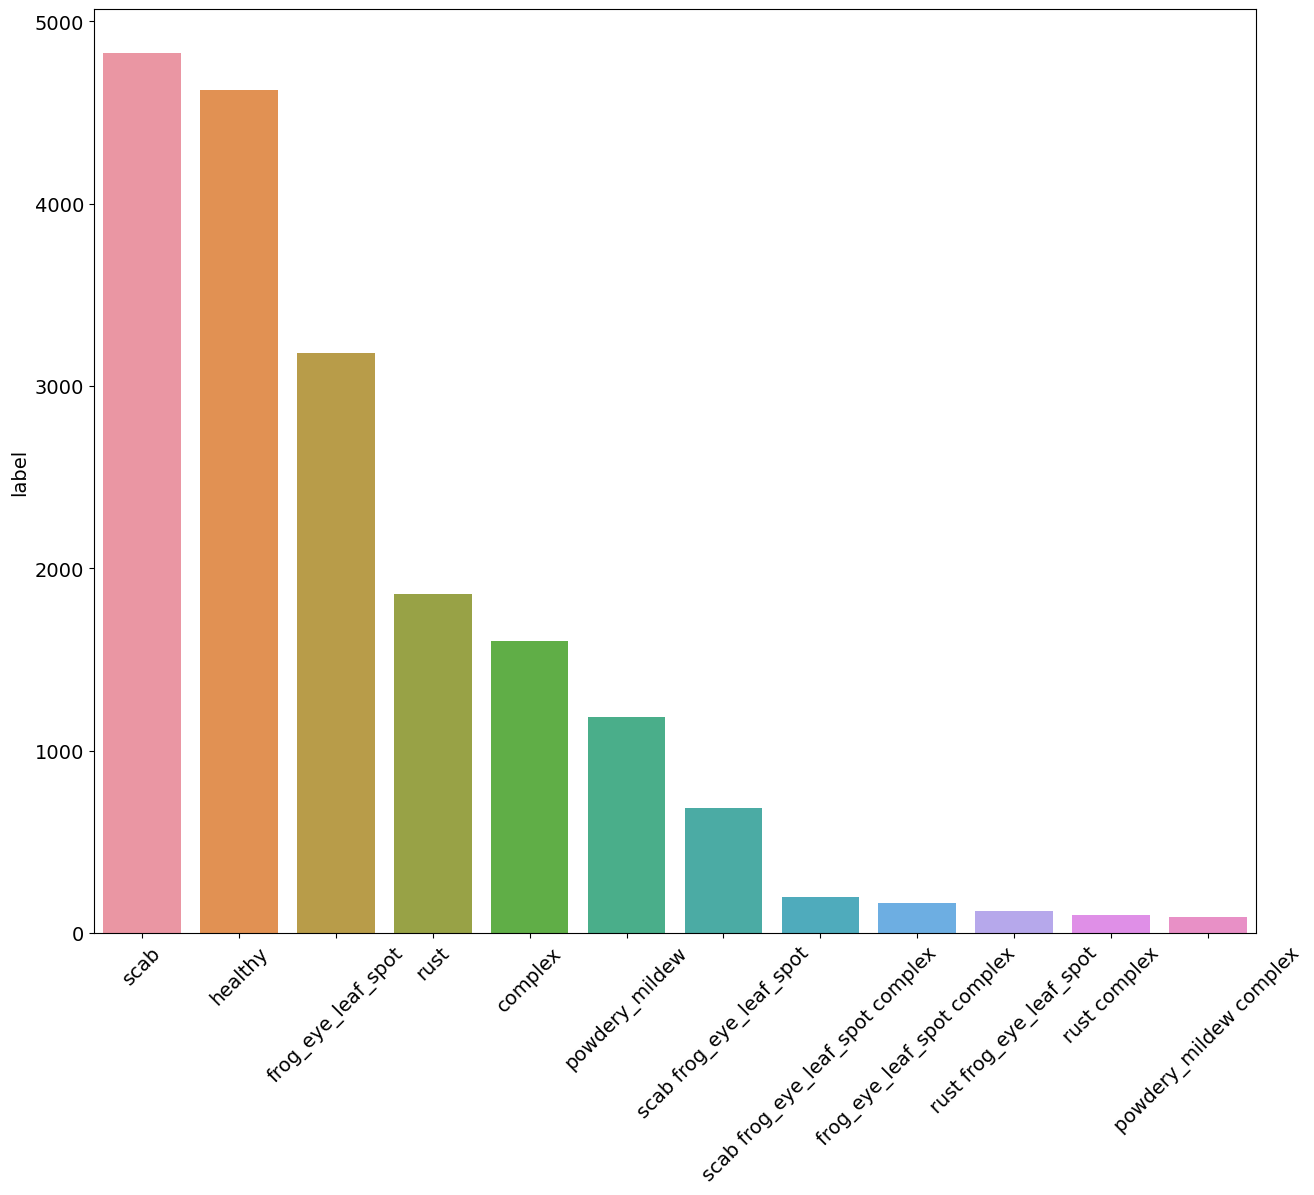

In [ ]:
plt.rc('font',size=14)
plt.figure(figsize=(15,12))
new_labels = sns.barplot(x=dfdf.label.value_counts().index,y=dfdf.label.value_counts())
for item in new_labels.get_xticklabels():
    item.set_rotation(45)

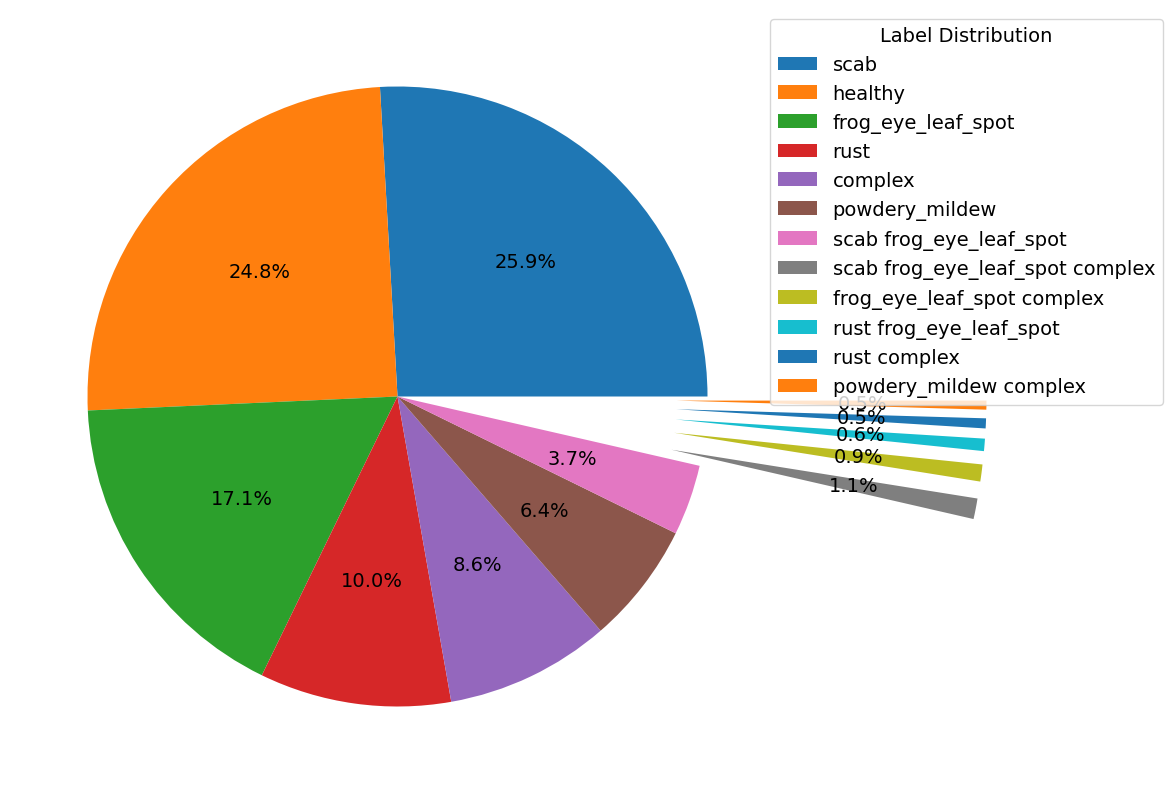

In [ ]:
plt.figure(figsize=(10,14))
plt.pie(dfdf['label'].value_counts(), labels = ['','','','','','','','','','','',''],autopct='%1.1f%%',explode=(0,0,0,0,0,0,0,0.9,0.9,0.9,0.9,0.9))
plt.legend(title = "Label Distribution",loc="upper right",bbox_to_anchor=(1.5,1),labels = dfdf['label'].value_counts().index)
plt.show()

In [ ]:
pd.set_option('display.max_columns', None)  #removes maximum numbers of displayaable columns
pd.set_option('expand_frame_repr', False)       #removes boundaries for printing
print(dfdf.head())
print('---------------------------------------------------------------------')

source = []
for i in dfdf.columns[1:]:
    source.append(dfdf[i].value_counts())
print(source)
print('---------------------------------------------------------------------')
source = []
for i in dfdf.columns[1:7]:
    source.append((dfdf[i].value_counts()[1],i))
source.sort(reverse = True)
print(source)
print(np.array(dfdf.iloc[2]))
#print([x[1] for x in source])
print('---------------------------------------------------------------------')
amount_of_labels = [x[0] for x in source]
labels_list = [x[1] for x in source]
# Get the DataFrame column names as a list
clist = list(dfdf.columns)
# Rearrange list
clist_new = clist[:1] + labels_list
new_df = dfdf[clist_new]
#new_df.loc[:, source[(:,1)]]
print(new_df)

               image_id  scab  healthy  frog_eye_leaf_spot  rust  complex  powdery_mildew                    label
0  c9b016f94de6b512.jpg     1        0                   0     0        0               0                     scab
1  97603f943f0ac1dc.jpg     0        1                   0     0        0               0                  healthy
2  ca62f80f2f42dcf0.jpg     0        0                   1     0        0               0       frog_eye_leaf_spot
3  91d981e7c95ebc84.jpg     1        0                   1     0        0               0  scab frog_eye_leaf_spot
4  ac91325ad94f5ac5.jpg     1        0                   0     0        0               0                     scab
---------------------------------------------------------------------
[0    12920
1     5712
Name: scab, dtype: int64, 0    14008
1     4624
Name: healthy, dtype: int64, 0    14280
1     4352
Name: frog_eye_leaf_spot, dtype: int64, 0    16555
1     2077
Name: rust, dtype: int64, 0    16481
1     2151
Name: co

C:\Users\Soroush\AppData\Local\Temp\ipykernel_2588\867164438.py:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




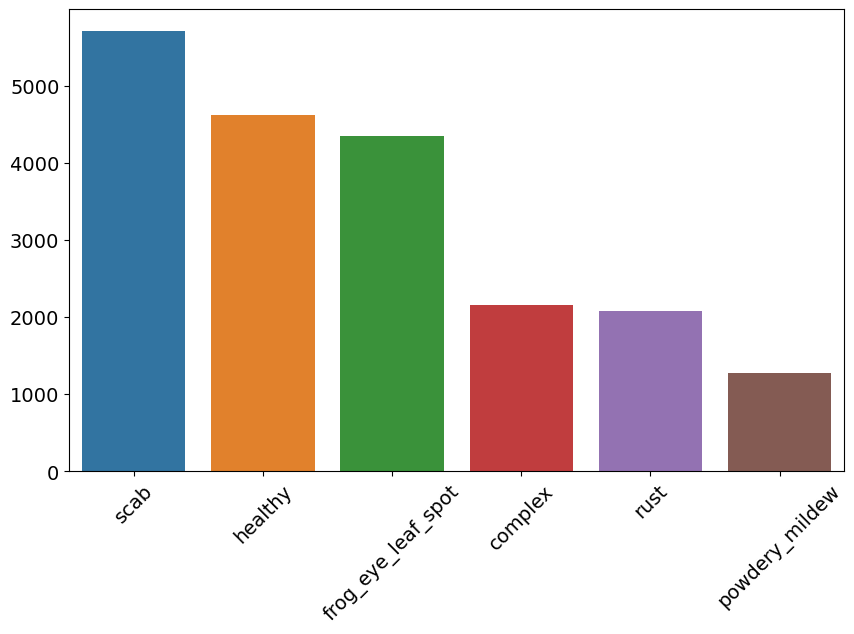

In [ ]:
plt.figure(figsize=(10,6))
new_labels = sns.barplot(data=new_df,ci=None,estimator=sum)
for item in new_labels.get_xticklabels():
    item.set_rotation(45)

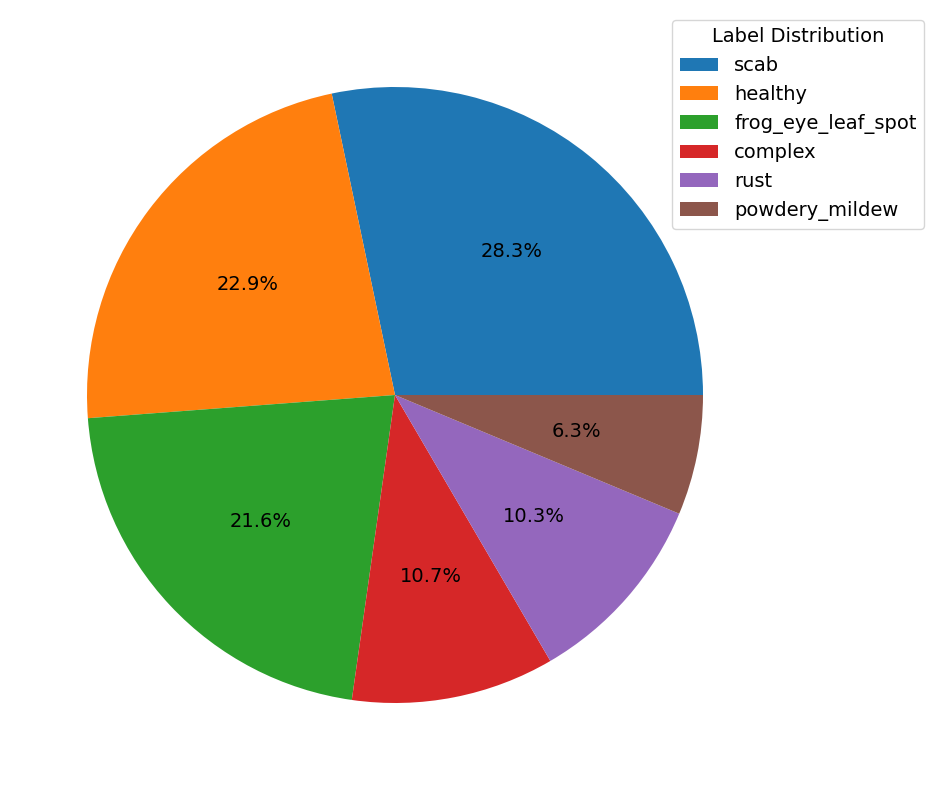

In [ ]:
plt.figure(figsize=(16,10))
plt.pie(amount_of_labels ,autopct='%1.1f%%' )#explode=(0.,0.,0.,0.,0.,0.,0.,0.9,0.9,0.9,0.9,0.9))
plt.legend(title = "Label Distribution",loc="upper right",bbox_to_anchor=(1.2,1), labels = labels_list)
plt.show()

In [ ]:
labels_list = ['scab','healthy','frog_eye_leaf_spot','rust','complex','powdery_mildew','scab frog_eye_leaf_spot','scab frog_eye_leaf_spot complex','frog_eye_leaf_spot complex','rust frog_eye_leaf_spot','rust complex','powdery_mildew complex']

classes=np.array(    [[1,0,0,0,0,0], # scab
                      [0,1,0,0,0,0], # healthy
                      [0,0,1,0,0,0], # frog_eye_leaf_spot
                      [0,0,0,1,0,0], # rust
                      [0,0,0,0,1,0], # complex
                      [0,0,0,0,0,1], # powdery_mildew
                      [1,0,1,0,0,0], # scab , frog_eye_leaf_spot
                      [1,0,1,0,1,0], # scab , frog_eye_leaf_spot , complex
                      [0,0,1,0,1,0], # frog_eye_leaf_spot , complex
                      [0,0,1,1,0,0], # frog_eye_leaf_spot , rust
                      [0,0,0,1,1,0], # complex , rust
                      [0,0,0,0,1,1]] # complex , powdery_mildew
                      ,dtype = int)

In [ ]:
class PathologyPlantsDataset(Dataset):  #  <--- جنس پارامتر ورودی از نوع دیتاست برگرفته از کتابخانه دیتاست پایتورچ می باشد
  """
  The Class will act as the container for our dataset. It will take your dataframe, the root path, and also the transform function for transforming the dataset.
  """
  def __init__(self, data_frame, root_dir, transform=None):
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform

  def __len__(self):
        # Return the length of the dataset
        return len(self.data_frame)

  def __getitem__(self, idx):
        # Return the observation based on an index. Ex. dataset[0] will return the first element from the dataset, in this case the image and the label.
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = image.filter(ImageFilter.MedianFilter(size=5))
        #image = image.convert('YCbCr')
        #image = transforms.functional.invert(image)
        #name = self.data_frame.iloc[idx, 0]
        #label = int(self.data_frame.iloc[idx, 2])
        label = np.array(self.data_frame.iloc[idx, 1:7].astype(int))
        #transforms.Compose([])
        if self.transform:
            image = self.transform(image=image)["image"]

        return (image, label)

In [ ]:
transform1 = transforms.Compose([transforms.HorizontalFlip(),transforms.VerticalFlip(),
                                transforms.Sharpen(alpha=(0.2, 0.3),lightness=(0.5, 1.0),always_apply=False,p=0.8),
                                #transforms.RandomPerspective(distortion_scale=0.3,p=0.3),
                                #transforms.CoarseDropout(max_holes=8, max_height=80,max_width=80,min_height=80,min_width=80,p=0.6),
                                transforms.ShiftScaleRotate(shift_limit=0.0625,scale_limit=0.1,rotate_limit=45,interpolation=1,border_mode=4,rotate_method='largest_box',always_apply=False,p=0.7),
                                #transforms.CenterCrop(size = (250,250)),
                                transforms.ToFloat(255, p=1.0),
                                ToTensorV2(),
                                #transforms.Normalize([0.4835, 0.6129, 0.4071], [0.1896, 0.1707, 0.1948]),
                                ])
transform2 = transforms.Compose([#transforms.CenterCrop(size = (250,250)),
                                 transforms.ToFloat(255, p=1.0),
                                 ToTensorV2(),
                                 #transforms.Normalize([0.4835, 0.6129, 0.4071], [0.1896, 0.1707, 0.1948]),

                                ])
pathology_train = PathologyPlantsDataset(data_frame = df_train, root_dir = train_image_path, transform = transform1)
pathology_val = PathologyPlantsDataset(data_frame = df_train, root_dir = train_image_path, transform = transform2)
pathology_test = PathologyPlantsDataset(data_frame = df_test, root_dir = test_image_path, transform = transform2)

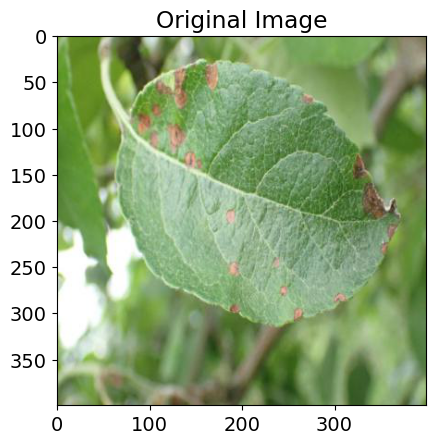

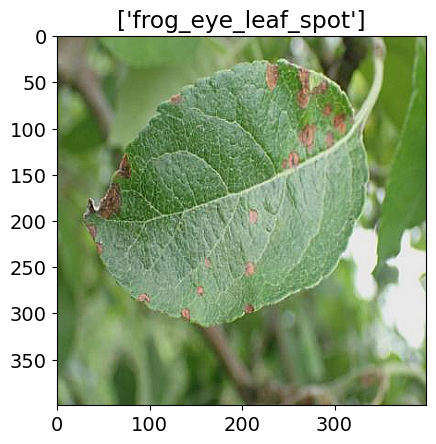

tensor([[[0.3451, 0.3647, 0.3922,  ..., 0.4627, 0.4627, 0.4706],
         [0.3569, 0.3765, 0.4078,  ..., 0.4667, 0.4549, 0.4549],
         [0.3804, 0.4039, 0.4235,  ..., 0.4784, 0.4549, 0.4275],
         ...,
         [0.3451, 0.3725, 0.4078,  ..., 0.4078, 0.3765, 0.3451],
         [0.3333, 0.3608, 0.3843,  ..., 0.4118, 0.3843, 0.3490],
         [0.3176, 0.3490, 0.3725,  ..., 0.4078, 0.3922, 0.3490]],

        [[0.3490, 0.3725, 0.3922,  ..., 0.5961, 0.6000, 0.6157],
         [0.3647, 0.3843, 0.4039,  ..., 0.6039, 0.5922, 0.6000],
         [0.3765, 0.4000, 0.4235,  ..., 0.6039, 0.5882, 0.5647],
         ...,
         [0.4588, 0.4863, 0.5255,  ..., 0.4549, 0.4275, 0.3922],
         [0.4471, 0.4745, 0.5020,  ..., 0.4588, 0.4392, 0.4078],
         [0.4314, 0.4627, 0.4902,  ..., 0.4588, 0.4471, 0.4000]],

        [[0.2275, 0.2510, 0.2706,  ..., 0.2431, 0.2157, 0.2078],
         [0.2392, 0.2627, 0.2824,  ..., 0.2510, 0.2196, 0.1882],
         [0.2549, 0.2784, 0.3020,  ..., 0.2824, 0.2431, 0.

In [ ]:
image_number = 104
temp_img, temp_label = pathology_train[image_number]
original_image = Image.open(train_image_path+"/"+str(df_train.iloc[image_number,0]))
plt.imshow(original_image)
plt.title("Original Image")
plt.show()
plt.imshow(temp_img.numpy().transpose((1, 2, 0)))
x = np.where(temp_label==1)
plt.title([labels_list[i] for i in x[0]])   #x[0] chon 2 ta array barmigardoone va ma avalish ro mikhaim
#plt.title(temp_lab)
#plt.axis('off')
plt.show()
print(temp_img)

In [ ]:
targets_size=6

model = models.swin_v2_t(weights=models.Swin_V2_T_Weights.IMAGENET1K_V1)
print(model)
print("***************************************************************************************************************************")


def start_model(printchild = False):
  model = models.swin_v2_t(weights=models.Swin_V2_T_Weights.IMAGENET1K_V1)
  for param in model.parameters():
            param.requires_grad = True
  a=0
  for child in model.children():
    child.add_module(name="Drop Block",module = DropBlock2D(drop_prob=0.2,block_size=7))
    if printchild == True:
      print("Child is:   ", child)
    if a == 0:
      break
    a+=1

  model.features[0].add_module(name="Drop Block",module = DropBlock2D(drop_prob=0.2,block_size=7))
  """
  model.layer1.add_module(name="Drop Block",module = DropBlock2D(drop_prob=0.1,block_size=7))
  model.layer2.add_module(name="Drop Block",module = DropBlock2D(drop_prob=0.1,block_size=7))
  model.layer3.add_module(name="Drop Block",module = DropBlock2D(drop_prob=0.1,block_size=7))
  model.layer4.add_module(name="Drop Block",module = DropBlock2D(drop_prob=0.1,block_size=7))
  """
  model.head = nn.Sequential(
      nn.Dropout(p=0.2,inplace=True),
      nn.Linear(768, targets_size,bias=True),
      nn.Sigmoid()
  )
  return model



model = start_model(printchild = True)
print("***************************************************************************************************************************")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cuda"
model.to(device)

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=3, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (Drop Block): DropBlock2D()
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=3, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)

In [ ]:
def batch_gd(model, criterion, optimizer, train_loader, validation_loader, epochs, foldd):
    global prev_accuracy
    global prev_loss
    global train_cm
    global validation_cm
    global train_mlcm
    global val_mlcm
    global e
    for epoch in tqdm(range(epochs)):
        t0 = datetime.now()
        train_n_correct = 0
        train_n_total = 0
        validation_n_correct = 0
        validation_n_total = 0
        train_cm = np.zeros((12,2),dtype=int)            #multi class confusion matrix
        validation_cm = np.zeros((12,2),dtype=int)       #multi class confusion matrix
        train_mlcm = np.zeros((6,2,2),dtype=int)         #multi label confusion matrix   [TN,FP]
        val_mlcm = np.zeros((6,2,2),dtype=int)           #multi label confusion matrix   [FN,TP]

        train_loss = []
        model.train()
        for inputs, targets in train_loader:
            soft_targets = torch.where(targets==0, smoothing_ratio/6, 1-smoothing_ratio + smoothing_ratio/6 )
            #print(soft_targets)
            inputs, soft_targets = inputs.to(device), soft_targets.to(device)
            optimizer.zero_grad()
            #output, aux_output = model(inputs)  #for Inception_v3
            #loss1 = criterion(output, targets)      #for Inception_v3
            #loss2 = criterion(aux_output, targets)     #for Inception_v3
            #loss = loss1 + 0.4*loss2   #for Inception_v3
            output = model(inputs)
            #print(output)
            #print(targets)
            #output, targets = output.to('cpu'), targets.to('cpu')   # for getting errors on cpu
            loss = criterion(output, soft_targets)
            train_loss.append(loss.item())
            predictions = np.array(output.cpu().detach().numpy() > threshold_array, dtype=int)
            targets = np.array(targets.cpu().detach().numpy())
            #print("predictions: ",predictions)
            #print("targets:     ",targets)
            train_mlcm = train_mlcm + multilabel_confusion_matrix(targets,predictions)
            for i in range(len(targets)):
                class_number = int(np.where((classes == targets[i]).all(axis=1))[0])
                if (predictions[i] == targets[i]).all():
                    train_cm[class_number][0] += 1
                else:
                    train_cm[class_number][1] += 1
            loss.backward()        # این دو خط بهتره اینجا بمونن وگرنه اگر بالاتر بزاریم به جای 11 دقیقه، 17 دقیقه طول میکشه
            optimizer.step()       # این دو خط بهتره اینجا بمونن وگرنه اگر بالاتر بزاریم به جای 11 دقیقه، 17 دقیقه طول میکشه

        train_loss = np.mean(train_loss)
        train_accuracy = (train_cm[:,0].sum()/(train_mlcm[0].sum()))


        validation_loss = []
        model.eval()
        with torch.no_grad():
          for inputs, targets in validation_loader:
            soft_targets = torch.where(targets==0, smoothing_ratio/targets_size, 1-smoothing_ratio + smoothing_ratio/targets_size )
            #print(soft_targets)
            inputs, soft_targets = inputs.to(device), soft_targets.to(device)
            output = model(inputs)
            #print(output)
            #output, aux_output = model(inputs)  #for Inception_v3
            loss = criterion(output, soft_targets)
            validation_loss.append(loss.item())
            predictions = np.array(output.cpu().detach().numpy() > threshold_array, dtype=int)
            targets = np.array(targets.cpu().detach().numpy())
            #print("predictions: ",predictions)
            #print("targets:     ",targets)
            val_mlcm = val_mlcm + multilabel_confusion_matrix(targets,predictions)
            for i in range(len(targets)):
                class_number = int(np.where((classes == targets[i]).all(axis=1))[0])
                if (predictions[i] == targets[i]).all():
                    validation_cm[class_number][0] += 1
                else:
                    validation_cm[class_number][1] += 1
        validation_loss = np.mean(validation_loss)
        validation_accuracy = (validation_cm[:,0].sum()/(val_mlcm[0].sum()))

        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)
        dt = datetime.now() - t0
        for g in optimizer.param_groups:
          lr = g['lr']
        if epoch < 25 :
          scheduler1.step()
        print()
        print('----------------------------------------------------------------------------------------')
        print(f"Epoch : {epoch+1} Train_loss:{train_loss:.3f} Validation_loss:{validation_loss:.3f} Duration:{dt} Lr: {lr} Train_Acc:{train_accuracy*100:.2f} Validation_Acc:{validation_accuracy*100:.2f}")
        print("class ac",end=" : ")
        class_accuracy_train = train_cm[:,0]/train_cm.sum(axis=1)*100
        print(class_accuracy_train)
        print("class ac",end=" : ")
        class_accuracy_validation = validation_cm[:,0]/validation_cm.sum(axis=1)*100
        print(class_accuracy_validation)
        print('Multi_Label_Metrics:')
        #label_names = ['Scab              ','Healthy           ','Frog_eye_leaf_spot','Rust              ','Complex           ','Powdery_mildew    ']
        print('                       Recall            Precision           F1 Score      ')
        temp_list = []
        for i in range(6):
          #acc = (train_mlcm[i,0,0]+train_mlcm[i,1,1])/(train_mlcm[0].sum())
          rec = (train_mlcm[i,1,1])/(train_mlcm[i,1,1]+train_mlcm[i,1,0])
          pre = (train_mlcm[i,1,1])/(train_mlcm[i,1,1]+train_mlcm[i,0,1])
          f1  = (2*train_mlcm[i,1,1])/(2*train_mlcm[i,1,1]+train_mlcm[i,0,1]+train_mlcm[i,1,0])
          print(label_names[i],rec,pre,f1)
          temp_list.append(f1)
        train_ml_f1.append(temp_list)
        print()
        temp_list = []
        for i in range(6):
          #acc = (val_mlcm[i,0,0]+val_mlcm[i,1,1])/(val_mlcm[0].sum())
          rec = (val_mlcm[i,1,1])/(val_mlcm[i,1,1]+val_mlcm[i,1,0])
          pre = (val_mlcm[i,1,1])/(val_mlcm[i,1,1]+val_mlcm[i,0,1])
          f1  = (2*val_mlcm[i,1,1])/(2*val_mlcm[i,1,1]+val_mlcm[i,0,1]+val_mlcm[i,1,0])
          print(label_names[i],rec,pre,f1)
          temp_list.append(f1)
        val_ml_f1.append(temp_list)
        if train_accuracy - validation_accuracy > 0.0 and validation_accuracy > prev_accuracy and epoch+1 < epochs:
            prev_accuracy = validation_accuracy
            os.chdir('C:/Local Machine/plant-pathology-final-3/saves')
            torch.save(model, 'swinv2t'+str(foldd)+'.pt')
            print("!")
    return train_losses, validation_losses

**********  fold no  ********************  1  ********************


  3%|██▋                                                                             | 1/30 [09:47<4:44:04, 587.75s/it]


----------------------------------------------------------------------------------------
Epoch : 1 Train_loss:0.329 Validation_loss:0.279 Duration:0:09:47.750048 Lr: 0.0001 Train_Acc:54.44 Validation_Acc:77.13
class ac : [63.69220821 70.11844332 59.12444663 59.39086294  1.64728682 54.85564304
  7.15935335 25.38461538 30.47619048  8.75        7.57575758  3.77358491]
class ac : [95.97637505 77.98241248 97.02898841 92.73303916  0.         96.13319012
 10.39304611 30.92145949 30.23431595  0.          6.00240096  0.        ]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.8183807439824945 0.5932976402934761 0.6878951603632601
Healthy            0.8984771573604061 0.6990521327014217 0.7863171923589516
Frog_eye_leaf_spot 0.8403451995685005 0.6362646338143207 0.72420204524326
Rust               0.7733433734939759 0.7377873563218391 0.7551470588235294
Complex            0.551948051948052 0.4295339696799551 0.4831070413640669

  7%|█████▎                                                                          | 2/30 [19:22<4:30:47, 580.27s/it]


----------------------------------------------------------------------------------------
Epoch : 2 Train_loss:0.280 Validation_loss:0.255 Duration:0:09:35.028002 Lr: 9.964516155915151e-05 Train_Acc:72.36 Validation_Acc:81.27
class ac : [84.51341739 89.27241963 80.61977373 81.72588832  2.22868217 78.87139108
  5.08083141 40.76923077 39.04761905  5.         31.81818182 11.32075472]
class ac : [95.84453937 94.15961507 96.62804218 91.00937672  1.98522989 92.91084855
  4.72411187 37.10575139 68.02721088  5.10204082 30.0120048  15.69858713]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.887308533916849 0.75512104283054 0.8158953722334004
Healthy            0.9688663282571912 0.8763391490664217 0.9202828672452588
Frog_eye_leaf_spot 0.9234088457389428 0.7341337907375644 0.8179646440516005
Rust               0.920933734939759 0.8411279229711142 0.8792235801581596
Complex            0.7085137085137085 0.5374931581828134 0.61

 10%|████████                                                                        | 3/30 [28:57<4:19:57, 577.70s/it]


----------------------------------------------------------------------------------------
Epoch : 3 Train_loss:0.272 Validation_loss:0.255 Duration:0:09:34.636985 Lr: 9.858624225078841e-05 Train_Acc:74.77 Validation_Acc:80.28
class ac : [87.29388943 91.37055838 83.27594688 83.58714044  4.94186047 82.80839895
  3.23325635 46.15384615 38.0952381   2.5        42.42424242 16.98113208]
class ac : [95.31719665 91.53254798 96.8285153  79.97793712  8.33796554 98.81847476
  6.61375661 52.56648114 34.01360544  0.         42.01680672  7.84929356]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9039934354485777 0.7833609860156435 0.8393650793650793
Healthy            0.9712351945854484 0.8979974968710889 0.9331815964883758
Frog_eye_leaf_spot 0.9295217547644732 0.751453488372093 0.8310561003054171
Rust               0.9352409638554217 0.8460490463215259 0.8884120171673819
Complex            0.7352092352092352 0.5553133514986376 0

 13%|██████████▋                                                                     | 4/30 [37:40<4:01:04, 556.32s/it]


----------------------------------------------------------------------------------------
Epoch : 4 Train_loss:0.265 Validation_loss:0.252 Duration:0:08:43.551689 Lr: 9.683994186497132e-05 Train_Acc:76.96 Validation_Acc:82.54
class ac : [89.29841578 92.52115059 86.81751107 85.19458545  5.03875969 87.5328084
  5.31177829 58.46153846 38.0952381   6.25       48.48484848 26.41509434]
class ac : [97.42656753 96.64841546 98.23182711 85.83838941  1.98522989 97.7443609
 11.33786848 68.02721088 22.67573696  0.         30.0120048  23.54788069]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9201312910284464 0.7998097955301949 0.8557618926481811
Healthy            0.9776649746192894 0.9183089637635092 0.9470578593673168
Frog_eye_leaf_spot 0.9367134124415678 0.7570473699505957 0.8373513339762134
Rust               0.9510542168674698 0.8591836734693877 0.9027877055039314
Complex            0.7756132756132756 0.5820249052517596 0.

 17%|█████████████▎                                                                  | 5/30 [45:52<3:42:00, 532.84s/it]


----------------------------------------------------------------------------------------
Epoch : 5 Train_loss:0.261 Validation_loss:0.256 Duration:0:08:11.194208 Lr: 9.443380060197387e-05 Train_Acc:78.16 Validation_Acc:75.90
class ac : [91.10895571 94.17935702 87.01426463 86.97123519  7.65503876 87.4015748
  3.926097   56.15384615 33.33333333  3.75       42.42424242 39.62264151]
class ac : [99.27226705 82.13041314 75.37789182 73.77275234 20.24934487 98.28141783
  1.88964475 61.84291899 52.91005291  0.         42.01680672 31.39717425]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9239606126914661 0.8153511947863866 0.8662649057571483
Healthy            0.9810490693739424 0.9294645719781981 0.9545604214685545
Frog_eye_leaf_spot 0.9363538295577131 0.7596266044340724 0.8387824126268321
Rust               0.9525602409638554 0.8623040218132243 0.9051878354203936
Complex            0.7828282828282829 0.5874390904168922 0

 20%|████████████████                                                                | 6/30 [54:03<3:27:26, 518.61s/it]


----------------------------------------------------------------------------------------
Epoch : 6 Train_loss:0.257 Validation_loss:0.251 Duration:0:08:10.981714 Lr: 9.140576474687265e-05 Train_Acc:79.25 Validation_Acc:83.84
class ac : [91.75557711 94.55160745 88.44072799 86.37901861 12.1124031  89.10761155
  6.00461894 60.         42.85714286  1.25       45.45454545 28.30188679]
class ac : [ 97.69023889 100.10508268  99.63513893  80.6674021    8.73501151
  98.28141783  14.1723356   58.75077304  26.45502646   5.10204082
  30.0120048   15.69858713]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9346280087527352 0.8237704918032787 0.8757047667862634
Healthy            0.983756345177665 0.9332263242375602 0.957825370675453
Frog_eye_leaf_spot 0.9395900755124056 0.7744516893894487 0.8490658001624696
Rust               0.9487951807228916 0.8636052090472927 0.9041980624327234
Complex            0.7987012987012987 0.595161

 23%|██████████████████▏                                                           | 7/30 [1:02:14<3:15:21, 509.64s/it]


----------------------------------------------------------------------------------------
Epoch : 7 Train_loss:0.254 Validation_loss:0.247 Duration:0:08:11.180001 Lr: 8.780358823396353e-05 Train_Acc:79.45 Validation_Acc:82.60
class ac : [91.43226641 94.14551607 89.12936547 86.04060914 13.56589147 90.28871391
  6.69745958 58.46153846 40.95238095  8.75       50.         35.8490566 ]
class ac : [98.74492433 95.81881533 97.42993465 77.22007722  7.54387358 99.35553169
 15.11715797 77.30364873 26.45502646  5.10204082 30.0120048  31.39717425]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9321663019693655 0.8239845261121856 0.8747433264887063
Healthy            0.9820642978003384 0.9337194337194337 0.9572818736599044
Frog_eye_leaf_spot 0.9464221503056455 0.7782377291543465 0.8541294823949376
Rust               0.9555722891566265 0.8727647867950481 0.9122933141624731
Complex            0.8210678210678211 0.61248654467169 0.

 27%|████████████████████▊                                                         | 8/30 [1:10:25<3:04:44, 503.84s/it]


----------------------------------------------------------------------------------------
Epoch : 8 Train_loss:0.252 Validation_loss:0.243 Duration:0:08:11.414454 Lr: 8.368407953869104e-05 Train_Acc:80.33 Validation_Acc:84.11
class ac : [92.49919172 95.29610829 89.42449582 87.30964467 15.60077519 88.97637795
  4.15704388 66.15384615 41.9047619   7.5        56.06060606 39.62264151]
class ac : [ 99.79960977  93.33001493  95.42520348  91.35410921  15.88183912
 100.96670247  14.1723356   77.30364873  26.45502646   0.
  30.0120048   39.24646782]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.938457330415755 0.8392857142857143 0.8861053719008265
Healthy            0.9830795262267343 0.9410430839002267 0.9616021185038067
Frog_eye_leaf_spot 0.9431859043509528 0.7808871688002381 0.8543973941368078
Rust               0.9608433734939759 0.8698023176550784 0.9130590339892666
Complex            0.8333333333333334 0.6124072110286

 30%|███████████████████████▍                                                      | 9/30 [1:18:37<2:54:59, 499.97s/it]


----------------------------------------------------------------------------------------
Epoch : 9 Train_loss:0.250 Validation_loss:0.242 Duration:0:08:11.480901 Lr: 7.911220577405484e-05 Train_Acc:81.13 Validation_Acc:83.08
class ac : [93.11348206 95.46531303 90.01475652 89.00169205 18.50775194 90.6824147
  6.69745958 57.69230769 38.0952381   8.75       48.48484848 49.05660377]
class ac : [97.42656753 99.27548255 86.20344012 87.56205185 21.83752879 98.28141783
  2.83446712 64.93506494 45.35147392  0.         30.0120048  62.79434851]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9398249452954048 0.8413320274240941 0.8878552971576228
Healthy            0.9847715736040609 0.9466493168510085 0.9653342179465915
Frog_eye_leaf_spot 0.9388709097446961 0.788821752265861 0.8573304876046626
Rust               0.954066265060241 0.8768166089965398 0.9138117562206997
Complex            0.8477633477633477 0.630703166935051 0.72

 33%|█████████████████████████▋                                                   | 10/30 [1:26:48<2:45:46, 497.32s/it]


----------------------------------------------------------------------------------------
Epoch : 10 Train_loss:0.248 Validation_loss:0.242 Duration:0:08:11.388215 Lr: 7.416006812042827e-05 Train_Acc:81.75 Validation_Acc:84.62
class ac : [94.21273844 96.07445008 90.55582882 88.07106599 18.79844961 90.28871391
  9.23787529 63.07692308 40.         12.5        50.         45.28301887]
class ac : [98.21758161 99.55201593 90.21290245 86.87258687 31.76367823 97.20730397
  4.72411187 49.47433519 37.79289494  0.         36.01440576 62.79434851]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9463894967177243 0.8499140260378285 0.8955610198006988
Healthy            0.9857868020304569 0.9538310412573674 0.9695456814777833
Frog_eye_leaf_spot 0.945702984537936 0.7888422315536893 0.8601798855273917
Rust               0.9668674698795181 0.8842975206611571 0.9237410071942446
Complex            0.8477633477633477 0.6368563685636857 

 37%|████████████████████████████▏                                                | 11/30 [1:34:59<2:36:54, 495.50s/it]


----------------------------------------------------------------------------------------
Epoch : 11 Train_loss:0.245 Validation_loss:0.247 Duration:0:08:11.379623 Lr: 6.890576474687263e-05 Train_Acc:83.05 Validation_Acc:83.36
class ac : [94.60071128 96.81895093 91.68716183 89.00169205 23.15891473 93.30708661
 11.54734411 61.53846154 45.71428571 10.         54.54545455 52.83018868]
class ac : [90.96661921 98.30761573 92.0171605  89.97517926 30.17549432 99.89258861
  6.61375661 61.84291899 37.79289494  5.10204082 42.01680672 62.79434851]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9452954048140044 0.8648648648648649 0.9032932566649242
Healthy            0.9891708967851099 0.9574189321978382 0.9730359520639148
Frog_eye_leaf_spot 0.9503775620280475 0.802367941712204 0.8701234567901235
Rust               0.9646084337349398 0.8883495145631068 0.9249097472924188
Complex            0.8578643578643579 0.6507936507936508 

 40%|██████████████████████████████▊                                              | 12/30 [1:43:11<2:28:14, 494.16s/it]


----------------------------------------------------------------------------------------
Epoch : 12 Train_loss:0.243 Validation_loss:0.245 Duration:0:08:11.087754 Lr: 6.343215915635762e-05 Train_Acc:83.76 Validation_Acc:85.89
class ac : [95.37665697 97.05583756 91.63797344 89.9323181  27.81007752 93.30708661
 11.31639723 60.76923077 37.14285714 12.5        53.03030303 64.1509434 ]
class ac : [ 95.71270369 101.34948288  99.63513893  92.04357419  25.01389661
  96.67024705   6.61375661  40.19789734  41.57218443   5.10204082
  30.0120048   54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9535010940919038 0.8710644677661169 0.9104204753199269
Healthy            0.9932318104906938 0.96514304505097 0.9789859906604403
Frog_eye_leaf_spot 0.9507371449119022 0.8127881955118352 0.8763672522373218
Rust               0.9676204819277109 0.891123439667129 0.927797833935018
Complex            0.8614718614718615 0.6528157

 43%|█████████████████████████████████▎                                           | 13/30 [1:51:22<2:19:45, 493.26s/it]


----------------------------------------------------------------------------------------
Epoch : 13 Train_loss:0.241 Validation_loss:0.242 Duration:0:08:11.189776 Lr: 5.782557337881911e-05 Train_Acc:84.46 Validation_Acc:86.47
class ac : [95.63530553 97.2927242  92.12985735 91.79357022 30.03875969 92.65091864
 13.16397229 64.61538462 36.19047619 16.25       59.09090909 62.26415094]
class ac : [ 97.29473185 101.34948288  96.62804218  87.90678434  33.35186215
  97.20730397  12.28269085  49.47433519  49.13076342   5.10204082
  18.00720288  62.79434851]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9554157549234136 0.8719420868696954 0.9117723831897677
Healthy            0.9908629441624366 0.9672943508424182 0.9789368104312939
Frog_eye_leaf_spot 0.9528946422150306 0.8171446191797718 0.8798140770252324
Rust               0.9743975903614458 0.9036312849162011 0.9376811594202898
Complex            0.8831168831168831 0.668

 47%|███████████████████████████████████▉                                         | 14/30 [1:59:33<2:11:23, 492.69s/it]


----------------------------------------------------------------------------------------
Epoch : 14 Train_loss:0.238 Validation_loss:0.241 Duration:0:08:11.369239 Lr: 5.2174426621180906e-05 Train_Acc:85.16 Validation_Acc:86.78
class ac : [96.15260265 97.9357022  92.81849484 90.43993232 32.26744186 95.27559055
 14.3187067  66.92307692 30.47619048 16.25       63.63636364 67.9245283 ]
class ac : [ 98.48125297 101.21121619  96.8285153   88.9409818   32.16072421
  95.59613319  17.95162509  68.02721088  26.45502646   0.
  18.00720288  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9600656455142232 0.8775 0.9169278996865203
Healthy            0.993570219966159 0.9757394483217016 0.9845741113346748
Frog_eye_leaf_spot 0.9478604818410644 0.82375 0.881457950175556
Rust               0.9706325301204819 0.9001396648044693 0.9340579710144927
Complex            0.8939393939393939 0.6752043596730245 0.7693262961813101

 50%|██████████████████████████████████████▌                                      | 15/30 [2:07:44<2:03:03, 492.20s/it]


----------------------------------------------------------------------------------------
Epoch : 15 Train_loss:0.237 Validation_loss:0.245 Duration:0:08:11.076764 Lr: 4.65678408436424e-05 Train_Acc:85.99 Validation_Acc:86.64
class ac : [95.95861623 97.76649746 93.31037875 91.45516074 37.98449612 93.56955381
 23.55658199 63.07692308 43.80952381 13.75       56.06060606 66.03773585]
class ac : [ 96.76738913 101.48774957  99.03371958  89.28571429  26.9991265
  98.28141783  25.51020408  43.29004329  37.79289494   5.10204082
  24.00960384  31.39717425]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9570568927789934 0.8858227848101266 0.9200631080725743
Healthy            0.994585448392555 0.9722130334105193 0.9832719973235196
Frog_eye_leaf_spot 0.9561308881697231 0.8343269532475682 0.8910857908847185
Rust               0.9713855421686747 0.9097320169252469 0.9395484340859432
Complex            0.8874458874458875 0.699658

 53%|█████████████████████████████████████████                                    | 16/30 [2:15:55<1:54:46, 491.90s/it]


----------------------------------------------------------------------------------------
Epoch : 16 Train_loss:0.235 Validation_loss:0.243 Duration:0:08:11.182661 Lr: 4.109423525312738e-05 Train_Acc:86.71 Validation_Acc:87.09
class ac : [96.76689298 97.46192893 93.50713232 91.96277496 41.76356589 94.61942257
 25.40415704 63.07692308 38.0952381  23.75       59.09090909 67.9245283 ]
class ac : [ 98.08574593 101.62601626  98.23182711  83.76999448  32.16072421
  96.13319012  29.28949358  68.02721088  30.23431595  10.20408163
  18.00720288  54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9576039387308534 0.8883532098452169 0.9216796103725154
Healthy            0.9939086294416244 0.9728386883073865 0.983260796786073
Frog_eye_leaf_spot 0.9550521395181589 0.846668791839337 0.8976005407232173
Rust               0.9759036144578314 0.9165487977369166 0.9452954048140044
Complex            0.8845598845598845 0.71279

 57%|███████████████████████████████████████████▋                                 | 17/30 [2:24:07<1:46:31, 491.69s/it]


----------------------------------------------------------------------------------------
Epoch : 17 Train_loss:0.232 Validation_loss:0.243 Duration:0:08:11.213748 Lr: 3.583993187957173e-05 Train_Acc:87.61 Validation_Acc:87.67
class ac : [97.05787262 98.6463621  94.44171176 91.53976311 45.25193798 95.66929134
 23.55658199 66.92307692 43.80952381 17.5        62.12121212 79.24528302]
class ac : [ 98.87676001 101.62601626  96.62804218  89.63044677  32.55777019
  96.13319012  29.28949358  61.84291899  37.79289494  15.30612245
  18.00720288  54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9649890590809628 0.9062419727716414 0.93469333686581
Healthy            0.9959390862944163 0.9806731089636788 0.9882471457353929
Frog_eye_leaf_spot 0.9604458827759799 0.8552673711175152 0.9048102981029811
Rust               0.9721385542168675 0.9188612099644128 0.9447493596780095
Complex            0.9054834054834054 0.70783

 60%|██████████████████████████████████████████████▏                              | 18/30 [2:32:18<1:38:19, 491.64s/it]


----------------------------------------------------------------------------------------
Epoch : 18 Train_loss:0.231 Validation_loss:0.242 Duration:0:08:11.373021 Lr: 3.088779422594514e-05 Train_Acc:87.86 Validation_Acc:87.74
class ac : [97.1871969  98.81556684 94.73684211 91.11675127 44.57364341 96.06299213
 29.56120092 63.84615385 48.57142857 16.25       59.09090909 79.24528302]
class ac : [ 97.55840321 101.62601626  97.22946153  86.87258687  36.13118399
  95.59613319  36.84807256  68.02721088  26.45502646  20.40816327
  12.00480192  70.64364207]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9660831509846827 0.9070364663585002 0.9356291390728477
Healthy            0.9959390862944163 0.9819819819819819 0.9889112903225806
Frog_eye_leaf_spot 0.9579288025889967 0.8552166934189406 0.903663500678426
Rust               0.9781626506024096 0.9173728813559322 0.9467930029154519
Complex            0.9040404040404041 0.7255

 63%|████████████████████████████████████████████████▊                            | 19/30 [2:40:29<1:30:06, 491.53s/it]


----------------------------------------------------------------------------------------
Epoch : 19 Train_loss:0.228 Validation_loss:0.242 Duration:0:08:11.116289 Lr: 2.631592046130896e-05 Train_Acc:88.98 Validation_Acc:88.93
class ac : [97.63983188 98.95093063 95.17953763 91.87817259 49.70930233 96.45669291
 36.48960739 66.15384615 43.80952381 25.         69.6969697  77.35849057]
class ac : [ 99.79960977 100.38161606  98.23182711  93.42250414  37.32232192
  96.67024705  37.79289494  58.75077304  37.79289494  20.40816327
   6.00240096  54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9721006564551422 0.9101152368758002 0.9400872900409999
Healthy            0.9983079526226735 0.9856331440026729 0.991930060524546
Frog_eye_leaf_spot 0.9651204602660913 0.8680465717981889 0.914013281116976
Rust               0.9804216867469879 0.9266903914590747 0.9527991218441273
Complex            0.9126984126984127 0.74455

 67%|███████████████████████████████████████████████████▎                         | 20/30 [2:48:41<1:21:55, 491.55s/it]


----------------------------------------------------------------------------------------
Epoch : 20 Train_loss:0.228 Validation_loss:0.240 Duration:0:08:11.471924 Lr: 2.2196411766036492e-05 Train_Acc:89.71 Validation_Acc:89.38
class ac : [97.96314258 98.88324873 95.72060994 92.80879865 55.32945736 96.32545932
 37.18244804 63.07692308 50.47619048 23.75       59.09090909 81.13207547]
class ac : [100.06328113 101.62601626  99.23419269  92.04357419  37.7193679
  96.67024705  39.68253968  58.75077304  30.23431595  20.40816327
   0.          62.79434851]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9693654266958425 0.9195640892579139 0.9438082556591212
Healthy            0.9962774957698816 0.9875880576987588 0.9919137466307277
Frog_eye_leaf_spot 0.9633225458468176 0.8766361256544503 0.9179372965564502
Rust               0.9819277108433735 0.9347670250896057 0.9577671685640837
Complex            0.9177489177489178 0.755

 70%|█████████████████████████████████████████████████████▉                       | 21/30 [2:56:52<1:13:43, 491.46s/it]


----------------------------------------------------------------------------------------
Epoch : 21 Train_loss:0.226 Validation_loss:0.243 Duration:0:08:11.229194 Lr: 1.859423525312737e-05 Train_Acc:90.26 Validation_Acc:89.00
class ac : [97.80148723 99.05245347 95.62223315 92.55499154 57.94573643 97.24409449
 39.26096998 73.84615385 45.71428571 35.         69.6969697  86.79245283]
class ac : [ 99.53593841 101.62601626  98.83324646  91.00937672  35.73413801
  96.13319012  45.35147392  52.56648114  26.45502646  30.6122449
   0.          54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9762035010940919 0.9234152652005174 0.9490759207552187
Healthy            0.9979695431472081 0.9876088412592097 0.9927621612523144
Frog_eye_leaf_spot 0.9651204602660913 0.8855163312438139 0.9236063317274604
Rust               0.9849397590361446 0.9356223175965666 0.9596478356566398
Complex            0.9141414141414141 0.7609

 73%|████████████████████████████████████████████████████████▍                    | 22/30 [3:05:03<1:05:31, 491.38s/it]


----------------------------------------------------------------------------------------
Epoch : 22 Train_loss:0.224 Validation_loss:0.244 Duration:0:08:11.206956 Lr: 1.556619939802614e-05 Train_Acc:90.87 Validation_Acc:88.70
class ac : [98.25412221 99.12013536 95.47466798 93.31641286 59.30232558 97.63779528
 45.72748268 74.61538462 51.42857143 37.5        69.6969697  79.24528302]
class ac : [ 97.95391025 101.62601626  96.62804218  91.35410921  40.49868975
  96.67024705  39.68253968  61.84291899  37.79289494  30.6122449
   0.          54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9781181619256017 0.9249870667356441 0.9508109545333688
Healthy            0.9979695431472081 0.9899295065458208 0.993933265925177
Frog_eye_leaf_spot 0.9694354548723481 0.8891820580474934 0.9275761224840874
Rust               0.9864457831325302 0.9410919540229885 0.9632352941176471
Complex            0.9271284271284271 0.77926

 77%|████████████████████████████████████████████████████████████▌                  | 23/30 [3:13:15<57:19, 491.37s/it]


----------------------------------------------------------------------------------------
Epoch : 23 Train_loss:0.224 Validation_loss:0.241 Duration:0:08:11.349832 Lr: 1.316005813502869e-05 Train_Acc:91.11 Validation_Acc:88.76
class ac : [98.31878435 99.18781726 96.31087063 94.16243655 58.91472868 97.90026247
 48.72979215 64.61538462 52.38095238 36.25       66.66666667 83.01886792]
class ac : [ 98.74492433 101.76428295  97.42993465  91.00937672  40.49868975
  96.67024705  34.95842782  55.65862709  30.23431595  30.6122449
   6.00240096  54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.975109409190372 0.9312957157784744 0.952699091394976
Healthy            0.9979695431472081 0.9895973154362416 0.9937657961246841
Frog_eye_leaf_spot 0.966918374685365 0.892465980750083 0.9282015878494995
Rust               0.9796686746987951 0.9359712230215828 0.9573215599705666
Complex            0.9177489177489178 0.79301745

 80%|███████████████████████████████████████████████████████████████▏               | 24/30 [3:21:26<49:07, 491.31s/it]


----------------------------------------------------------------------------------------
Epoch : 24 Train_loss:0.223 Validation_loss:0.242 Duration:0:08:11.137663 Lr: 1.1413757749211607e-05 Train_Acc:91.65 Validation_Acc:88.97
class ac : [98.38344649 99.52622673 96.31087063 94.24703892 60.27131783 97.90026247
 50.80831409 69.23076923 52.38095238 47.5        78.78787879 92.45283019]
class ac : [ 99.40410273 101.76428295  96.42756906  87.56205185  42.48391964
  96.67024705  48.18594104  52.56648114  30.23431595  30.6122449
   0.          47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9786652078774617 0.9366492146596859 0.9571963616907437
Healthy            0.9983079526226735 0.9925975773889637 0.9954445756706597
Frog_eye_leaf_spot 0.9715929521754765 0.8947019867549669 0.9315635235304258
Rust               0.9864457831325302 0.9350463954318344 0.9600586295346281
Complex            0.9401154401154401 0.798

 83%|█████████████████████████████████████████████████████████████████▊             | 25/30 [3:29:37<40:56, 491.22s/it]


----------------------------------------------------------------------------------------
Epoch : 25 Train_loss:0.222 Validation_loss:0.243 Duration:0:08:11.017983 Lr: 1.0354838440848501e-05 Train_Acc:91.81 Validation_Acc:88.87
class ac : [98.41577756 99.22165821 96.70437777 93.14720812 64.53488372 96.9816273
 53.57967667 70.         55.23809524 36.25       74.24242424 77.35849057]
class ac : [ 99.14043137 101.76428295  96.22709595  89.28571429  44.46914953
  96.13319012  37.79289494  46.38218924  41.57218443  30.6122449
   0.          54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9797592997811816 0.9357366771159875 0.9572421165152325
Healthy            0.9979695431472081 0.9915938130464022 0.9947714623039299
Frog_eye_leaf_spot 0.9715929521754765 0.8994673768308922 0.9341400172860848
Rust               0.9849397590361446 0.9450867052023122 0.9646017699115044
Complex            0.943001443001443 0.80480

 87%|████████████████████████████████████████████████████████████████████▍          | 26/30 [3:37:48<32:45, 491.28s/it]


----------------------------------------------------------------------------------------
Epoch : 26 Train_loss:0.222 Validation_loss:0.242 Duration:0:08:11.414746 Lr: 1e-05 Train_Acc:91.99 Validation_Acc:89.04
class ac : [98.41577756 99.49238579 96.40924742 93.7394247  64.72868217 97.76902887
 51.50115473 74.61538462 53.33333333 41.25       75.75757576 84.90566038]
class ac : [ 99.53593841 101.48774957  95.6256766   91.35410921  44.07210355
  96.67024705  34.01360544  64.93506494  37.79289494  30.6122449
   6.00240096  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9770240700218819 0.9380252100840336 0.9571275455519829
Healthy            0.9989847715736041 0.9926025554808339 0.9957834373418789
Frog_eye_leaf_spot 0.9687162891046386 0.905241935483871 0.9359041167274622
Rust               0.9864457831325302 0.9404163675520459 0.9628812936420433
Complex            0.9365079365079365 0.8027210884353742 0.86

 90%|███████████████████████████████████████████████████████████████████████        | 27/30 [3:46:00<24:33, 491.27s/it]


----------------------------------------------------------------------------------------
Epoch : 27 Train_loss:0.222 Validation_loss:0.242 Duration:0:08:11.264661 Lr: 1e-05 Train_Acc:91.93 Validation_Acc:88.93
class ac : [98.28645328 99.357022   96.21249385 94.24703892 64.0503876  97.50656168
 52.88683603 79.23076923 50.47619048 45.         68.18181818 86.79245283]
class ac : [ 99.00859569 101.76428295  95.82614971  91.00937672  42.48391964
  95.05907626  40.62736206  58.75077304  41.57218443  30.6122449
   0.          54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9786652078774617 0.9359142035051007 0.956812408075946
Healthy            0.9993231810490694 0.9906071787990607 0.9949460916442049
Frog_eye_leaf_spot 0.9712333692916217 0.9036467045834727 0.9362218370883882
Rust               0.983433734939759 0.939568345323741 0.9610007358351729
Complex            0.9444444444444444 0.8080246913580247 0.8709

 93%|█████████████████████████████████████████████████████████████████████████▋     | 28/30 [3:54:11<16:22, 491.18s/it]


----------------------------------------------------------------------------------------
Epoch : 28 Train_loss:0.221 Validation_loss:0.242 Duration:0:08:10.969814 Lr: 1e-05 Train_Acc:92.37 Validation_Acc:89.24
class ac : [98.44810863 99.357022   97.04869651 93.82402707 67.34496124 97.37532808
 55.42725173 68.46153846 54.28571429 41.25       72.72727273 88.67924528]
class ac : [ 99.00859569 101.62601626  97.22946153  91.35410921  46.05733344
  96.13319012  29.28949358  61.84291899  45.35147392  30.6122449
  12.00480192  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9819474835886215 0.9395446218267469 0.9602781864384111
Healthy            0.9976311336717428 0.9912575655682583 0.9944341372912802
Frog_eye_leaf_spot 0.9719525350593312 0.9064386317907445 0.9380530973451328
Rust               0.983433734939759 0.9484386347131445 0.9656192236598891
Complex            0.9357864357864358 0.8162366268093141 0.87

 97%|████████████████████████████████████████████████████████████████████████████▎  | 29/30 [4:02:22<08:11, 491.28s/it]


----------------------------------------------------------------------------------------
Epoch : 29 Train_loss:0.221 Validation_loss:0.243 Duration:0:08:11.359990 Lr: 1e-05 Train_Acc:92.41 Validation_Acc:89.76
class ac : [98.41577756 99.22165821 97.0978849  93.4856176  66.37596899 98.03149606
 54.5034642  72.30769231 60.95238095 50.         74.24242424 92.45283019]
class ac : [ 99.14043137 101.62601626  97.22946153  94.11196911  42.88096562
  95.59613319  45.35147392  55.65862709  37.79289494  40.81632653
   6.00240096  54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9805798687089715 0.942429022082019 0.9611260053619303
Healthy            0.9986463620981387 0.9915994623655914 0.9951104366885855
Frog_eye_leaf_spot 0.9726717008270407 0.9049849447975912 0.9376083188908145
Rust               0.9849397590361446 0.9464544138929089 0.9653136531365314
Complex            0.9473304473304474 0.8145161290322581 0.8

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [4:10:33<00:00, 501.12s/it]


----------------------------------------------------------------------------------------
Epoch : 30 Train_loss:0.220 Validation_loss:0.242 Duration:0:08:11.095768 Lr: 1e-05 Train_Acc:92.80 Validation_Acc:89.62
class ac : [98.44810863 99.45854484 97.6881456  94.07783418 68.79844961 97.63779528
 57.04387991 70.         53.33333333 46.25       81.81818182 83.01886792]
class ac : [ 99.40410273 101.76428295  97.63040776  91.6988417   44.86619551
  95.05907626  40.62736206  58.75077304  41.57218443  25.51020408
  12.00480192  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9830415754923414 0.9457894736842105 0.9640557939914163
Healthy            0.9989847715736041 0.9946091644204852 0.9967921661320277
Frog_eye_leaf_spot 0.9741100323624595 0.9155119972963839 0.9439024390243902
Rust               0.9864457831325302 0.9451659451659452 0.9653647752394989
Complex            0.9372294372294372 0.8216318785578748 0.

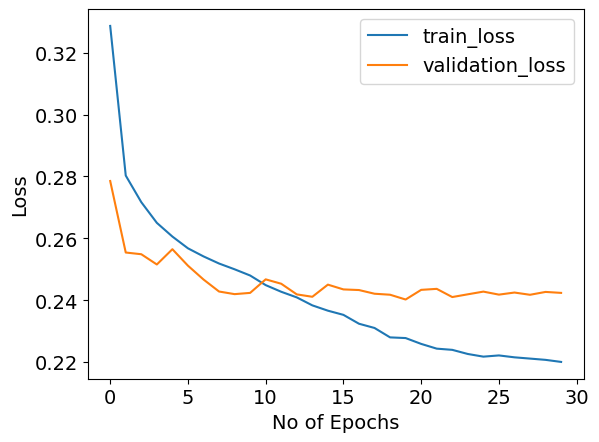

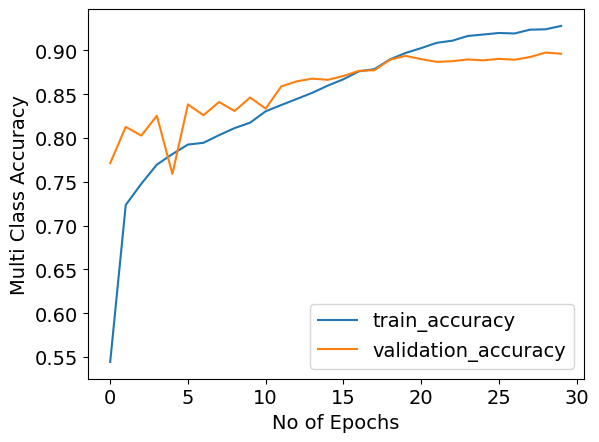

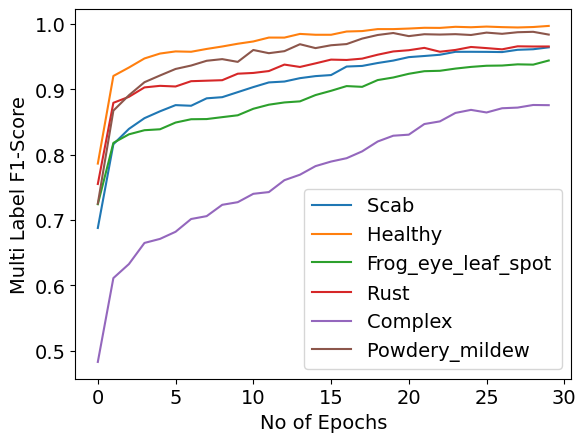

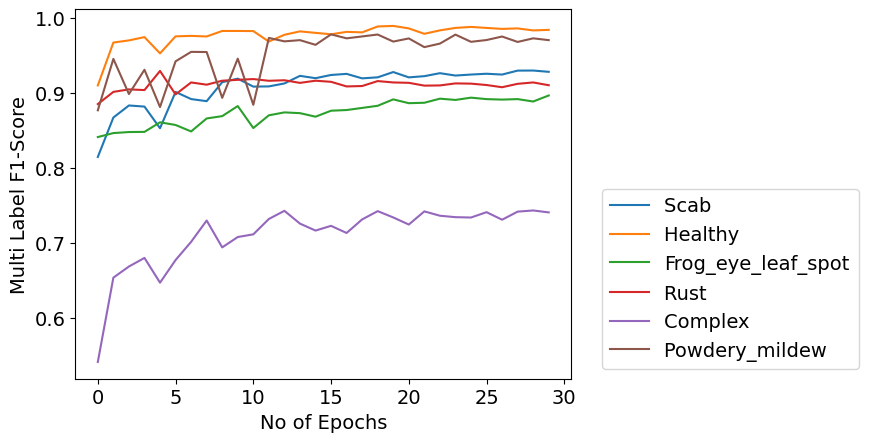

amount of images in train set: [3093 2955 2033 1182 1032  762  433  130  105   80   66   53]
amount of images in valid set: [774 738 509 296 257 190 108  33  27  20  17  13]
**********  fold no  ********************  2  ********************


  3%|██▋                                                                             | 1/30 [08:09<3:56:34, 489.48s/it]


----------------------------------------------------------------------------------------
Epoch : 1 Train_loss:0.327 Validation_loss:0.261 Duration:0:08:09.482726 Lr: 0.0001 Train_Acc:54.64 Validation_Acc:79.31
class ac : [64.27416747 68.52791878 57.79636006 61.08291032  1.93986421 59.58005249
 10.16166282 27.69230769 27.35849057 10.         17.91044776  5.66037736]
class ac : [96.63555345 94.15961507 87.40627882 87.56205185  0.39550704 89.15145005
  8.50340136 49.47433519 39.24646782  0.         63.7755102   7.84929356]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.8205689277899344 0.5965400676078744 0.690846286701209
Healthy            0.9015228426395939 0.6997635933806147 0.7879325643300799
Frog_eye_leaf_spot 0.8572969086987778 0.6477457903313416 0.7379331683168316
Rust               0.7592174567343868 0.7359591539022611 0.7474074074074074
Complex            0.5630857966834896 0.4395047833427124 0.49367888748419

  7%|█████▎                                                                          | 2/30 [16:18<3:48:25, 489.49s/it]


----------------------------------------------------------------------------------------
Epoch : 2 Train_loss:0.279 Validation_loss:0.250 Duration:0:08:09.500999 Lr: 9.964516155915151e-05 Train_Acc:71.80 Validation_Acc:81.26
class ac : [83.41416101 89.17089679 79.0949336  79.357022    3.29776916 81.1023622
  5.77367206 42.30769231 34.90566038  6.25       32.8358209   9.43396226]
class ac : [97.03106049 98.16934904 91.41574115 82.04633205  4.74608448 91.83673469
  5.66893424 55.65862709 58.86970173  5.10204082 44.64285714 31.39717425]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.8944201312910285 0.7590529247910863 0.8211953792064289
Healthy            0.9698815566835871 0.8692750985744616 0.9168266154830454
Frog_eye_leaf_spot 0.9248741912293315 0.7414985590778098 0.8230966090850927
Rust               0.9119638826185101 0.8352860096485183 0.8719424460431655
Complex            0.7130497476568133 0.5331536388140161 0

 10%|████████                                                                        | 3/30 [24:28<3:40:16, 489.51s/it]


----------------------------------------------------------------------------------------
Epoch : 3 Train_loss:0.270 Validation_loss:0.252 Duration:0:08:09.534270 Lr: 9.858624225078841e-05 Train_Acc:75.05 Validation_Acc:78.11
class ac : [87.03524087 91.7428088  85.24348254 82.91032149  3.39476237 82.80839895
  5.31177829 47.69230769 27.35849057  8.75       49.25373134 26.41509434]
class ac : [99.93144545 91.2560146  78.78593481 77.9095422   7.11912672 92.37379162
  2.83446712 77.30364873 51.02040816  0.         57.39795918 39.24646782]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.912199124726477 0.7953732411161459 0.849789782137852
Healthy            0.9725888324873097 0.9020715630885122 0.9360039081582804
Frog_eye_leaf_spot 0.9266714593817398 0.7472463768115942 0.8273427471116817
Rust               0.9337848006019563 0.8373819163292847 0.8829598007826396
Complex            0.7577505407354002 0.5620320855614973 0.

 13%|██████████▋                                                                     | 4/30 [32:37<3:32:06, 489.48s/it]


----------------------------------------------------------------------------------------
Epoch : 4 Train_loss:0.264 Validation_loss:0.253 Duration:0:08:09.436943 Lr: 9.683994186497132e-05 Train_Acc:76.91 Validation_Acc:79.65
class ac : [89.33074685 93.40101523 84.84997541 83.50253807  8.43840931 86.48293963
  5.54272517 52.30769231 33.96226415  5.         56.71641791 39.62264151]
class ac : [100.06328113  83.37481334  93.82141855  82.04633205   7.11912672
  98.28141783   7.55857899  71.11935683  51.02040816   0.
  51.02040816  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9195842450765864 0.8079788512376832 0.8601765383139311
Healthy            0.977326565143824 0.915953060577228 0.945645055664702
Frog_eye_leaf_spot 0.9396117900790798 0.7616550116550117 0.8413260379787576
Rust               0.945071482317532 0.8561690524880708 0.8984263233190272
Complex            0.7786589762076424 0.5720338983050848

 17%|█████████████▎                                                                  | 5/30 [40:47<3:23:53, 489.34s/it]


----------------------------------------------------------------------------------------
Epoch : 5 Train_loss:0.259 Validation_loss:0.244 Duration:0:08:09.099110 Lr: 9.443380060197387e-05 Train_Acc:77.94 Validation_Acc:83.76
class ac : [91.04429357 93.84094755 86.22725037 85.19458545  7.66246363 88.45144357
  4.38799076 60.76923077 36.79245283  8.75       41.79104478 37.73584906]
class ac : [100.59062385  95.68054864  93.82141855  87.90678434  11.07419712
  99.35553169   9.44822373  64.93506494  43.1711146    0.
  44.64285714  54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9288840262582057 0.8159538683325325 0.8687643898695319
Healthy            0.9766497461928934 0.9297680412371134 0.9526324475986137
Frog_eye_leaf_spot 0.9421279654924515 0.7619186046511628 0.8424943747990999
Rust               0.9488337095560572 0.8531799729364006 0.8984681154257214
Complex            0.7901946647440519 0.583599574014

 20%|████████████████                                                                | 6/30 [48:55<3:15:40, 489.19s/it]


----------------------------------------------------------------------------------------
Epoch : 6 Train_loss:0.257 Validation_loss:0.244 Duration:0:08:08.887203 Lr: 9.140576474687265e-05 Train_Acc:78.99 Validation_Acc:85.68
class ac : [91.59392176 94.34856176 88.34235121 85.53299492  9.02036857 89.76377953
  5.08083141 60.76923077 37.73584906 11.25       61.19402985 43.39622642]
class ac : [98.21758161 96.09534871 92.41810673 96.52509653 32.82708432 97.20730397
  7.55857899 37.10575139 74.56828885  0.         57.39795918 78.49293564]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9310722100656456 0.8222222222222222 0.8732683427398666
Healthy            0.9827411167512691 0.9346636626971355 0.9580996370834708
Frog_eye_leaf_spot 0.9442846872753414 0.7690281030444965 0.8476928041303646
Rust               0.9510910458991723 0.8610354223433242 0.903825527350733
Complex            0.8118240807498197 0.6106290672451193 0

 23%|██████████████████▋                                                             | 7/30 [57:04<3:07:29, 489.10s/it]


----------------------------------------------------------------------------------------
Epoch : 7 Train_loss:0.254 Validation_loss:0.244 Duration:0:08:08.907890 Lr: 8.780358823396353e-05 Train_Acc:79.04 Validation_Acc:83.21
class ac : [91.88490139 94.72081218 87.89965568 85.27918782 10.28128031 88.84514436
  4.84988453 56.15384615 34.90566038  7.5        64.17910448 50.94339623]
class ac : [100.45878817  95.95708202  85.80249389  88.25151682  21.35738016
  95.05907626   5.66893424  77.30364873  51.02040816   5.10204082
  51.02040816  54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9310722100656456 0.8280223789832157 0.8765289043388695
Healthy            0.9851099830795262 0.9375201288244767 0.9607260726072607
Frog_eye_leaf_spot 0.9464414090582315 0.7741840635107321 0.851690118065664
Rust               0.9571106094808126 0.8606224627875507 0.9063056644104026
Complex            0.8211968276856525 0.59415

 27%|████████████████████▊                                                         | 8/30 [1:05:13<2:59:19, 489.05s/it]


----------------------------------------------------------------------------------------
Epoch : 8 Train_loss:0.251 Validation_loss:0.241 Duration:0:08:08.950385 Lr: 8.368407953869104e-05 Train_Acc:80.55 Validation_Acc:85.54
class ac : [93.04881992 95.90524535 89.5228726  87.14043993 14.54898157 88.97637795
  6.00461894 61.53846154 33.96226415  7.5        52.23880597 60.37735849]
class ac : [99.53593841 98.03108235 90.8143218  91.6988417  26.10346464 98.81847476
 17.95162509 49.47433519 58.86970173 10.20408163 44.64285714 54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.936816192560175 0.8398724865129966 0.8856995086630463
Healthy            0.9878172588832488 0.9449660084169634 0.9659166115155526
Frog_eye_leaf_spot 0.9507548526240115 0.7850994360344316 0.8600227605267436
Rust               0.9563581640331076 0.8681693989071039 0.9101324740422485
Complex            0.8392213410237923 0.6110236220472441 0

 30%|███████████████████████▍                                                      | 9/30 [1:13:22<2:51:09, 489.03s/it]


----------------------------------------------------------------------------------------
Epoch : 9 Train_loss:0.249 Validation_loss:0.250 Duration:0:08:08.973073 Lr: 7.911220577405484e-05 Train_Acc:81.64 Validation_Acc:84.55
class ac : [94.08341416 96.24365482 90.06394491 87.30964467 17.36178468 91.73228346
 11.08545035 63.07692308 33.01886792 11.25       59.70149254 49.05660377]
class ac : [99.00859569 91.94734804 98.63277335 89.97517926 30.05853504 99.89258861
  2.83446712 30.92145949 62.79434851 10.20408163 25.51020408 31.39717425]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9442013129102844 0.8421566235667236 0.8902643455834945
Healthy            0.9878172588832488 0.9529872673849168 0.9700897308075773
Frog_eye_leaf_spot 0.9475197699496765 0.7949336550060314 0.8645457527058051
Rust               0.9601203912716328 0.8633288227334236 0.9091556822230139
Complex            0.8449891852919971 0.6345425013535463 

 33%|█████████████████████████▋                                                   | 10/30 [1:21:31<2:43:00, 489.01s/it]


----------------------------------------------------------------------------------------
Epoch : 10 Train_loss:0.247 Validation_loss:0.244 Duration:0:08:08.969085 Lr: 7.416006812042827e-05 Train_Acc:82.10 Validation_Acc:86.43
class ac : [93.72777239 96.24365482 90.85095917 87.98646362 20.07759457 92.12598425
 12.00923788 64.61538462 31.13207547 12.5        64.17910448 54.71698113]
class ac : [97.95391025 99.82854931 91.61621427 96.18036404 35.99114064 96.67024705
  8.50340136 46.38218924 43.1711146  10.20408163 57.39795918 54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9488512035010941 0.8506620892594409 0.8970778381174037
Healthy            0.990186125211506 0.9540267362243234 0.9717701760212554
Frog_eye_leaf_spot 0.9503953989935299 0.7961457392351702 0.8664591184663281
Rust               0.964635063957863 0.8673883626522327 0.9134307089419309
Complex            0.8507570295602018 0.6441048034934498 0

 37%|████████████████████████████▏                                                | 11/30 [1:29:40<2:34:50, 488.97s/it]


----------------------------------------------------------------------------------------
Epoch : 11 Train_loss:0.244 Validation_loss:0.243 Duration:0:08:08.887536 Lr: 6.890576474687263e-05 Train_Acc:82.99 Validation_Acc:87.49
class ac : [94.85935984 96.37901861 91.78553861 88.49407783 24.15130941 92.38845144
  9.93071594 65.38461538 30.18867925 12.5        61.19402985 71.69811321]
class ac : [ 98.34941729 100.10508268 100.43703139  90.66464424  32.43157728
  96.67024705  17.00680272  37.10575139  51.02040816  10.20408163
  57.39795918  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9452954048140044 0.8571428571428571 0.899063475546306
Healthy            0.9895093062605753 0.9583743035070469 0.9736929736929737
Frog_eye_leaf_spot 0.9525521207764198 0.8111417202326293 0.8761778806414283
Rust               0.964635063957863 0.8841379310344828 0.9226340410219503
Complex            0.8565248738284066 0.64285

 40%|██████████████████████████████▊                                              | 12/30 [1:37:49<2:26:41, 488.95s/it]


----------------------------------------------------------------------------------------
Epoch : 12 Train_loss:0.243 Validation_loss:0.240 Duration:0:08:08.902336 Lr: 6.343215915635762e-05 Train_Acc:83.30 Validation_Acc:85.75
class ac : [94.98868413 97.05583756 91.2936547  88.74788494 25.50921435 92.51968504
 12.9330254  60.         31.13207547 21.25       55.2238806  62.26415094]
class ac : [99.79960977 96.78668215 94.4228379  86.1831219  32.03607024 96.13319012
 19.84126984 49.47433519 58.86970173 10.20408163 44.64285714 47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9504923413566739 0.8652888446215139 0.9058915537017727
Healthy            0.9895093062605753 0.9608938547486033 0.9749916638879627
Frog_eye_leaf_spot 0.9521926671459382 0.807868252516011 0.8741131826431282
Rust               0.9668924003009782 0.8862068965517241 0.9247930910399424
Complex            0.8658976207642394 0.6502436383324309 

 43%|█████████████████████████████████▎                                           | 13/30 [1:45:58<2:18:33, 489.00s/it]


----------------------------------------------------------------------------------------
Epoch : 13 Train_loss:0.241 Validation_loss:0.239 Duration:0:08:09.118772 Lr: 5.782557337881911e-05 Train_Acc:84.34 Validation_Acc:87.18
class ac : [95.60297446 96.95431472 92.32661092 89.34010152 29.19495635 94.22572178
 18.2448037  57.69230769 36.79245283 18.75       61.19402985 64.1509434 ]
class ac : [96.37188209 99.82854931 97.63040776 86.1831219  43.90128144 97.7443609
 13.22751323 37.10575139 74.56828885 10.20408163 51.02040816 70.64364207]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9551422319474836 0.8714749188919391 0.9113924050632911
Healthy            0.990186125211506 0.9656765676567657 0.9777777777777777
Frog_eye_leaf_spot 0.9525521207764198 0.819672131147541 0.8811305070656692
Rust               0.9668924003009782 0.8880442294402211 0.9257925072046109
Complex            0.8622927180966113 0.668903803131991 0.7

 47%|███████████████████████████████████▉                                         | 14/30 [1:54:07<2:10:23, 488.99s/it]


----------------------------------------------------------------------------------------
Epoch : 14 Train_loss:0.237 Validation_loss:0.241 Duration:0:08:08.979960 Lr: 5.2174426621180906e-05 Train_Acc:85.16 Validation_Acc:88.59
class ac : [95.76462981 97.96954315 93.6055091  90.10152284 31.91076625 94.22572178
 18.01385681 53.84615385 33.96226415 25.         62.68656716 69.81132075]
class ac : [ 97.82207457 101.07294951  99.23419269  94.11196911  41.92374624
  95.59613319  17.00680272  46.38218924  58.86970173  15.30612245
  38.26530612  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9589715536105032 0.8820125786163522 0.9188835015070109
Healthy            0.9949238578680203 0.9738323948327261 0.9842651489789086
Frog_eye_leaf_spot 0.9601006470165349 0.8236201048411964 0.8866390041493776
Rust               0.9781790820165538 0.8940852819807428 0.9342436219906576
Complex            0.8759913482335977 0.67

 50%|██████████████████████████████████████▌                                      | 15/30 [2:02:16<2:02:14, 488.99s/it]


----------------------------------------------------------------------------------------
Epoch : 15 Train_loss:0.236 Validation_loss:0.240 Duration:0:08:08.991321 Lr: 4.65678408436424e-05 Train_Acc:85.69 Validation_Acc:89.07
class ac : [95.3443259  97.69881557 93.85145106 89.08629442 36.85741998 95.40682415
 20.55427252 66.92307692 33.01886792 22.5        68.65671642 75.47169811]
class ac : [ 99.00859569 100.65814944  98.63277335  87.90678434  52.99794336
  96.67024705  18.89644747  37.10575139  54.94505495  10.20408163
  51.02040816  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.962253829321663 0.8810418231905836 0.9198588050725585
Healthy            0.9969543147208122 0.9703557312252964 0.9834752128192289
Frog_eye_leaf_spot 0.9579439252336449 0.8406940063091483 0.895497311827957
Rust               0.9789315274642588 0.8910958904109589 0.9329508784510577
Complex            0.8882480173035328 0.680662

 53%|█████████████████████████████████████████                                    | 16/30 [2:10:25<1:54:05, 488.94s/it]


----------------------------------------------------------------------------------------
Epoch : 16 Train_loss:0.234 Validation_loss:0.240 Duration:0:08:08.798813 Lr: 4.109423525312738e-05 Train_Acc:86.66 Validation_Acc:88.35
class ac : [97.15486583 98.44331641 94.14658141 90.60913706 37.34238603 94.35695538
 26.09699769 58.46153846 38.67924528 23.75       64.17910448 73.58490566]
class ac : [ 97.95391025 100.79641613 100.03608516  94.4567016   29.26752096
  98.28141783  33.06878307  43.29004329  58.86970173  20.40816327
  44.64285714  31.39717425]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.963074398249453 0.895017793594306 0.9277997364953887
Healthy            0.9952622673434857 0.9790279627163782 0.9870783688538345
Frog_eye_leaf_spot 0.9586628324946082 0.8410596026490066 0.8960188140433395
Rust               0.9796839729119639 0.8973121984838043 0.9366906474820144
Complex            0.8918529199711608 0.70324

 57%|███████████████████████████████████████████▋                                 | 17/30 [2:18:34<1:45:56, 488.98s/it]


----------------------------------------------------------------------------------------
Epoch : 17 Train_loss:0.232 Validation_loss:0.240 Duration:0:08:09.084967 Lr: 3.583993187957173e-05 Train_Acc:87.56 Validation_Acc:89.38
class ac : [97.1871969  98.71404399 94.44171176 90.77834179 42.77400582 95.14435696
 31.63972286 58.46153846 35.8490566  38.75       56.71641791 73.58490566]
class ac : [ 97.69023889 101.34948288  99.43466581  94.80143409  45.08780256
  95.05907626  31.17913832  34.01360544  54.94505495  20.40816327
  38.26530612  54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9636214442013129 0.9005623721881391 0.9310253699788583
Healthy            0.9976311336717428 0.9816849816849816 0.9895938234306815
Frog_eye_leaf_spot 0.9601006470165349 0.8503661254377587 0.9019078169846362
Rust               0.9736644093303235 0.9004871259568545 0.935647143890094
Complex            0.9062725306416727 0.7253

 60%|██████████████████████████████████████████████▏                              | 18/30 [2:26:43<1:37:48, 489.01s/it]


----------------------------------------------------------------------------------------
Epoch : 18 Train_loss:0.230 Validation_loss:0.238 Duration:0:08:09.064312 Lr: 3.088779422594514e-05 Train_Acc:88.42 Validation_Acc:89.99
class ac : [97.5105076  98.78172589 94.93359567 90.94754653 47.72065955 96.7191601
 31.87066975 67.69230769 40.56603774 35.         61.19402985 69.81132075]
class ac : [100.72245953 100.38161606  99.63513893  94.80143409  39.94621104
  96.13319012  41.57218443  24.73716759  66.71899529  20.40816327
  51.02040816  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9660831509846827 0.9047131147540983 0.9343915343915344
Healthy            0.9966159052453468 0.9826493159826493 0.9895833333333334
Frog_eye_leaf_spot 0.9651329978432782 0.8625120462576293 0.910941475826972
Rust               0.9766741911211437 0.9096005606166784 0.941944847605225
Complex            0.9062725306416727 0.732517

 63%|████████████████████████████████████████████████▊                            | 19/30 [2:34:52<1:29:38, 488.95s/it]


----------------------------------------------------------------------------------------
Epoch : 19 Train_loss:0.228 Validation_loss:0.240 Duration:0:08:08.812273 Lr: 2.631592046130896e-05 Train_Acc:89.14 Validation_Acc:89.48
class ac : [97.31652118 98.44331641 95.27791441 91.96277496 50.72744908 97.11286089
 38.56812933 68.46153846 50.         36.25       70.14925373 73.58490566]
class ac : [ 98.87676001 101.07294951  99.63513893  93.42250414  40.34171808
  95.05907626  48.18594104  24.73716759  47.09576138  15.30612245
  38.26530612  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9682713347921226 0.9161490683229814 0.9414893617021277
Healthy            0.9969543147208122 0.982982982982983 0.9899193548387096
Frog_eye_leaf_spot 0.9626168224299065 0.8697629100357259 0.9138372291417847
Rust               0.9781790820165538 0.9180790960451978 0.9471766848816029
Complex            0.9286229271809661 0.7572

 67%|███████████████████████████████████████████████████▎                         | 20/30 [2:43:01<1:21:29, 488.90s/it]


----------------------------------------------------------------------------------------
Epoch : 20 Train_loss:0.226 Validation_loss:0.236 Duration:0:08:08.663620 Lr: 2.2196411766036492e-05 Train_Acc:90.05 Validation_Acc:89.96
class ac : [98.12479793 99.2893401  95.81898672 90.77834179 54.6071775  96.8503937
 42.72517321 66.15384615 46.22641509 47.5        71.64179104 79.24528302]
class ac : [100.32695249 100.24334937  97.22946153  92.04357419  47.06533776
  97.7443609   45.35147392  30.92145949  54.94505495  15.30612245
  44.64285714  54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9745623632385121 0.9271402550091075 0.9502600346712895
Healthy            0.9979695431472081 0.9902619207521827 0.9941007921793359
Frog_eye_leaf_spot 0.9676491732566499 0.8866930171277997 0.9254039188724648
Rust               0.9811888638073739 0.9163738580463809 0.9476744186046512
Complex            0.9156452775775054 0.760

 70%|█████████████████████████████████████████████████████▉                       | 21/30 [2:51:09<1:13:19, 488.80s/it]


----------------------------------------------------------------------------------------
Epoch : 21 Train_loss:0.226 Validation_loss:0.238 Duration:0:08:08.562844 Lr: 1.859423525312737e-05 Train_Acc:90.16 Validation_Acc:89.68
class ac : [97.99547365 98.95093063 95.03197245 92.30118443 56.4500485  97.24409449
 43.41801386 66.92307692 48.11320755 45.         67.1641791  81.13207547]
class ac : [100.06328113 100.93468282  99.83561204  94.4567016   37.96867584
  96.13319012  44.40665155  34.01360544  39.24646782  20.40816327
  38.26530612  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9707330415754923 0.9230169050715215 0.9462738301559792
Healthy            0.9966159052453468 0.9869302949061662 0.9917494527698266
Frog_eye_leaf_spot 0.9662113587347232 0.8850839644385907 0.9238700807698917
Rust               0.981941309255079 0.9301496792587313 0.9553440702781845
Complex            0.9307858687815429 0.7735

 73%|████████████████████████████████████████████████████████▍                    | 22/30 [2:59:18<1:05:10, 488.77s/it]


----------------------------------------------------------------------------------------
Epoch : 22 Train_loss:0.224 Validation_loss:0.236 Duration:0:08:08.708760 Lr: 1.556619939802614e-05 Train_Acc:91.14 Validation_Acc:89.75
class ac : [98.09246686 99.12013536 95.52385637 93.7394247  60.81474297 96.9816273
 49.19168591 71.53846154 49.05660377 50.         68.65671642 84.90566038]
class ac : [100.19511681 100.51988275  97.42993465  92.73303916  42.71476032
  97.7443609   47.24111867  34.01360544  39.24646782  25.51020408
  51.02040816  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9778446389496718 0.9302628155087171 0.9534604613948526
Healthy            0.9976311336717428 0.9872739450770261 0.9924255175896314
Frog_eye_leaf_spot 0.9716031631919483 0.8959231024196221 0.9322296947749612
Rust               0.9804364183596689 0.9274021352313168 0.9531821506949525
Complex            0.923576063446287 0.78685

 77%|████████████████████████████████████████████████████████████▌                  | 23/30 [3:07:26<57:00, 488.70s/it]


----------------------------------------------------------------------------------------
Epoch : 23 Train_loss:0.224 Validation_loss:0.237 Duration:0:08:08.398333 Lr: 1.316005813502869e-05 Train_Acc:91.00 Validation_Acc:90.09
class ac : [97.8338183  99.12013536 95.96655189 92.55499154 59.35984481 97.76902887
 50.11547344 70.76923077 52.83018868 47.5        73.13432836 81.13207547]
class ac : [100.32695249 100.65814944  98.83324646  90.66464424  50.62490112
  96.67024705  41.57218443  27.82931354  43.1711146   15.30612245
  38.26530612  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.975656455142232 0.9330368820298195 0.9538708383473726
Healthy            0.9966159052453468 0.9879235155987923 0.9922506738544474
Frog_eye_leaf_spot 0.9701653486700216 0.892526455026455 0.9297278677230452
Rust               0.9811888638073739 0.9222065063649222 0.9507838133430551
Complex            0.9329488103821196 0.79240

 80%|███████████████████████████████████████████████████████████████▏               | 24/30 [3:15:35<48:51, 488.54s/it]


----------------------------------------------------------------------------------------
Epoch : 24 Train_loss:0.222 Validation_loss:0.239 Duration:0:08:08.173001 Lr: 1.1413757749211607e-05 Train_Acc:91.88 Validation_Acc:89.72
class ac : [98.57743291 98.98477157 96.75356616 92.89340102 64.59747818 96.9816273
 51.73210162 78.46153846 51.88679245 52.5        68.65671642 83.01886792]
class ac : [ 99.79960977 100.93468282  98.23182711  91.00937672  42.31925328
  95.59613319  59.52380952  30.92145949  27.47252747  15.30612245
  38.26530612  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9808533916849015 0.9360480292351866 0.95792707359423
Healthy            0.9976311336717428 0.9909243697478992 0.9942664418212479
Frog_eye_leaf_spot 0.9744787922358016 0.9085120643431636 0.9403399236906
Rust               0.9811888638073739 0.9320943531093638 0.9560117302052786
Complex            0.9437635183850036 0.80603448

 83%|█████████████████████████████████████████████████████████████████▊             | 25/30 [3:23:43<40:42, 488.45s/it]


----------------------------------------------------------------------------------------
Epoch : 25 Train_loss:0.221 Validation_loss:0.237 Duration:0:08:08.102985 Lr: 1.0354838440848501e-05 Train_Acc:92.36 Validation_Acc:90.51
class ac : [98.4804397  99.45854484 96.80275455 93.40101523 66.53734239 97.90026247
 55.65819861 73.84615385 51.88679245 50.         73.13432836 83.01886792]
class ac : [ 99.79960977 100.93468282  98.43230023  94.11196911  47.4608448
  96.13319012  49.13076342  37.10575139  47.09576138  20.40816327
  51.02040816  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9805798687089715 0.9441664471951541 0.9620287132698242
Healthy            0.9993231810490694 0.991272239006378 0.9952814290529154
Frog_eye_leaf_spot 0.9755571531272466 0.9098223265169293 0.9415437987857762
Rust               0.9826937547027841 0.939568345323741 0.9606472968002943
Complex            0.9416005767844268 0.81574

 87%|████████████████████████████████████████████████████████████████████▍          | 26/30 [3:31:51<32:33, 488.34s/it]


----------------------------------------------------------------------------------------
Epoch : 26 Train_loss:0.220 Validation_loss:0.238 Duration:0:08:08.094829 Lr: 1e-05 Train_Acc:92.48 Validation_Acc:90.13
class ac : [98.28645328 99.42470389 96.70437777 93.31641286 65.95538312 98.03149606
 56.81293303 75.38461538 54.71698113 61.25       82.08955224 90.56603774]
class ac : [100.19511681 101.07294951  97.83088088  91.6988417   47.06533776
  95.59613319  48.18594104  37.10575139  43.1711146   15.30612245
  44.64285714  54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9803063457330415 0.9476467477525119 0.963699919333154
Healthy            0.9979695431472081 0.9899295065458208 0.993933265925177
Frog_eye_leaf_spot 0.9755571531272466 0.9144204851752021 0.944
Rust               0.9879608728367193 0.9331911869225302 0.9597953216374269
Complex            0.9480894015861572 0.8147459727385378 0.876374541819393

 90%|███████████████████████████████████████████████████████████████████████        | 27/30 [3:39:59<24:24, 488.32s/it]


----------------------------------------------------------------------------------------
Epoch : 27 Train_loss:0.220 Validation_loss:0.238 Duration:0:08:08.115164 Lr: 1e-05 Train_Acc:92.52 Validation_Acc:90.71
class ac : [98.54510184 99.39086294 96.60600098 92.97800338 68.18622696 97.63779528
 57.73672055 81.53846154 49.05660377 51.25       70.14925373 79.24528302]
class ac : [ 99.93144545 101.07294951  98.83324646  92.04357419  52.60243632
  96.13319012  48.18594104  27.82931354  35.32182104  25.51020408
  51.02040816  54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9819474835886215 0.9437434279705573 0.9624664879356568
Healthy            0.9986463620981387 0.9936026936026936 0.9961181434599156
Frog_eye_leaf_spot 0.9762760603882099 0.9150943396226415 0.944695652173913
Rust               0.9834462001504891 0.9355762347888332 0.9589141599413059
Complex            0.9423215573179524 0.817385866166354 0.87

 93%|█████████████████████████████████████████████████████████████████████████▋     | 28/30 [3:50:22<17:37, 528.64s/it]


----------------------------------------------------------------------------------------
Epoch : 28 Train_loss:0.220 Validation_loss:0.238 Duration:0:10:22.712609 Lr: 1e-05 Train_Acc:92.70 Validation_Acc:90.33
class ac : [98.54510184 99.45854484 96.90113133 92.89340102 67.6042677  98.03149606
 58.89145497 73.07692308 50.94339623 62.5        79.10447761 92.45283019]
class ac : [ 99.27226705 101.21121619  97.83088088  94.80143409  48.25185888
  95.59613319  46.2962963   30.92145949  54.94505495  20.40816327
  51.02040816  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9816739606126915 0.9462167150013182 0.9636192777554035
Healthy            0.9986463620981387 0.9929340511440108 0.9957820145098701
Frog_eye_leaf_spot 0.97411933860532 0.9118438761776582 0.9419534237052485
Rust               0.9887133182844243 0.9392423159399571 0.9633431085043989
Complex            0.9444844989185291 0.8233815210559396 0.87

 97%|████████████████████████████████████████████████████████████████████████████▎  | 29/30 [4:00:02<09:04, 544.11s/it]


----------------------------------------------------------------------------------------
Epoch : 29 Train_loss:0.220 Validation_loss:0.238 Duration:0:09:40.205355 Lr: 1e-05 Train_Acc:92.59 Validation_Acc:90.64
class ac : [98.54510184 99.39086294 96.55681259 93.23181049 67.79825412 97.50656168
 57.50577367 75.38461538 56.60377358 60.         77.6119403  79.24528302]
class ac : [ 99.40410273 101.21121619  98.031354    92.38830667  54.18446448
  95.59613319  47.24111867  30.92145949  51.02040816  15.30612245
  44.64285714  54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9833150984682714 0.9468001053463261 0.9647121964309674
Healthy            0.9972927241962775 0.9892581403155422 0.9932591843613077
Frog_eye_leaf_spot 0.9777138749101366 0.9155166610568832 0.9455936033373892
Rust               0.9857035364936042 0.9417685118619699 0.9632352941176471
Complex            0.9459264599855803 0.823086574654956 0.8

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [4:08:32<00:00, 497.09s/it]


----------------------------------------------------------------------------------------
Epoch : 30 Train_loss:0.219 Validation_loss:0.237 Duration:0:08:30.081399 Lr: 1e-05 Train_Acc:93.20 Validation_Acc:90.40
class ac : [98.41577756 99.18781726 96.75356616 93.7394247  72.55092144 97.50656168
 62.12471132 70.         53.77358491 65.         83.58208955 90.56603774]
class ac : [100.19511681 100.93468282  97.02898841  90.66464424  53.3934504
  95.59613319  49.13076342  30.92145949  47.09576138  20.40816327
  31.8877551   62.79434851]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9805798687089715 0.9471598414795245 0.9635801639564575
Healthy            0.9983079526226735 0.9892689470154259 0.9937678962438943
Frog_eye_leaf_spot 0.9777138749101366 0.9280109177755033 0.9522142482058463
Rust               0.9872084273890143 0.9418521177315147 0.9639970609845702
Complex            0.9531362653208363 0.8356510745891277 0.8

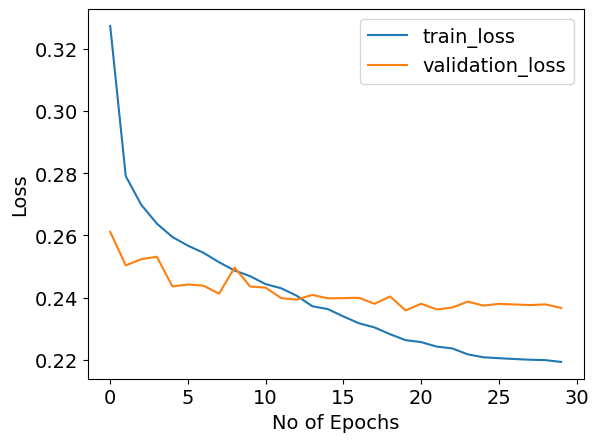

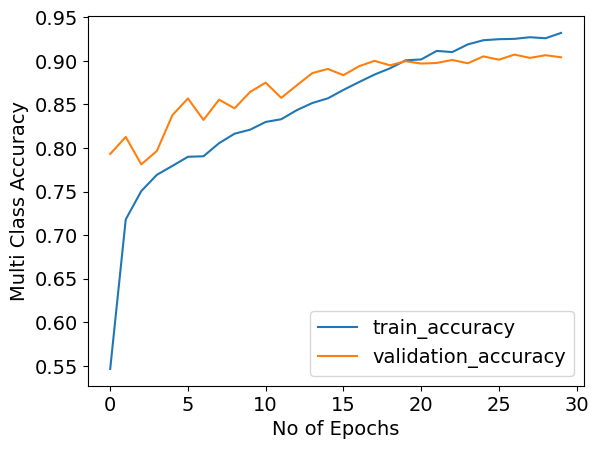

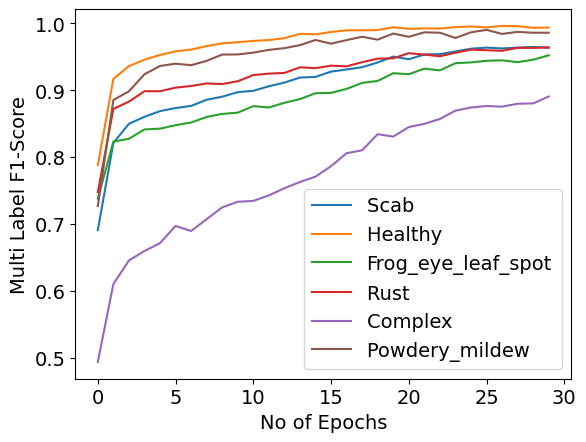

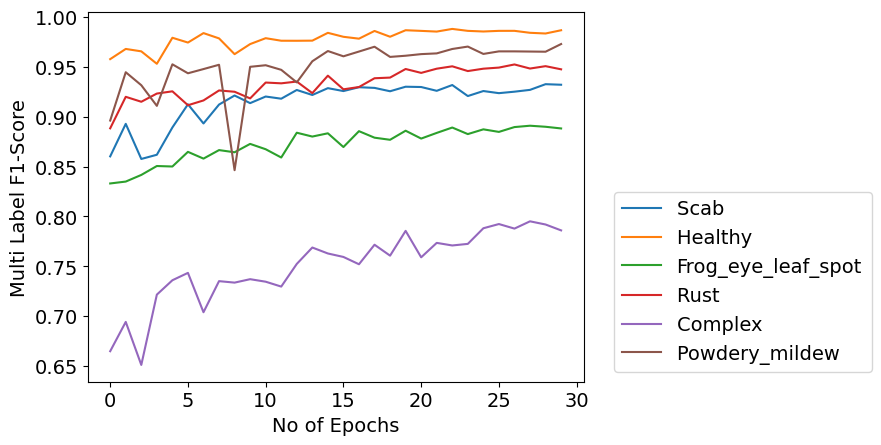

amount of images in train set: [3093 2955 2033 1182 1031  762  433  130  106   80   67   53]
amount of images in valid set: [774 738 509 296 258 190 108  33  26  20  16  13]
**********  fold no  ********************  3  ********************


  3%|██▋                                                                             | 1/30 [08:23<4:03:16, 503.32s/it]


----------------------------------------------------------------------------------------
Epoch : 1 Train_loss:0.332 Validation_loss:0.268 Duration:0:08:23.323044 Lr: 0.0001 Train_Acc:53.19 Validation_Acc:77.09
class ac : [62.12023271 67.70480704 58.84955752 56.5143824   3.10378274 52.09973753
  5.32407407 30.76923077 37.73584906 11.25       20.89552239  1.88679245]
class ac : [85.93605618 99.00306537 87.57833842 86.52785438  2.76854928 85.39205156
  0.93615428 12.3685838  58.86970173  5.10204082 51.02040816 15.69858713]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.8159190371991247 0.593277645186953 0.6870105941962229
Healthy            0.8784698713608666 0.6803880440482433 0.7668439716312057
Frog_eye_leaf_spot 0.8267433501078361 0.6255099265705738 0.712184548691748
Rust               0.745673438675696 0.7165582067968185 0.7308259587020649
Complex            0.5674116798846431 0.43966480446927375 0.495435945860875

  7%|█████▎                                                                          | 2/30 [18:31<4:23:35, 564.85s/it]


----------------------------------------------------------------------------------------
Epoch : 2 Train_loss:0.280 Validation_loss:0.254 Duration:0:10:07.901327 Lr: 9.964516155915151e-05 Train_Acc:71.56 Validation_Acc:78.80
class ac : [83.54880414 88.59174001 79.40019666 80.37225042  2.71580989 77.55905512
  4.86111111 40.76923077 36.79245283  3.75       28.35820896 22.64150943]
class ac : [95.17649233 98.17458783 83.96271895 76.18587976  5.9326056  93.98496241
  1.87230856 21.64502165 70.64364207  0.         57.39795918 39.24646782]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.8916849015317286 0.7558543936934848 0.8181704103400678
Healthy            0.9624238320920785 0.8654490106544901 0.9113640006411284
Frog_eye_leaf_spot 0.9270309130122214 0.7372784448256147 0.8213375796178344
Rust               0.9217456734386757 0.8483379501385041 0.8835196538045438
Complex            0.7058399423215573 0.5235294117647059 

 10%|████████                                                                        | 3/30 [27:17<4:06:12, 547.14s/it]


----------------------------------------------------------------------------------------
Epoch : 3 Train_loss:0.269 Validation_loss:0.259 Duration:0:08:46.068046 Lr: 9.858624225078841e-05 Train_Acc:75.22 Validation_Acc:78.83
class ac : [88.49385908 91.09681787 84.02163225 82.74111675  5.04364694 83.85826772
  5.55555556 46.92307692 36.79245283  3.75       40.29850746 16.98113208]
class ac : [99.00467302 88.37093701 79.94536397 90.31991175 13.44723936 97.7443609
  1.87230856 43.29004329 39.24646782  0.         51.02040816 23.54788069]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9067286652078774 0.7892857142857143 0.8439409368635438
Healthy            0.9712254570074476 0.8999372647427855 0.9342233800065125
Frog_eye_leaf_spot 0.9352983465132998 0.7520231213872832 0.8337071451457866
Rust               0.9390519187358917 0.8559670781893004 0.8955866523143164
Complex            0.7498197548666186 0.5646036916395223 0

 13%|██████████▋                                                                     | 4/30 [36:01<3:53:11, 538.13s/it]


----------------------------------------------------------------------------------------
Epoch : 4 Train_loss:0.264 Validation_loss:0.255 Duration:0:08:44.314105 Lr: 9.683994186497132e-05 Train_Acc:76.73 Validation_Acc:79.55
class ac : [89.43115708 93.12796209 85.29990167 84.7715736   6.01357905 85.82677165
  5.32407407 60.         32.0754717   6.25       35.82089552 28.30188679]
class ac : [94.91247987 96.103394   83.15924795 79.28847215 17.40230976 96.67024705
  0.         37.10575139 58.86970173  0.         44.64285714 54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9269693654266958 0.8055621583075826 0.8620119547246597
Healthy            0.976303317535545 0.9167196439923713 0.9455737704918032
Frog_eye_leaf_spot 0.9374550682961897 0.7531042448743863 0.8352281825460368
Rust               0.9503386004514672 0.8528021607022283 0.898932384341637
Complex            0.7656813266041816 0.5728155339805825 0.

 17%|█████████████▎                                                                  | 5/30 [44:19<3:38:06, 523.47s/it]


----------------------------------------------------------------------------------------
Epoch : 5 Train_loss:0.259 Validation_loss:0.249 Duration:0:08:17.473285 Lr: 9.443380060197387e-05 Train_Acc:78.60 Validation_Acc:79.07
class ac : [90.40077569 94.31279621 87.75811209 86.04060914  8.63239573 89.76377953
  6.94444444 60.76923077 39.62264151  8.75       56.71641791 35.8490566 ]
class ac : [98.21263564 95.27491646 77.33408324 79.63320463 12.26071824 91.83673469
  3.74461711 71.11935683 39.24646782  0.         70.15306122 78.49293564]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9299781181619255 0.8216529724504592 0.8724659994867847
Healthy            0.981042654028436 0.9297401347449471 0.9547026848954043
Frog_eye_leaf_spot 0.9435657800143782 0.7688927943760984 0.8473208521626856
Rust               0.9556057185854026 0.8645336963921034 0.9077912794853467
Complex            0.8053352559480894 0.5941489361702128 0

 20%|████████████████                                                                | 6/30 [52:35<3:25:39, 514.16s/it]


----------------------------------------------------------------------------------------
Epoch : 6 Train_loss:0.257 Validation_loss:0.250 Duration:0:08:16.102439 Lr: 9.140576474687265e-05 Train_Acc:79.36 Validation_Acc:80.44
class ac : [91.72592114 94.17738659 89.03638151 86.71742809 11.93016489 88.45144357
  7.63888889 63.07692308 34.90566038  1.25       56.71641791 37.73584906]
class ac : [97.42059825 98.31266742 91.1939579  66.18863762 11.07419712 95.05907626
  2.80846283 43.29004329 62.79434851  0.         63.7755102  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9349015317286652 0.8250060342746802 0.8765226311065522
Healthy            0.9783344617467841 0.9295593438404631 0.9533234372422893
Frog_eye_leaf_spot 0.9367361610352265 0.7762883526958594 0.8489982081772276
Rust               0.9525959367945824 0.86652977412731 0.9075268817204301
Complex            0.8067772170151406 0.6045380875202593 0.

 23%|██████████████████▏                                                           | 7/30 [1:01:09<3:17:03, 514.08s/it]


----------------------------------------------------------------------------------------
Epoch : 7 Train_loss:0.253 Validation_loss:0.250 Duration:0:08:33.916022 Lr: 8.780358823396353e-05 Train_Acc:80.15 Validation_Acc:81.26
class ac : [92.50161603 94.98984428 89.47885939 86.04060914 13.77303589 90.41994751
 10.18518519 58.46153846 42.45283019  5.         44.7761194  43.39622642]
class ac : [99.13667925 91.40868797 91.99742889 68.60176503 31.24505616 97.20730397
  2.80846283 34.01360544 43.1711146   0.         63.7755102  70.64364207]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.936542669584245 0.8423124231242313 0.8869317445926693
Healthy            0.9827352742044685 0.9419208306294614 0.961895294897283
Frog_eye_leaf_spot 0.9464414090582315 0.7799170616113744 0.855147775251705
Rust               0.9623777276147479 0.8636056718433491 0.9103202846975089
Complex            0.8211968276856525 0.615343057806591 0.70

 27%|████████████████████▊                                                         | 8/30 [1:09:22<3:06:02, 507.39s/it]


----------------------------------------------------------------------------------------
Epoch : 8 Train_loss:0.252 Validation_loss:0.247 Duration:0:08:13.069803 Lr: 8.368407953869104e-05 Train_Acc:80.58 Validation_Acc:81.50
class ac : [93.21266968 95.05754909 89.13470993 86.54822335 17.07080504 89.63254593
  9.49074074 63.07692308 39.62264151  7.5        44.7761194  39.62264151]
class ac : [96.7605671  96.79379194 91.79656114 74.80694981 21.7528872  93.98496241
  1.87230856 34.01360544 51.02040816  0.         76.53061224 39.24646782]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9411925601750547 0.8419378517249817 0.8888027896164278
Healthy            0.984427894380501 0.9438493995456021 0.9637116818558409
Frog_eye_leaf_spot 0.9475197699496765 0.7828927828927829 0.8573751829565783
Rust               0.9586155003762227 0.8684389911383776 0.9113018597997139
Complex            0.8356164383561644 0.6211146838156485 0

 30%|███████████████████████▍                                                      | 9/30 [1:17:35<2:56:00, 502.87s/it]


----------------------------------------------------------------------------------------
Epoch : 9 Train_loss:0.249 Validation_loss:0.248 Duration:0:08:12.913887 Lr: 7.911220577405484e-05 Train_Acc:81.40 Validation_Acc:83.39
class ac : [93.85908209 96.1746784  89.77384464 88.15566836 17.84675073 89.89501312
 11.11111111 57.69230769 34.90566038 10.         49.25373134 45.28301887]
class ac : [97.55260448 98.72690619 95.41218062 73.42801986 31.24505616 93.44790548
  1.87230856 30.92145949 39.24646782  0.         63.7755102  70.64364207]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9483041575492341 0.8514243614931237 0.897256728778468
Healthy            0.9867975626269465 0.9544859201047806 0.9703728362183754
Frog_eye_leaf_spot 0.9414090582314881 0.7836624775583483 0.8553233180927499
Rust               0.9661399548532731 0.8782489740082079 0.9201003224650662
Complex            0.8428262436914203 0.6305285868392665 0

 33%|█████████████████████████▋                                                   | 10/30 [1:26:39<2:51:52, 515.61s/it]


----------------------------------------------------------------------------------------
Epoch : 10 Train_loss:0.247 Validation_loss:0.248 Duration:0:09:04.138871 Lr: 7.416006812042827e-05 Train_Acc:82.53 Validation_Acc:83.52
class ac : [94.86102133 96.41164523 90.90462144 89.17089679 22.30843841 92.38845144
  9.49074074 65.38461538 34.90566038  6.25       44.7761194  45.28301887]
class ac : [ 91.87633656 100.10770208  95.81391612  85.14892443  25.31245056
 100.42964554   1.87230856  30.92145949  51.02040816   0.
  70.15306122  62.79434851]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9485776805251641 0.8541871921182266 0.8989113530326595
Healthy            0.9874746106973595 0.9554536521454308 0.971200266355918
Frog_eye_leaf_spot 0.9442846872753414 0.7989659367396593 0.8655683690280066
Rust               0.9714070729872084 0.8788291354663036 0.9228020014295926
Complex            0.8442682047584715 0.639192139737

 37%|████████████████████████████▏                                                | 11/30 [1:36:25<2:50:10, 537.37s/it]


----------------------------------------------------------------------------------------
Epoch : 11 Train_loss:0.245 Validation_loss:0.248 Duration:0:09:46.716079 Lr: 6.890576474687263e-05 Train_Acc:82.93 Validation_Acc:84.79
class ac : [94.44085326 96.44549763 91.54375615 89.42470389 23.47235694 92.91338583
 13.88888889 66.15384615 32.0754717  10.         46.26865672 56.60377358]
class ac : [ 95.17649233 100.10770208  93.00176764  83.425262    41.13273216
  98.81847476   3.74461711  21.64502165  35.32182104   0.
  57.39795918  70.64364207]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9515864332603938 0.8590123456790123 0.9029327796522191
Healthy            0.9874746106973595 0.9579638752052545 0.9724954159026504
Frog_eye_leaf_spot 0.9503953989935299 0.8009694032111482 0.8693079072825908
Rust               0.963882618510158 0.8889659958362248 0.9249097472924188
Complex            0.859408795962509 0.6492374727668

 40%|██████████████████████████████▊                                              | 12/30 [1:44:38<2:37:09, 523.84s/it]


----------------------------------------------------------------------------------------
Epoch : 12 Train_loss:0.242 Validation_loss:0.253 Duration:0:08:12.883182 Lr: 6.343215915635762e-05 Train_Acc:83.98 Validation_Acc:83.35
class ac : [95.57207498 96.88557888 92.4287119  89.17089679 26.28516004 92.91338583
 15.50925926 66.92307692 43.39622642 17.5        56.71641791 58.49056604]
class ac : [ 95.83652348 100.38386126  95.21131287  67.22283508  30.84954912
  99.89258861   6.55307995  27.82931354  62.79434851   5.10204082
  57.39795918  54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9556892778993435 0.872191712431353 0.912033411641869
Healthy            0.991198375084631 0.9644268774703557 0.9776293823038398
Frog_eye_leaf_spot 0.9500359453630481 0.8102391171060699 0.8745863666446062
Rust               0.9676448457486833 0.8820301783264746 0.9228561176892717
Complex            0.8615717375630858 0.664997

 43%|█████████████████████████████████▎                                           | 13/30 [1:52:48<2:25:30, 513.55s/it]


----------------------------------------------------------------------------------------
Epoch : 13 Train_loss:0.241 Validation_loss:0.248 Duration:0:08:09.875603 Lr: 5.782557337881911e-05 Train_Acc:84.38 Validation_Acc:85.61
class ac : [95.53975436 97.19025051 92.4287119  89.00169205 30.45586809 93.17585302
 17.82407407 68.46153846 40.56603774 13.75       44.7761194  54.71698113]
class ac : [ 96.49655464 100.38386126  94.20697413  85.49365692  37.5731688
  98.28141783   3.74461711  24.73716759  62.79434851   5.10204082
  63.7755102   70.64364207]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9573304157549234 0.8798391151332328 0.9169504846738276
Healthy            0.992552471225457 0.9657444005270093 0.9789649415692822
Frog_eye_leaf_spot 0.9496764917325665 0.81719764924219 0.8784704904405652
Rust               0.9676448457486833 0.8980446927374302 0.931546541108294
Complex            0.8702235039653929 0.66136986

 47%|███████████████████████████████████▉                                         | 14/30 [2:00:58<2:15:00, 506.26s/it]


----------------------------------------------------------------------------------------
Epoch : 14 Train_loss:0.238 Validation_loss:0.248 Duration:0:08:09.286419 Lr: 5.2174426621180906e-05 Train_Acc:85.19 Validation_Acc:84.89
class ac : [96.05688429 97.52877454 93.46116028 89.08629442 34.82056256 93.96325459
 17.82407407 58.46153846 32.0754717  17.5        56.71641791 71.69811321]
class ac : [ 95.17649233 100.93617961  95.41218062  86.1831219   25.31245056
  94.52201933  17.78693129  40.19789734  51.02040816  10.20408163
  51.02040816  62.79434851]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9573304157549234 0.8840616317251832 0.9192383453709784
Healthy            0.9922139471902505 0.9695666556400926 0.9807595783838046
Frog_eye_leaf_spot 0.9521926671459382 0.8306679209783632 0.8872885613800033
Rust               0.9751693002257337 0.9012517385257302 0.9367546078785689
Complex            0.8745493871665465 0.67

 50%|██████████████████████████████████████▌                                      | 15/30 [2:09:07<2:05:17, 501.15s/it]


----------------------------------------------------------------------------------------
Epoch : 15 Train_loss:0.236 Validation_loss:0.248 Duration:0:08:09.314201 Lr: 4.65678408436424e-05 Train_Acc:86.26 Validation_Acc:86.40
class ac : [95.95992243 97.79959377 93.31366765 90.60913706 39.08826382 95.14435696
 23.84259259 70.76923077 38.67924528 27.5        58.20895522 66.03773585]
class ac : [97.28859202 99.27922455 98.02346135 87.21731936 28.08099984 97.7443609
 34.63770829 30.92145949 39.24646782 10.20408163 57.39795918 47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9633479212253829 0.8878245525586085 0.9240456513183786
Healthy            0.993906567366283 0.971542025148908 0.9825970548862115
Frog_eye_leaf_spot 0.9593817397555715 0.84301958307012 0.8974445191661062
Rust               0.9691497366440933 0.8950660180681028 0.930635838150289
Complex            0.8853640951694304 0.691830985915493 0.77672

 53%|█████████████████████████████████████████                                    | 16/30 [2:17:17<1:56:07, 497.68s/it]


----------------------------------------------------------------------------------------
Epoch : 16 Train_loss:0.234 Validation_loss:0.245 Duration:0:08:09.503876 Lr: 4.109423525312738e-05 Train_Acc:87.19 Validation_Acc:86.98
class ac : [97.02650291 98.51049425 93.90363815 90.94754653 41.41610087 95.53805774
 29.86111111 62.30769231 37.73584906 23.75       59.70149254 69.81132075]
class ac : [ 97.28859202 100.38386126  99.22866785  87.21731936  29.663028
  98.28141783  27.14847407  37.10575139  47.09576138  10.20408163
  57.39795918  62.79434851]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9606126914660832 0.8966045442941026 0.9275056120427836
Healthy            0.9962762356127285 0.9787163285666778 0.9874182184197282
Frog_eye_leaf_spot 0.9626168224299065 0.846129541864139 0.9006221624348411
Rust               0.9736644093303235 0.9042627533193571 0.9376811594202898
Complex            0.8954578226387887 0.713383

 57%|███████████████████████████████████████████▋                                 | 17/30 [2:25:26<1:47:19, 495.31s/it]


----------------------------------------------------------------------------------------
Epoch : 17 Train_loss:0.232 Validation_loss:0.245 Duration:0:08:09.654520 Lr: 3.583993187957173e-05 Train_Acc:87.92 Validation_Acc:87.77
class ac : [97.25274725 98.13811781 94.10029499 91.96277496 46.2657614  95.80052493
 31.71296296 67.69230769 34.90566038 27.5        67.1641791  75.47169811]
class ac : [ 98.74066056 100.38386126  96.21565161  91.00937672  34.01360544
  97.20730397  32.76539974  40.19789734  35.32182104  25.51020408
  51.02040816  70.64364207]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9666301969365426 0.9066187788609543 0.9356632247815727
Healthy            0.9935680433310765 0.9799666110183639 0.9867204572197008
Frog_eye_leaf_spot 0.9557872034507549 0.8602394047233904 0.9054997445939043
Rust               0.9789315274642588 0.9085195530726257 0.942412169503803
Complex            0.9156452775775054 0.7228

 60%|██████████████████████████████████████████████▏                              | 18/30 [2:33:36<1:38:42, 493.58s/it]


----------------------------------------------------------------------------------------
Epoch : 18 Train_loss:0.230 Validation_loss:0.248 Duration:0:08:09.543911 Lr: 3.088779422594514e-05 Train_Acc:88.96 Validation_Acc:86.16
class ac : [97.60827408 98.54434665 95.23107178 92.1319797  50.33947624 95.80052493
 35.18518519 71.53846154 49.05660377 30.         67.1641791  67.9245283 ]
class ac : [ 97.55260448 100.79810002  88.18094167  85.14892443  35.5956336
  98.28141783  38.38232541  52.56648114  43.1711146   15.30612245
  51.02040816  70.64364207]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9723741794310722 0.915057915057915 0.9428457764222252
Healthy            0.9942450914014895 0.9826028772164603 0.9883897021706209
Frog_eye_leaf_spot 0.9654924514737598 0.869537067011978 0.915005961505706
Rust               0.9826937547027841 0.9236209335219236 0.9522420707254831
Complex            0.9005046863734679 0.7377436

 63%|████████████████████████████████████████████████▊                            | 19/30 [2:41:45<1:30:15, 492.33s/it]


----------------------------------------------------------------------------------------
Epoch : 19 Train_loss:0.228 Validation_loss:0.248 Duration:0:08:09.408940 Lr: 2.631592046130896e-05 Train_Acc:89.37 Validation_Acc:87.18
class ac : [98.02844215 98.95057549 95.08357915 92.04737733 51.30940834 96.58792651
 40.97222222 63.84615385 45.28301887 27.5        61.19402985 81.13207547]
class ac : [ 97.15658579 100.52194085  94.20697413  87.21731936  33.6180984
  97.7443609   49.61617675  37.10575139  47.09576138  10.20408163
  38.26530612  70.64364207]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.975382932166302 0.9157678479712378 0.944635761589404
Healthy            0.9976303317535545 0.9879316124706671 0.9927572848239852
Frog_eye_leaf_spot 0.9651329978432782 0.8709049626986701 0.9156010230179028
Rust               0.9826937547027841 0.9190710767065446 0.9498181818181818
Complex            0.9077144917087239 0.744970

 67%|███████████████████████████████████████████████████▎                         | 20/30 [2:49:55<1:21:55, 491.60s/it]


----------------------------------------------------------------------------------------
Epoch : 20 Train_loss:0.226 Validation_loss:0.247 Duration:0:08:09.901319 Lr: 2.2196411766036492e-05 Train_Acc:90.21 Validation_Acc:87.56
class ac : [97.86683904 98.88287068 96.11602753 93.31641286 55.77109602 96.9816273
 41.2037037  68.46153846 51.88679245 32.5        68.65671642 79.24528302]
class ac : [ 98.74066056 100.38386126  93.20263538  89.28571429  32.43157728
  96.67024705  49.61617675  43.29004329  47.09576138  10.20408163
  51.02040816  70.64364207]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9726477024070022 0.9253187613843351 0.9483931190825443
Healthy            0.9969532836831415 0.988255033557047 0.9925851027974385
Frog_eye_leaf_spot 0.9654924514737598 0.8838433695294505 0.9228654870297199
Rust               0.9804364183596689 0.923458540042523 0.9510948905109489
Complex            0.9221341023792358 0.76724

 70%|█████████████████████████████████████████████████████▉                       | 21/30 [2:58:05<1:13:39, 491.00s/it]


----------------------------------------------------------------------------------------
Epoch : 21 Train_loss:0.225 Validation_loss:0.249 Duration:0:08:09.461169 Lr: 1.859423525312737e-05 Train_Acc:90.75 Validation_Acc:88.07
class ac : [98.15772463 99.11983751 95.62438545 92.63959391 57.4199806  97.24409449
 48.61111111 67.69230769 54.71698113 38.75       73.13432836 90.56603774]
class ac : [ 99.00467302 100.79810002  92.39916439  86.52785438  41.92374624
  97.7443609   50.55233102  43.29004329  31.39717425  20.40816327
  44.64285714  54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9781181619256017 0.930039011703511 0.9534728702839621
Healthy            0.9962762356127285 0.9885791064830366 0.992412746585736
Frog_eye_leaf_spot 0.9698058950395398 0.8869165023011177 0.926510989010989
Rust               0.9811888638073739 0.9254790631653655 0.9525200876552228
Complex            0.9257390050468637 0.785321

 73%|████████████████████████████████████████████████████████▍                    | 22/30 [3:06:14<1:05:24, 490.52s/it]


----------------------------------------------------------------------------------------
Epoch : 22 Train_loss:0.224 Validation_loss:0.250 Duration:0:08:09.236435 Lr: 1.556619939802614e-05 Train_Acc:91.40 Validation_Acc:88.86
class ac : [98.44861021 99.25524712 95.77187807 92.97800338 61.49369544 97.76902887
 52.5462963  73.84615385 46.22641509 41.25       68.65671642 83.01886792]
class ac : [ 99.26868548 100.79810002  98.02346135  91.35410921  32.43157728
  97.7443609   52.42463958  37.10575139  39.24646782  20.40816327
  44.64285714  62.79434851]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9816739606126915 0.9356100104275287 0.9580886278697277
Healthy            0.997291807718348 0.9899193548387096 0.9935919055649242
Frog_eye_leaf_spot 0.9708842559309849 0.896746347941567 0.9323438039351053
Rust               0.9811888638073739 0.9314285714285714 0.955661414437523
Complex            0.9271809661139149 0.791871

 77%|████████████████████████████████████████████████████████████▌                  | 23/30 [3:14:24<57:11, 490.16s/it]


----------------------------------------------------------------------------------------
Epoch : 23 Train_loss:0.223 Validation_loss:0.249 Duration:0:08:09.335735 Lr: 1.316005813502869e-05 Train_Acc:91.52 Validation_Acc:88.07
class ac : [98.31932773 99.11983751 96.55850541 93.57021997 61.29970902 97.24409449
 52.5462963  67.69230769 53.77358491 47.5        71.64179104 81.13207547]
class ac : [ 97.81661694 100.79810002  93.80523863  86.1831219   43.90128144
  97.20730397  51.4884853   27.82931354  43.1711146   20.40816327
  44.64285714  54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9792122538293216 0.930595269040811 0.9542849526855924
Healthy            0.9976303317535545 0.9889261744966443 0.9932591843613077
Frog_eye_leaf_spot 0.9723220704529115 0.9010659560293138 0.9353388658367912
Rust               0.9811888638073739 0.9354375896700143 0.9577671685640837
Complex            0.9315068493150684 0.7970

 80%|███████████████████████████████████████████████████████████████▏               | 24/30 [3:22:33<48:59, 489.91s/it]


----------------------------------------------------------------------------------------
Epoch : 24 Train_loss:0.222 Validation_loss:0.249 Duration:0:08:09.340172 Lr: 1.1413757749211607e-05 Train_Acc:91.61 Validation_Acc:88.11
class ac : [98.35164835 99.22139472 95.67354966 94.07783418 62.85160039 96.8503937
 52.08333333 76.92307692 51.88679245 47.5        68.65671642 79.24528302]
class ac : [ 98.21263564 100.79810002  95.01044512  87.21731936  38.75968992
  96.13319012  49.61617675  40.19789734  47.09576138  20.40816327
  44.64285714  62.79434851]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9814004376367614 0.9382845188284519 0.9593582887700535
Healthy            0.997968855788761 0.9892617449664429 0.9935962251432423
Frog_eye_leaf_spot 0.9723220704529115 0.9043798060849214 0.9371210808938161
Rust               0.9841986455981941 0.9336188436830836 0.9582417582417583
Complex            0.9329488103821196 0.7972

 83%|█████████████████████████████████████████████████████████████████▊             | 25/30 [3:31:08<41:27, 497.43s/it]


----------------------------------------------------------------------------------------
Epoch : 25 Train_loss:0.221 Validation_loss:0.248 Duration:0:08:34.954592 Lr: 1.0354838440848501e-05 Train_Acc:92.13 Validation_Acc:88.42
class ac : [98.64253394 99.22139472 96.90265487 93.57021997 63.62754607 97.24409449
 56.71296296 68.46153846 56.60377358 47.5        77.6119403  86.79245283]
class ac : [ 97.55260448 100.93617961  95.81391612  88.9409818   43.11026736
  96.67024705  45.87155963  40.19789734  39.24646782  20.40816327
  38.26530612  54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9803063457330415 0.9401888772298006 0.9598286020353508
Healthy            0.997968855788761 0.9925925925925926 0.9952734638757597
Frog_eye_leaf_spot 0.97411933860532 0.9060514877967235 0.9388532825220856
Rust               0.9826937547027841 0.9375448671931084 0.9595885378398237
Complex            0.9416005767844268 0.81017

 87%|████████████████████████████████████████████████████████████████████▍          | 26/30 [3:40:36<34:34, 518.62s/it]


----------------------------------------------------------------------------------------
Epoch : 26 Train_loss:0.221 Validation_loss:0.249 Duration:0:09:28.070329 Lr: 1e-05 Train_Acc:92.28 Validation_Acc:88.01
class ac : [98.31932773 99.39065674 96.5093412  94.33164129 67.11930165 98.81889764
 56.01851852 66.15384615 49.05660377 42.5        68.65671642 81.13207547]
class ac : [ 98.34464187 100.79810002  92.80089989  85.49365692  47.4608448
  96.13319012  43.0630968   40.19789734  35.32182104  15.30612245
  51.02040816  62.79434851]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9789387308533917 0.9408517350157729 0.9595174262734585
Healthy            0.9983073798239676 0.9912605042016807 0.9947714623039299
Frog_eye_leaf_spot 0.9730409777138749 0.914527027027027 0.9428770463253222
Rust               0.9872084273890143 0.9384835479256081 0.9622295562889622
Complex            0.9286229271809661 0.8110831234256927 0.86

 90%|███████████████████████████████████████████████████████████████████████        | 27/30 [3:50:04<26:40, 533.61s/it]


----------------------------------------------------------------------------------------
Epoch : 27 Train_loss:0.220 Validation_loss:0.247 Duration:0:09:28.427868 Lr: 1e-05 Train_Acc:92.27 Validation_Acc:89.07
class ac : [98.54557207 99.32295193 96.65683382 94.67005076 66.6343356  96.9816273
 56.94444444 67.69230769 46.22641509 46.25       70.14925373 79.24528302]
class ac : [ 99.40069171 100.66002044  95.21131287  89.63044677  47.4608448
  98.28141783  43.0630968   37.10575139  35.32182104  15.30612245
  44.64285714  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9835886214442013 0.9421011265391669 0.9623979660109728
Healthy            0.9969532836831415 0.9909152086137282 0.9939250759365508
Frog_eye_leaf_spot 0.9737598849748382 0.9136593591905565 0.9427527405602923
Rust               0.9834462001504891 0.9409647228221742 0.9617365710080942
Complex            0.9322278298485941 0.8106583072100313 0.86

 93%|█████████████████████████████████████████████████████████████████████████▋     | 28/30 [3:59:33<18:08, 544.12s/it]


----------------------------------------------------------------------------------------
Epoch : 28 Train_loss:0.220 Validation_loss:0.247 Duration:0:09:28.651834 Lr: 1e-05 Train_Acc:92.48 Validation_Acc:88.90
class ac : [98.44861021 99.42450914 96.55850541 94.24703892 67.11930165 97.76902887
 58.7962963  68.46153846 51.88679245 47.5        73.13432836 84.90566038]
class ac : [ 99.13667925 100.52194085  94.20697413  88.9409818   49.04287296
  96.67024705  41.19078824  43.29004329  39.24646782  20.40816327
  51.02040816  54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9814004376367614 0.9422268907563025 0.9614147909967846
Healthy            0.997968855788761 0.9932614555256065 0.9956095913542722
Frog_eye_leaf_spot 0.9759166067577283 0.9113796576032226 0.9425446971011977
Rust               0.9864559819413092 0.9424874191229331 0.9639705882352941
Complex            0.9365537130497477 0.8180100755667506 0.8

 97%|████████████████████████████████████████████████████████████████████████████▎  | 29/30 [4:09:01<09:11, 551.23s/it]


----------------------------------------------------------------------------------------
Epoch : 29 Train_loss:0.220 Validation_loss:0.248 Duration:0:09:27.809394 Lr: 1e-05 Train_Acc:92.80 Validation_Acc:88.83
class ac : [98.70717518 99.35680433 96.75516224 94.50084602 68.38021339 97.90026247
 58.7962963  77.69230769 48.11320755 51.25       73.13432836 84.90566038]
class ac : [ 99.13667925 100.79810002  94.40784188  89.97517926  46.66983072
  97.7443609   42.12694252  30.92145949  35.32182104  15.30612245
  51.02040816  62.79434851]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9833150984682714 0.9393781029527045 0.9608445810503808
Healthy            0.9983073798239676 0.9922611036339165 0.9952750590617617
Frog_eye_leaf_spot 0.9791516894320632 0.9156302521008404 0.9463262115685253
Rust               0.9841986455981941 0.9444043321299639 0.9638909358879882
Complex            0.9416005767844268 0.8286802030456852 0.

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [4:18:29<00:00, 516.98s/it]


----------------------------------------------------------------------------------------
Epoch : 30 Train_loss:0.219 Validation_loss:0.249 Duration:0:09:27.951824 Lr: 1e-05 Train_Acc:93.15 Validation_Acc:89.24
class ac : [98.70717518 99.55991875 97.34513274 94.41624365 70.22308438 97.90026247
 59.25925926 70.         58.49056604 51.25       77.6119403  84.90566038]
class ac : [ 98.60865433 100.93617961  95.81391612  89.97517926  46.27432368
  98.81847476  49.61617675  34.01360544  39.24646782  15.30612245
  38.26530612  54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9835886214442013 0.9505683320116309 0.9667966124479097
Healthy            0.998645903859174 0.9936005389019872 0.9961168326861388
Frog_eye_leaf_spot 0.9780733285406182 0.9239388794567063 0.9502357255107386
Rust               0.9879608728367193 0.9418938307030129 0.9643775247888359
Complex            0.9387166546503244 0.8240506329113924 0.8

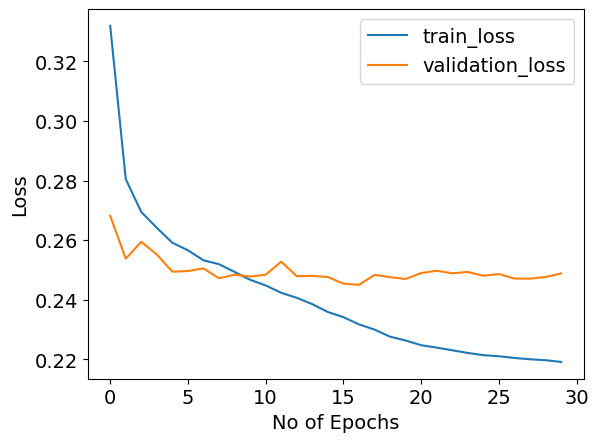

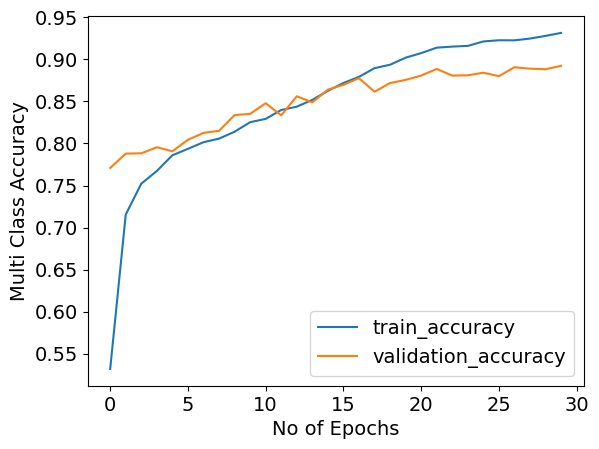

In [ ]:
batch_size = 20
splits=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
label_names = ['Scab              ','Healthy           ','Frog_eye_leaf_spot','Rust              ','Complex           ','Powdery_mildew    ']
for fold, (train_idx,val_idx) in enumerate(splits.split(df_train['image_id'],df_train['label'])):
  train_dl = DataLoader(pathology_train,batch_size=batch_size,sampler=train_idx,pin_memory=True)
  val_dl = DataLoader(pathology_val,batch_size=batch_size,sampler=val_idx,pin_memory=True)
  model = start_model(printchild=False)
  model.to(device)
  train_losses = []
  validation_losses = []
  train_accuracies = []
  validation_accuracies = []
  train_ml_f1 = []
  val_ml_f1 = []
  prev_accuracy = 0.84
  reducing_rate = 0.8
  smoothing_ratio = 0.2
  threshold_array = 0.25
  flag = 0
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
  scheduler1 = CosineAnnealingLR(optimizer,
                                 T_max=25,
                                 eta_min=1e-5)
  print('**********  fold no  ********************  {}  ********************'.format(fold+1))
  batch_gd(model=model,criterion=criterion,optimizer=optimizer,train_loader=train_dl,validation_loader=val_dl,epochs=30,foldd=fold+1)
  os.chdir('C:/Local Machine/plant-pathology-final-3/saves')
  torch.save(model, 'swinv2t'+str(fold+1)+'_chkpnt.pt')
  plt.plot(train_losses , label = 'train_loss')
  plt.plot(validation_losses , label = 'validation_loss')
  plt.xlabel('No of Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  plt.plot(train_accuracies , label = 'train_accuracy')
  plt.plot(validation_accuracies , label = 'validation_accuracy')
  plt.xlabel('No of Epochs')
  plt.ylabel('Multi Class Accuracy')
  plt.legend()
  plt.show()
  plt.plot(train_ml_f1 , label = label_names)
  plt.xlabel('No of Epochs')
  plt.ylabel('Multi Label F1-Score')
  plt.legend()
  plt.show()
  plt.plot(val_ml_f1 , label = label_names)
  plt.xlabel('No of Epochs')
  plt.ylabel('Multi Label F1-Score')
  plt.legend(loc = 'lower right',bbox_to_anchor=(1.6, 0.0))
  plt.show()
  print('amount of images in train set:', train_cm.sum(axis=1))
  print('amount of images in valid set:', validation_cm.sum(axis=1))

**********  fold no  ********************  4  ********************


  3%|██▋                                                                             | 1/30 [08:28<4:05:42, 508.36s/it]


----------------------------------------------------------------------------------------
Epoch : 1 Train_loss:0.329 Validation_loss:0.264 Duration:0:08:28.356388 Lr: 0.0001 Train_Acc:54.03 Validation_Acc:76.57
class ac : [61.08597285 68.11103588 59.8820059  64.15891801  1.16391853 60.05256242
  5.77367206 25.19083969 19.81132075  7.5        15.15151515  0.        ]
class ac : [92.14034902 95.13683687 82.15490921 79.55724663  1.18652112 89.75317876
  0.94482237 47.83163265 51.02040816  5.10204082 48.01920768 14.57725948]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.8127392017495899 0.5836277974087162 0.6793875685557587
Healthy            0.9113067027758971 0.6876117496807151 0.7838113262483623
Frog_eye_leaf_spot 0.8530890804597702 0.6526518274251167 0.7395298147283201
Rust               0.781790820165538 0.7448028673835125 0.762848751835536
Complex            0.5281385281385281 0.4144960362400906 0.464467005076142

  7%|█████▎                                                                          | 2/30 [17:48<4:11:35, 539.11s/it]


----------------------------------------------------------------------------------------
Epoch : 2 Train_loss:0.280 Validation_loss:0.256 Duration:0:09:20.637106 Lr: 9.964516155915151e-05 Train_Acc:72.40 Validation_Acc:78.28
class ac : [83.51648352 89.47190251 80.48180924 80.55790363  2.61881668 81.99737188
  6.69745958 51.90839695 29.24528302  8.75       30.3030303  21.15384615]
class ac : [93.59241756 99.8315429  74.92367026 84.05396057  8.30564784 94.02713965
  1.88964475 70.15306122 23.54788069  0.         54.02160864 21.86588921]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.8920174958993986 0.7614935822637107 0.8216039279869067
Healthy            0.9705484089370345 0.8701062215477997 0.9175868138902225
Frog_eye_leaf_spot 0.9249281609195402 0.7373997709049256 0.8205863607393244
Rust               0.9157261098570354 0.8335616438356165 0.8727142344926497
Complex            0.70995670995671 0.5391780821917809 0.

 10%|████████                                                                        | 3/30 [27:20<4:09:16, 553.95s/it]


----------------------------------------------------------------------------------------
Epoch : 3 Train_loss:0.270 Validation_loss:0.254 Duration:0:09:31.599990 Lr: 9.858624225078841e-05 Train_Acc:75.09 Validation_Acc:78.35
class ac : [87.13639302 91.90927556 82.44837758 85.79881657  4.75266731 83.96846255
  4.61893764 45.03816794 34.90566038  5.         48.48484848 23.07692308]
class ac : [ 90.29226179  95.68915523  85.97139643  77.48184019   8.70115488
 100.43808099   0.94482237  79.71938776  43.1711146    0.
  60.0240096   21.86588921]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9070530344450519 0.7890606420927467 0.8439526898130485
Healthy            0.975626269465132 0.899219968798752 0.9358662120474103
Frog_eye_leaf_spot 0.9292385057471264 0.7507254788160186 0.8304975922953451
Rust               0.945071482317532 0.854421768707483 0.8974633797784923
Complex            0.7402597402597403 0.5548945375878853

 13%|██████████▋                                                                     | 4/30 [36:52<4:03:05, 560.97s/it]


----------------------------------------------------------------------------------------
Epoch : 4 Train_loss:0.265 Validation_loss:0.256 Duration:0:09:31.749989 Lr: 9.683994186497132e-05 Train_Acc:76.43 Validation_Acc:78.35
class ac : [88.97866839 92.58632363 85.10324484 85.20710059  6.78952473 85.01971091
  5.54272517 48.09160305 32.0754717   5.         42.42424242 32.69230769]
class ac : [ 91.48031787  88.09477783  86.77486743  87.16707022  19.37984496
 100.9723261    0.94482237  54.20918367  15.69858713   0.
  66.02641056  21.86588921]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9114270092946966 0.8010571840461317 0.852685421994885
Healthy            0.977657413676371 0.9084617804340988 0.9417903146910158
Frog_eye_leaf_spot 0.9317528735632183 0.7547279604306081 0.8339495257997107
Rust               0.9465763732129421 0.8552005438477226 0.8985714285714286
Complex            0.7683982683982684 0.57629870129870

 17%|█████████████▎                                                                  | 5/30 [45:10<3:44:15, 538.21s/it]


----------------------------------------------------------------------------------------
Epoch : 5 Train_loss:0.261 Validation_loss:0.256 Duration:0:08:17.835716 Lr: 9.443380060197387e-05 Train_Acc:77.78 Validation_Acc:76.40
class ac : [90.49773756 93.63574814 86.0373648  84.95350803  9.50533463 86.07095926
  6.69745958 59.54198473 41.50943396  5.         48.48484848 26.92307692]
class ac : [92.40436149 90.02789208 82.35577696 69.18021446 17.40230976 94.02713965
  1.88964475 82.90816327 15.69858713  0.         60.0240096  58.3090379 ]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9261891744122471 0.8183574879227054 0.8689407540394973
Healthy            0.9779959377115776 0.9212372448979592 0.948768472906404
Frog_eye_leaf_spot 0.9349856321839081 0.7658134745513386 0.8419860908943878
Rust               0.9578630549285176 0.8537894030851777 0.9028368794326241
Complex            0.7727272727272727 0.5804878048780487 0

 20%|████████████████                                                                | 6/30 [53:20<3:28:46, 521.95s/it]


----------------------------------------------------------------------------------------
Epoch : 6 Train_loss:0.258 Validation_loss:0.253 Duration:0:08:10.396681 Lr: 9.140576474687265e-05 Train_Acc:78.45 Validation_Acc:80.48
class ac : [90.91790562 93.90656737 86.38151426 87.32037194 10.57225994 89.09329829
  6.69745958 52.67175573 32.0754717   7.5        50.         38.46153846]
class ac : [90.95229295 97.3461103  86.57399968 81.63265306 29.663028   93.49289454
  0.         44.64285714 31.39717425  0.         60.0240096  58.3090379 ]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9278294149808639 0.822389144657136 0.8719332048811818
Healthy            0.9793500338524035 0.9236909323116219 0.9507065395990798
Frog_eye_leaf_spot 0.9457614942528736 0.776009431181845 0.8525174032701959
Rust               0.9510910458991723 0.8575305291723202 0.9018908312522298
Complex            0.7806637806637806 0.5874049945711184 0.

 23%|██████████████████▏                                                           | 7/30 [1:01:31<3:16:09, 511.71s/it]


----------------------------------------------------------------------------------------
Epoch : 7 Train_loss:0.255 Validation_loss:0.245 Duration:0:08:10.624966 Lr: 8.780358823396353e-05 Train_Acc:79.50 Validation_Acc:84.41
class ac : [91.88752424 94.82058226 88.59390364 87.48943364 12.90009699 89.35611038
  4.61893764 56.48854962 35.8490566   3.75       50.         34.61538462]
class ac : [97.94862318 99.14114496 95.41218062 81.97855413 22.93940832 97.76685543
  9.44822373 54.20918367 27.47252747  5.10204082 66.02641056 51.02040816]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.931656642974303 0.831422298121493 0.878690215289416
Healthy            0.9817197020988491 0.9333762471837785 0.9569377990430622
Frog_eye_leaf_spot 0.9432471264367817 0.7764636309875813 0.8517677586766137
Rust               0.9548532731376975 0.8679890560875513 0.9093514869222501
Complex            0.8304473304473304 0.608994708994709 0.70

 27%|████████████████████▊                                                         | 8/30 [1:09:41<3:05:10, 505.01s/it]


----------------------------------------------------------------------------------------
Epoch : 8 Train_loss:0.253 Validation_loss:0.251 Duration:0:08:10.675512 Lr: 8.368407953869104e-05 Train_Acc:80.51 Validation_Acc:81.43
class ac : [92.72786037 95.1591063  89.42969518 88.33474218 16.39185257 90.0131406
  9.69976905 54.19847328 28.30188679 11.25       43.93939394 42.30769231]
class ac : [ 90.16025556  96.24147359  86.37313193  83.70805949  40.73722512
 100.43808099   1.88964475  31.8877551   27.47252747   5.10204082
  54.02160864  51.02040816]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9338436303991252 0.8347996089931574 0.8815483870967742
Healthy            0.9847664184157076 0.9429497568881685 0.9634045371750289
Frog_eye_leaf_spot 0.9432471264367817 0.7888254731150496 0.859152625552102
Rust               0.9541008276899925 0.8756906077348067 0.9132157003961109
Complex            0.8232323232323232 0.615426

 30%|███████████████████████▍                                                      | 9/30 [1:17:52<2:55:11, 500.53s/it]


----------------------------------------------------------------------------------------
Epoch : 9 Train_loss:0.251 Validation_loss:0.251 Duration:0:08:10.673926 Lr: 7.911220577405484e-05 Train_Acc:81.11 Validation_Acc:82.32
class ac : [92.95410472 95.59918754 90.46214356 89.09551986 16.48884578 91.06438896
  7.39030023 53.4351145  42.45283019 11.25       45.45454545 55.76923077]
class ac : [96.10053595 95.55107564 89.78788366 75.06053269 38.36418288 96.69836521
  3.77928949 44.64285714 27.47252747 10.20408163 48.01920768 58.3090379 ]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9332968835429196 0.8425468904244817 0.8856031128404669
Healthy            0.983750846310088 0.9422827496757458 0.9625703875455449
Frog_eye_leaf_spot 0.9436063218390804 0.7881788178817882 0.8589177701487657
Rust               0.9608728367193379 0.8752570253598355 0.9160688665710186
Complex            0.836940836940837 0.6304347826086957 0.

 33%|█████████████████████████▋                                                   | 10/30 [1:26:02<2:45:47, 497.38s/it]


----------------------------------------------------------------------------------------
Epoch : 10 Train_loss:0.248 Validation_loss:0.255 Duration:0:08:10.338947 Lr: 7.416006812042827e-05 Train_Acc:81.91 Validation_Acc:82.60
class ac : [94.21460892 96.07312119 90.56047198 88.41927303 19.59262852 91.19579501
 11.08545035 58.77862595 35.8490566   2.5        57.57575758 53.84615385]
class ac : [ 87.38812472 101.35041838  94.80957737  79.9031477   39.94621104
 102.04081633   1.88964475  12.75510204  19.62323391  10.20408163
  30.0120048   29.15451895]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9464188080918535 0.8514510575504181 0.8964267219057483
Healthy            0.9867975626269465 0.9535492312724894 0.9698885376809183
Frog_eye_leaf_spot 0.9461206896551724 0.7952898550724637 0.8641732283464567
Rust               0.9616252821670429 0.8807718814610613 0.9194244604316547
Complex            0.8383838383838383 0.632

 37%|████████████████████████████▏                                                | 11/30 [1:34:13<2:36:48, 495.20s/it]


----------------------------------------------------------------------------------------
Epoch : 11 Train_loss:0.246 Validation_loss:0.257 Duration:0:08:10.261307 Lr: 6.890576474687263e-05 Train_Acc:82.69 Validation_Acc:78.87
class ac : [94.11764706 95.97156398 91.8387414  89.01098901 24.44228904 91.4586071
 12.9330254  61.06870229 33.96226415  7.5        56.06060606 57.69230769]
class ac : [85.27602503 98.03650824 78.94102523 79.55724663 43.5057744  95.62987499
  1.88964475 35.07653061 19.62323391 10.20408163 48.01920768 58.3090379 ]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9455986878075451 0.8561881188118812 0.8986749805144193
Healthy            0.9881516587677726 0.9523654159869495 0.9699285595613889
Frog_eye_leaf_spot 0.947198275862069 0.8022512929723152 0.8687201449514084
Rust               0.963882618510158 0.8840579710144928 0.9222462203023758
Complex            0.8556998556998557 0.6470267321331151 0.

 40%|██████████████████████████████▊                                              | 12/30 [1:42:23<2:28:07, 493.74s/it]


----------------------------------------------------------------------------------------
Epoch : 12 Train_loss:0.244 Validation_loss:0.243 Duration:0:08:10.388312 Lr: 6.343215915635762e-05 Train_Acc:83.40 Validation_Acc:85.44
class ac : [94.66709761 96.58090724 92.23205506 89.9408284  25.60620757 91.85282523
 13.62586605 66.41221374 34.90566038 16.25       53.03030303 55.76923077]
class ac : [96.10053595 99.27922455 92.80089989 86.82116915 39.15519696 93.49289454
 17.00680272 51.02040816 31.39717425 10.20408163 54.02160864 65.59766764]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9480590486604702 0.8672168042010503 0.905837795481259
Healthy            0.991198375084631 0.957801766437684 0.9742139411079688
Frog_eye_leaf_spot 0.9489942528735632 0.8059792556436852 0.8716595183107885
Rust               0.9683972911963883 0.8881987577639752 0.9265658747300216
Complex            0.8434343434343434 0.6534376746785914 0.

 43%|█████████████████████████████████▎                                           | 13/30 [1:50:33<2:19:36, 492.74s/it]


----------------------------------------------------------------------------------------
Epoch : 13 Train_loss:0.242 Validation_loss:0.244 Duration:0:08:10.426529 Lr: 5.782557337881911e-05 Train_Acc:84.08 Validation_Acc:84.99
class ac : [95.4427925  97.25795531 92.03539823 89.43364328 29.58292919 92.37844941
 14.78060046 64.88549618 30.18867925 11.25       59.09090909 65.38461538]
class ac : [ 95.57251102  97.20803071  94.40784188  87.51297129  37.5731688
 100.9723261   12.28269085  44.64285714  19.62323391  10.20408163
  42.01680672  51.02040816]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9505194095133953 0.8725219573400251 0.9098521522962187
Healthy            0.991198375084631 0.9666556619346319 0.9787731907070032
Frog_eye_leaf_spot 0.947198275862069 0.8138888888888889 0.8754980079681275
Rust               0.9721595184349134 0.8947368421052632 0.9318427695636495
Complex            0.873015873015873 0.6558265

 47%|███████████████████████████████████▉                                         | 14/30 [1:58:44<2:11:12, 492.05s/it]


----------------------------------------------------------------------------------------
Epoch : 14 Train_loss:0.239 Validation_loss:0.241 Duration:0:08:10.445753 Lr: 5.2174426621180906e-05 Train_Acc:85.11 Validation_Acc:86.88
class ac : [95.73367809 97.39336493 93.6086529  89.51817413 32.58971872 93.16688568
 22.63279446 61.06870229 31.13207547 17.5        57.57575758 75.        ]
class ac : [ 96.49655464 100.93617961  96.01478387  89.58837772  40.34171808
  97.76685543  16.06198035  44.64285714  19.62323391  10.20408163
  48.01920768  58.3090379 ]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9579004920721705 0.8784156430183003 0.9164378187524519
Healthy            0.99322951929587 0.9689564068692206 0.9809428284854563
Frog_eye_leaf_spot 0.9558189655172413 0.8261409500155231 0.8862614487926728
Rust               0.9744168547780286 0.8993055555555556 0.9353557240881184
Complex            0.8708513708513709 0.6765

 50%|██████████████████████████████████████▌                                      | 15/30 [2:06:55<2:02:54, 491.60s/it]


----------------------------------------------------------------------------------------
Epoch : 15 Train_loss:0.238 Validation_loss:0.242 Duration:0:08:10.574890 Lr: 4.65678408436424e-05 Train_Acc:85.38 Validation_Acc:87.66
class ac : [95.95992243 97.49492214 92.92035398 90.61707523 35.11154219 93.03547963
 21.24711316 61.06870229 36.79245283 23.75       53.03030303 67.30769231]
class ac : [ 98.4766481  100.52194085  95.41218062  92.70148737  39.94621104
  99.90383588  17.95162509  44.64285714  27.47252747  10.20408163
  36.01440576  58.3090379 ]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9584472389283761 0.8833459309649786 0.9193654123508588
Healthy            0.9915368991198376 0.9698675496688741 0.9805825242718447
Frog_eye_leaf_spot 0.954382183908046 0.8285001559089492 0.886997162410282
Rust               0.9736644093303235 0.8979875086745316 0.9342960288808664
Complex            0.8961038961038961 0.689616

 53%|█████████████████████████████████████████                                    | 16/30 [2:15:05<1:54:39, 491.37s/it]


----------------------------------------------------------------------------------------
Epoch : 16 Train_loss:0.235 Validation_loss:0.242 Duration:0:08:10.806991 Lr: 4.109423525312738e-05 Train_Acc:86.48 Validation_Acc:88.07
class ac : [96.7032967  98.23967502 93.90363815 91.12426036 35.88748788 94.74375821
 27.02078522 66.41221374 37.73584906 20.         69.6969697  65.38461538]
class ac : [ 97.68461071 100.79810002  98.6260646   92.00968523  36.38664768
  99.36959077  27.39984883  51.02040816  31.39717425  10.20408163
  42.01680672  43.73177843]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9603608529250957 0.89117199391172 0.9244736842105263
Healthy            0.9935680433310765 0.9747592162072402 0.9840737636211232
Frog_eye_leaf_spot 0.959051724137931 0.8367282983390787 0.8937238493723849
Rust               0.9759217456734387 0.906993006993007 0.9401957230880754
Complex            0.898989898989899 0.70276367

 57%|███████████████████████████████████████████▋                                 | 17/30 [2:23:16<1:46:24, 491.08s/it]


----------------------------------------------------------------------------------------
Epoch : 17 Train_loss:0.233 Validation_loss:0.246 Duration:0:08:10.409463 Lr: 3.583993187957173e-05 Train_Acc:87.45 Validation_Acc:87.56
class ac : [96.89722043 98.30737982 93.80530973 92.56128487 41.61008729 96.05781866
 33.02540416 61.83206107 36.79245283 25.         65.15151515 71.15384615]
class ac : [ 96.62856087 101.76465715 100.43387434  90.62608094  32.03607024
  97.23261032  28.3446712   38.26530612  39.24646782  10.20408163
  30.0120048   36.44314869]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9622744669218152 0.9018703561363054 0.9310937706652559
Healthy            0.994583615436696 0.9757555629359017 0.9850796311818943
Frog_eye_leaf_spot 0.9561781609195402 0.8442752933713923 0.8967491999326259
Rust               0.9774266365688488 0.9071229050279329 0.9409634190510685
Complex            0.8975468975468975 0.7219

 60%|██████████████████████████████████████████████▏                              | 18/30 [2:31:26<1:38:10, 490.90s/it]


----------------------------------------------------------------------------------------
Epoch : 18 Train_loss:0.232 Validation_loss:0.242 Duration:0:08:10.494715 Lr: 3.088779422594514e-05 Train_Acc:88.02 Validation_Acc:88.31
class ac : [97.28506787 98.40893703 93.70698132 91.88503804 44.90785645 96.1892247
 38.33718245 60.30534351 41.50943396 27.5        60.60606061 76.92307692]
class ac : [ 99.53269794 101.21233879  98.82693235  86.82116915  39.550704
  97.76685543  31.17913832  35.07653061  31.39717425  10.20408163
  36.01440576  51.02040816]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9652815746309459 0.901685393258427 0.9324003168735147
Healthy            0.995260663507109 0.9780439121756487 0.9865771812080537
Frog_eye_leaf_spot 0.9612068965517241 0.8544061302681992 0.9046653144016227
Rust               0.9789315274642588 0.9149085794655415 0.9458378771355871
Complex            0.9040404040404041 0.73146526

 63%|████████████████████████████████████████████████▊                            | 19/30 [2:39:37<1:29:58, 490.75s/it]


----------------------------------------------------------------------------------------
Epoch : 19 Train_loss:0.230 Validation_loss:0.242 Duration:0:08:10.384086 Lr: 2.631592046130896e-05 Train_Acc:88.79 Validation_Acc:88.86
class ac : [97.57595346 98.61205146 93.90363815 92.64581572 49.36954413 95.53219448
 38.56812933 64.1221374  46.22641509 33.75       72.72727273 75.        ]
class ac : [ 99.26868548 101.21233879  98.82693235  89.24247665  35.99114064
  98.30110054  43.46182918  51.02040816  27.47252747  15.30612245
  36.01440576  58.3090379 ]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9726626571897211 0.909741754027103 0.9401506143479984
Healthy            0.995937711577522 0.9809936645548516 0.988409205442634
Frog_eye_leaf_spot 0.9651580459770115 0.8628773281952473 0.9111563241776873
Rust               0.981941309255079 0.9177215189873418 0.9487459105779716
Complex            0.9083694083694084 0.7432113

 67%|███████████████████████████████████████████████████▎                         | 20/30 [2:47:47<1:21:47, 490.76s/it]


----------------------------------------------------------------------------------------
Epoch : 20 Train_loss:0.228 Validation_loss:0.243 Duration:0:08:10.666366 Lr: 2.2196411766036492e-05 Train_Acc:89.51 Validation_Acc:88.04
class ac : [97.54363284 98.84901828 95.62438545 92.39222316 50.33947624 97.24047306
 45.4965358  59.54198473 40.56603774 37.5        66.66666667 90.38461538]
class ac : [ 97.55260448 101.62657756  97.8225936   91.31788309  33.6180984
 100.43808099  35.90325019  54.20918367  27.47252747  10.20408163
  24.00960384  36.44314869]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9737561509021323 0.9182779066769786 0.9452036619344567
Healthy            0.9976303317535545 0.98561872909699 0.9915881561238223
Frog_eye_leaf_spot 0.9640804597701149 0.8705806033084658 0.9149480143173684
Rust               0.9841986455981941 0.919831223628692 0.95092693565976
Complex            0.9134199134199135 0.76311030

 70%|█████████████████████████████████████████████████████▉                       | 21/30 [2:55:58<1:13:36, 490.74s/it]


----------------------------------------------------------------------------------------
Epoch : 21 Train_loss:0.226 Validation_loss:0.243 Duration:0:08:10.551615 Lr: 1.859423525312737e-05 Train_Acc:90.22 Validation_Acc:88.66
class ac : [98.22236587 99.11983751 96.26352016 92.56128487 54.12221145 96.58344284
 45.4965358  69.46564885 35.8490566  33.75       69.6969697  90.38461538]
class ac : [100.06072287 101.0742592   98.82693235  90.97198201  32.43157728
  98.30110054  40.62736206  44.64285714  23.54788069  10.20408163
  42.01680672  51.02040816]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9756697648988518 0.9277358981024175 0.9510992671552299
Healthy            0.996614759647935 0.989247311827957 0.9929173693086003
Frog_eye_leaf_spot 0.9630028735632183 0.8775777414075286 0.9183079294399726
Rust               0.9804364183596689 0.9260838663823738 0.952485380116959
Complex            0.9242424242424242 0.771686

 73%|████████████████████████████████████████████████████████▍                    | 22/30 [3:04:09<1:05:25, 490.72s/it]


----------------------------------------------------------------------------------------
Epoch : 22 Train_loss:0.225 Validation_loss:0.245 Duration:0:08:10.547798 Lr: 1.556619939802614e-05 Train_Acc:90.60 Validation_Acc:88.79
class ac : [98.19004525 98.88287068 95.67354966 93.66018597 56.93501455 96.71484888
 48.72979215 66.41221374 41.50943396 42.5        71.21212121 86.53846154]
class ac : [ 97.94862318 101.76465715 100.23300659  90.97198201  34.01360544
  99.36959077  43.46182918  41.45408163  23.54788069  15.30612245
  36.01440576  51.02040816]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9751230180426462 0.9257721256164028 0.9498069498069498
Healthy            0.997968855788761 0.9879356568364611 0.9929269114179858
Frog_eye_leaf_spot 0.9662356321839081 0.8848684210526315 0.9237637362637363
Rust               0.9834462001504891 0.9295874822190612 0.9557586837294333
Complex            0.9264069264069265 0.7906

 77%|████████████████████████████████████████████████████████████▌                  | 23/30 [3:12:19<57:14, 490.70s/it]


----------------------------------------------------------------------------------------
Epoch : 23 Train_loss:0.224 Validation_loss:0.242 Duration:0:08:10.488549 Lr: 1.316005813502869e-05 Train_Acc:90.94 Validation_Acc:89.24
class ac : [98.41628959 99.11983751 96.06686332 93.40659341 58.68089234 97.24047306
 51.9630485  64.1221374  41.50943396 40.         63.63636364 78.84615385]
class ac : [ 99.40069171 101.35041838  98.6260646   88.89657558  42.71476032
  99.36959077  34.01360544  60.58673469  31.39717425  10.20408163
  36.01440576  51.02040816]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.976763258611263 0.93046875 0.9530541477727394
Healthy            0.9976303317535545 0.9899227410144441 0.9937615916371607
Frog_eye_leaf_spot 0.9723419540229885 0.8919275123558484 0.9304004124420003
Rust               0.9826937547027841 0.924274593064402 0.9525893508388038
Complex            0.9199134199134199 0.7938978829389

 80%|███████████████████████████████████████████████████████████████▏               | 24/30 [3:20:30<49:04, 490.78s/it]


----------------------------------------------------------------------------------------
Epoch : 24 Train_loss:0.223 Validation_loss:0.242 Duration:0:08:10.824100 Lr: 1.1413757749211607e-05 Train_Acc:91.55 Validation_Acc:90.06
class ac : [98.38396897 99.35680433 96.5093412  93.74471682 61.00872939 97.76609724
 51.9630485  68.70229008 46.22641509 42.5        78.78787879 82.69230769]
class ac : [100.06072287 101.48849797  99.22866785  92.00968523  43.5057744
  98.30110054  38.73771731  57.39795918  31.39717425  10.20408163
  48.01920768  51.02040816]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9773100054674686 0.9385665529010239 0.9575465381009777
Healthy            0.999322951929587 0.9896077774052967 0.9944416371905003
Frog_eye_leaf_spot 0.9701867816091954 0.9024390243902439 0.9350874156136403
Rust               0.9841986455981941 0.9283179559971612 0.9554419284149014
Complex            0.9365079365079365 0.7963

 83%|█████████████████████████████████████████████████████████████████▊             | 25/30 [3:28:41<40:53, 490.76s/it]


----------------------------------------------------------------------------------------
Epoch : 25 Train_loss:0.222 Validation_loss:0.242 Duration:0:08:10.716801 Lr: 1.0354838440848501e-05 Train_Acc:91.73 Validation_Acc:89.55
class ac : [98.41628959 99.32295193 95.96853491 93.40659341 61.68768186 97.37187911
 55.42725173 71.75572519 51.88679245 48.75       77.27272727 90.38461538]
class ac : [100.32473533 101.0742592   98.42519685  90.28017987  40.73722512
  99.36959077  42.5170068   47.83163265  35.32182104  10.20408163
  36.01440576  51.02040816]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9808638600328048 0.9412381951731374 0.9606425702811245
Healthy            0.997291807718348 0.9909182643794148 0.9940948203138181
Frog_eye_leaf_spot 0.9744971264367817 0.8965631196298744 0.9339070567986231
Rust               0.9864559819413092 0.9370979270907791 0.9611436950146628
Complex            0.9343434343434344 0.799

 87%|████████████████████████████████████████████████████████████████████▍          | 26/30 [3:36:52<32:42, 490.74s/it]


----------------------------------------------------------------------------------------
Epoch : 26 Train_loss:0.222 Validation_loss:0.242 Duration:0:08:10.670008 Lr: 1e-05 Train_Acc:91.66 Validation_Acc:89.38
class ac : [98.38396897 99.25524712 95.77187807 94.3364328  61.78467507 96.05781866
 55.65819861 71.75572519 44.33962264 50.         77.27272727 94.23076923]
class ac : [ 99.92871664 101.48849797  97.8225936   90.97198201  37.96867584
  99.90383588  44.40665155  47.83163265  31.39717425  10.20408163
  42.01680672  51.02040816]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9786768726079825 0.9393859879296772 0.9586289998661133
Healthy            0.9969532836831415 0.9889187374076561 0.99291975724882
Frog_eye_leaf_spot 0.9723419540229885 0.8996344300432038 0.9345762126704643
Rust               0.9849510910458992 0.9343326195574589 0.958974358974359
Complex            0.9357864357864358 0.7991373998767715 0.862

 90%|███████████████████████████████████████████████████████████████████████        | 27/30 [3:45:02<24:32, 490.72s/it]


----------------------------------------------------------------------------------------
Epoch : 27 Train_loss:0.220 Validation_loss:0.243 Duration:0:08:10.665522 Lr: 1e-05 Train_Acc:92.49 Validation_Acc:89.62
class ac : [98.54557207 99.28909953 97.00098328 94.50549451 67.79825412 97.89750329
 54.96535797 67.9389313  46.22641509 51.25       77.27272727 84.61538462]
class ac : [ 99.92871664 101.21233879  97.8225936   90.97198201  44.29678848
  98.83534566  38.73771731  57.39795918  31.39717425  10.20408163
  36.01440576  43.73177843]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9827774740295243 0.9433219627394385 0.9626456018208596
Healthy            0.998645903859174 0.991263440860215 0.9949409780775716
Frog_eye_leaf_spot 0.9748563218390804 0.9122689075630253 0.9425247438791456
Rust               0.9872084273890143 0.9405017921146953 0.9632892804698973
Complex            0.9415584415584416 0.8181818181818182 0.87

 93%|█████████████████████████████████████████████████████████████████████████▋     | 28/30 [3:53:13<16:21, 490.68s/it]


----------------------------------------------------------------------------------------
Epoch : 28 Train_loss:0.221 Validation_loss:0.245 Duration:0:08:10.611479 Lr: 1e-05 Train_Acc:92.27 Validation_Acc:89.55
class ac : [98.77181642 99.28909953 96.5093412  93.91377853 66.14936954 96.84625493
 56.12009238 67.9389313  51.88679245 50.         72.72727273 88.46153846]
class ac : [ 98.34464187 101.62657756  98.02346135  92.3555863   43.11026736
  98.30110054  43.46182918  54.20918367  35.32182104  10.20408163
  36.01440576  51.02040816]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9814106068890104 0.9444882925545909 0.9625955221879609
Healthy            0.998645903859174 0.9915966386554622 0.9951087873165795
Frog_eye_leaf_spot 0.9694683908045977 0.911516379601486 0.9395996518711923
Rust               0.9849510910458992 0.9403735632183908 0.962146269753767
Complex            0.9393939393939394 0.8081936685288641 0.868

 97%|████████████████████████████████████████████████████████████████████████████▎  | 29/30 [4:01:24<08:10, 490.72s/it]


----------------------------------------------------------------------------------------
Epoch : 29 Train_loss:0.220 Validation_loss:0.243 Duration:0:08:10.810508 Lr: 1e-05 Train_Acc:92.70 Validation_Acc:89.75
class ac : [98.70717518 99.45836154 97.59095379 93.74471682 66.73132881 97.89750329
 60.50808314 66.41221374 51.88679245 45.         72.72727273 92.30769231]
class ac : [ 98.87266679 101.48849797  99.22866785  91.31788309  42.31925328
  99.36959077  40.62736206  63.7755102   31.39717425  15.30612245
  36.01440576  51.02040816]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9794969928922909 0.9456320929005014 0.9622666845709682
Healthy            0.998645903859174 0.9922637066935756 0.9954445756706597
Frog_eye_leaf_spot 0.9741379310344828 0.9119031607262945 0.9419937478291073
Rust               0.9849510910458992 0.9478638667632151 0.9660516605166052
Complex            0.9444444444444444 0.8263888888888888 0.8

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [4:09:35<00:00, 499.17s/it]


----------------------------------------------------------------------------------------
Epoch : 30 Train_loss:0.220 Validation_loss:0.244 Duration:0:08:10.770352 Lr: 1e-05 Train_Acc:92.74 Validation_Acc:89.62
class ac : [98.35164835 99.42450914 97.0993117  94.67455621 67.99224054 97.37187911
 60.73903002 68.70229008 48.11320755 53.75       75.75757576 86.53846154]
class ac : [ 99.92871664 100.93617961  98.02346135  90.97198201  43.11026736
  99.36959077  39.68253968  54.20918367  31.39717425  10.20408163
  42.01680672  58.3090379 ]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.980590486604702 0.9454401686874011 0.9626945786366076
Healthy            0.998645903859174 0.991263440860215 0.9949409780775716
Frog_eye_leaf_spot 0.9755747126436781 0.9104927924907811 0.9419108722039189
Rust               0.9864559819413092 0.9486251808972503 0.967170785687938
Complex            0.9473304473304474 0.8299620733249052 0.8847

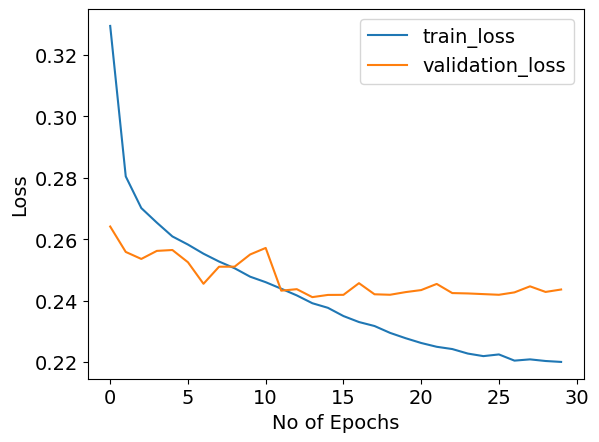

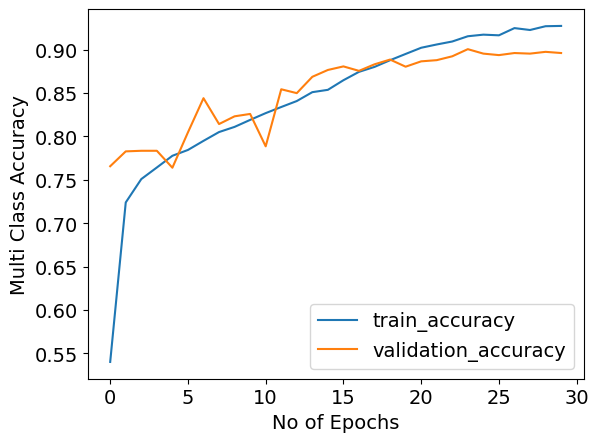

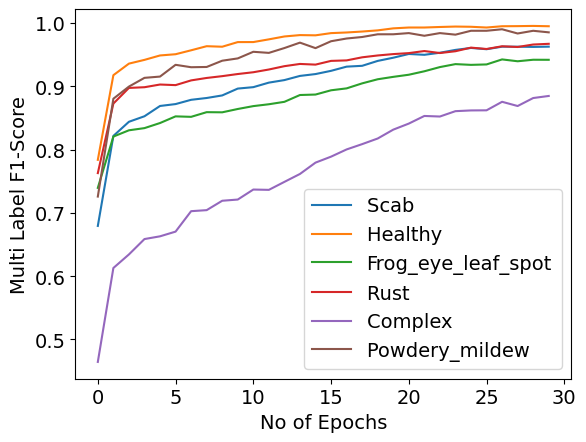

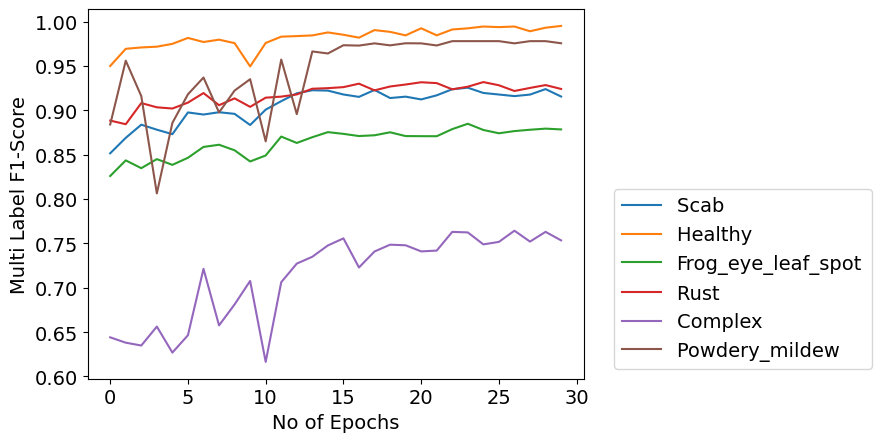

amount of images in train set: [3094 2954 2034 1183 1031  761  433  131  106   80   66   52]
amount of images in valid set: [773 739 508 295 258 191 108  32  26  20  17  14]
**********  fold no  ********************  5  ********************


  3%|██▋                                                                             | 1/30 [08:06<3:55:08, 486.51s/it]


----------------------------------------------------------------------------------------
Epoch : 1 Train_loss:0.333 Validation_loss:0.268 Duration:0:08:06.514960 Lr: 0.0001 Train_Acc:52.63 Validation_Acc:78.87
class ac : [60.5365223  67.02775897 57.86627335 58.91800507  1.64888458 53.61366623
  7.39030023 32.82442748 32.38095238  7.5        12.12121212  1.88679245]
class ac : [94.78047364 89.06133495 93.40350313 96.1604981   1.58202816 87.61619831
  2.83446712 19.13265306 45.35147392 15.30612245 30.0120048   7.84929356]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.8291416074357573 0.5943562610229277 0.6923867138454515
Healthy            0.8933649289099526 0.6730425911757205 0.7677090909090909
Frog_eye_leaf_spot 0.8483650736615164 0.6426238432226457 0.7312993650301998
Rust               0.7735139202407826 0.7173761339846476 0.7443881245474294
Complex            0.5505050505050505 0.4139989148128052 0.4725921337875

  7%|█████▎                                                                          | 2/30 [16:12<3:46:54, 486.23s/it]


----------------------------------------------------------------------------------------
Epoch : 2 Train_loss:0.280 Validation_loss:0.262 Duration:0:08:06.037366 Lr: 9.964516155915151e-05 Train_Acc:71.95 Validation_Acc:81.54
class ac : [82.64382676 88.4901828  81.07177974 80.47337278  3.87972842 79.76346912
  7.15935335 43.51145038 39.04761905  6.25       30.3030303  13.20754717]
class ac : [92.40436149 98.31266742 99.0278001  87.51297129  2.37304224 96.1641201
  3.77928949 12.75510204 52.91005291 20.40816327 60.0240096  15.69858713]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.8947512301804265 0.7569380203515264 0.820095214232022
Healthy            0.9691943127962085 0.8644323671497585 0.9138206192148101
Frog_eye_leaf_spot 0.926697808120733 0.7408790577420281 0.8234355044699873
Rust               0.9187358916478555 0.849095966620306 0.882544271774485
Complex            0.715007215007215 0.5365457498646453 0.6130

 10%|████████                                                                        | 3/30 [24:18<3:38:49, 486.29s/it]


----------------------------------------------------------------------------------------
Epoch : 3 Train_loss:0.271 Validation_loss:0.255 Duration:0:08:06.354326 Lr: 9.858624225078841e-05 Train_Acc:75.27 Validation_Acc:83.45
class ac : [86.87782805 91.63845633 84.21828909 82.079459    6.01357905 85.93955322
  5.77367206 47.32824427 42.85714286  6.25       43.93939394 28.30188679]
class ac : [96.49655464 97.3461103  94.80957737 92.3555863  11.46970416 98.30110054
  7.55857899 51.02040816 45.35147392  5.10204082 66.02641056 15.69858713]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9037725533078185 0.7852731591448932 0.8403660396542959
Healthy            0.970209884901828 0.8998430141287285 0.9337025574197753
Frog_eye_leaf_spot 0.9245418613007546 0.7475305055200465 0.8266666666666667
Rust               0.9360421369450714 0.8416779431664412 0.8863555397221232
Complex            0.7575757575757576 0.5672609400324149 0

 13%|██████████▋                                                                     | 4/30 [32:25<3:30:44, 486.32s/it]


----------------------------------------------------------------------------------------
Epoch : 4 Train_loss:0.265 Validation_loss:0.262 Duration:0:08:06.357551 Lr: 9.683994186497132e-05 Train_Acc:76.96 Validation_Acc:79.48
class ac : [88.68778281 92.51861882 86.28318584 85.79881657  7.371484   87.51642576
  4.84988453 57.2519084  42.85714286  5.         45.45454545 24.52830189]
class ac : [98.74066056 93.4798818  96.61738711 69.52611553  4.74608448 81.20525697
  7.55857899 60.58673469 41.57218443 10.20408163 42.01680672 31.39717425]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9220885729907053 0.7994785494192936 0.8564174177986543
Healthy            0.9766418415707515 0.9123972169512966 0.9434270765206016
Frog_eye_leaf_spot 0.9396334890406036 0.7628354725787632 0.8420544195781677
Rust               0.9435665914221218 0.8450134770889488 0.8915748311411305
Complex            0.7640692640692641 0.5771117166212534 

 17%|█████████████▎                                                                  | 5/30 [40:31<3:22:34, 486.17s/it]


----------------------------------------------------------------------------------------
Epoch : 5 Train_loss:0.261 Validation_loss:0.248 Duration:0:08:05.922139 Lr: 9.443380060197387e-05 Train_Acc:77.98 Validation_Acc:80.54
class ac : [89.85132515 93.53419093 87.36479843 84.86897718 10.96023278 87.6478318
  6.69745958 55.72519084 40.95238095  3.75       48.48484848 28.30188679]
class ac : [98.60865433 92.37524509 84.16358669 86.47526807  9.49216896 97.76685543
  4.72411187 76.53061224 52.91005291  0.         78.03121248 39.24646782]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9256424275560415 0.8182696955050749 0.8686505900461775
Healthy            0.976980365605958 0.9185232336091661 0.9468503937007874
Frog_eye_leaf_spot 0.9317283507006827 0.7624228168185828 0.8386157826649417
Rust               0.944319036869827 0.8631361760660248 0.901904419690981
Complex            0.7813852813852814 0.5885869565217391 0.67

 20%|████████████████                                                                | 6/30 [48:36<3:14:24, 486.04s/it]


----------------------------------------------------------------------------------------
Epoch : 6 Train_loss:0.257 Validation_loss:0.251 Duration:0:08:05.782262 Lr: 9.140576474687265e-05 Train_Acc:79.07 Validation_Acc:82.19
class ac : [91.49967679 94.41435342 87.8072763  85.03803888 12.70611057 88.8304862
  9.23787529 58.77862595 39.04761905  7.5        43.93939394 32.0754717 ]
class ac : [97.94862318 96.24147359 87.57833842 80.59494984 22.14839424 98.30110054
  4.72411187 44.64285714 60.4686319   0.         78.03121248 39.24646782]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9349371241115364 0.8264862252295795 0.8773730118009235
Healthy            0.9820582261340555 0.9318984902023771 0.9563210812592715
Frog_eye_leaf_spot 0.934602946460654 0.7757232329257382 0.8477835723598436
Rust               0.9495861550037622 0.855593220338983 0.9001426533523538
Complex            0.7878787878787878 0.5977011494252874 0.6

 23%|██████████████████▋                                                             | 7/30 [56:42<3:06:18, 486.01s/it]


----------------------------------------------------------------------------------------
Epoch : 7 Train_loss:0.256 Validation_loss:0.253 Duration:0:08:05.953463 Lr: 8.780358823396353e-05 Train_Acc:79.57 Validation_Acc:83.69
class ac : [91.62895928 94.38050102 89.18387414 86.13693998 14.25800194 89.75032852
  6.69745958 58.01526718 40.          7.5        51.51515152 30.18867925]
class ac : [98.60865433 92.2371655  94.60870963 96.50639917 15.8202816  99.36959077
  4.72411187 60.58673469 56.6893424  15.30612245 48.01920768 31.39717425]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9330235101148169 0.8283980582524272 0.8776034970429416
Healthy            0.979011509817197 0.9353169469598965 0.9566655640092623
Frog_eye_leaf_spot 0.9396334890406036 0.7734398107068915 0.8484750162232316
Rust               0.9525959367945824 0.8677176148046607 0.9081779053084649
Complex            0.8210678210678211 0.6158008658008658 0

 27%|████████████████████▊                                                         | 8/30 [1:04:48<2:58:11, 485.98s/it]


----------------------------------------------------------------------------------------
Epoch : 8 Train_loss:0.252 Validation_loss:0.247 Duration:0:08:05.905651 Lr: 8.368407953869104e-05 Train_Acc:80.54 Validation_Acc:85.10
class ac : [92.79250162 95.26066351 89.62635202 86.89771767 15.51891368 91.59001314
  8.54503464 55.72519084 37.14285714  7.5        51.51515152 41.50943396]
class ac : [ 95.17649233 100.10770208  97.01912261  89.58837772  25.7079576
  97.23261032   0.94482237  47.83163265  64.24792139  10.20408163
  66.02641056  39.24646782]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9349371241115364 0.8380298946336682 0.883835120816643
Healthy            0.987813134732566 0.9480181936322287 0.9675066312997348
Frog_eye_leaf_spot 0.9399928135106 0.7846430713857229 0.8553212358999509
Rust               0.9616252821670429 0.8606060606060606 0.908315565031983
Complex            0.8152958152958153 0.61782394751

 30%|███████████████████████▍                                                      | 9/30 [1:12:54<2:50:05, 485.96s/it]


----------------------------------------------------------------------------------------
Epoch : 9 Train_loss:0.250 Validation_loss:0.246 Duration:0:08:05.907072 Lr: 7.911220577405484e-05 Train_Acc:81.66 Validation_Acc:84.17
class ac : [93.82676147 95.26066351 91.44542773 88.16568047 19.10766246 92.37844941
  8.31408776 62.59541985 36.19047619  8.75       54.54545455 35.8490566 ]
class ac : [95.0444861  99.55538372 96.81825486 88.89657558 19.37984496 95.09562987
  1.88964475 41.45408163 60.4686319  15.30612245 66.02641056 54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9423182066703116 0.8421695577815783 0.8894336214681976
Healthy            0.9874746106973595 0.9473855147775252 0.967014752196254
Frog_eye_leaf_spot 0.9428674092705713 0.7965998785670917 0.8635840052657562
Rust               0.9601203912716328 0.8721804511278195 0.9140401146131805
Complex            0.84992784992785 0.6444201312910285 0.7

 33%|█████████████████████████▋                                                   | 10/30 [1:21:00<2:41:58, 485.93s/it]


----------------------------------------------------------------------------------------
Epoch : 10 Train_loss:0.249 Validation_loss:0.248 Duration:0:08:05.876556 Lr: 7.416006812042827e-05 Train_Acc:81.84 Validation_Acc:83.52
class ac : [93.79444085 95.39607312 90.41297935 87.99661877 21.14451988 92.24704336
 10.62355658 64.1221374  35.23809524  6.25       63.63636364 47.16981132]
class ac : [95.57251102 96.51763276 98.2243291  83.36215842 20.96187312 98.83534566
  0.94482237 41.45408163 68.02721088  0.         72.02881152 39.24646782]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9455986878075451 0.852180339985218 0.8964623558377608
Healthy            0.9854434664861205 0.9439040207522698 0.9642265650877774
Frog_eye_leaf_spot 0.9425080848005749 0.8026315789473685 0.866964138158982
Rust               0.9616252821670429 0.8753424657534247 0.9164575116529222
Complex            0.8405483405483406 0.637308533916849 0.

 37%|████████████████████████████▏                                                | 11/30 [1:29:06<2:33:51, 485.87s/it]


----------------------------------------------------------------------------------------
Epoch : 11 Train_loss:0.245 Validation_loss:0.243 Duration:0:08:05.736025 Lr: 6.890576474687263e-05 Train_Acc:82.55 Validation_Acc:86.02
class ac : [94.53781513 96.34394042 91.19960669 88.41927303 22.40543162 92.77266754
  9.69976905 63.35877863 37.14285714 11.25       51.51515152 52.83018868]
class ac : [98.21263564 98.03650824 97.01912261 89.58837772 30.45404208 98.30110054
  5.66893424 51.02040816 64.24792139  5.10204082 66.02641056 39.24646782]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.946965554948059 0.8555198814522105 0.8989230569612041
Healthy            0.9867975626269465 0.9573070607553367 0.971828638106351
Frog_eye_leaf_spot 0.9453826805605462 0.7996960486322189 0.8664580931994073
Rust               0.9683972911963883 0.883321894303363 0.923905240488155
Complex            0.8513708513708513 0.6354334948842219 0.7

 40%|██████████████████████████████▊                                              | 12/30 [1:37:12<2:25:44, 485.83s/it]


----------------------------------------------------------------------------------------
Epoch : 12 Train_loss:0.243 Validation_loss:0.241 Duration:0:08:05.726843 Lr: 6.343215915635762e-05 Train_Acc:83.66 Validation_Acc:86.16
class ac : [95.31351002 97.35951253 91.64208456 88.8419273  25.41222114 93.69250986
 13.16397229 55.72519084 46.66666667 15.         62.12121212 54.71698113]
class ac : [98.87266679 97.76034907 98.42519685 89.9342788  28.08099984 97.76685543
  6.61375661 47.83163265 60.4686319   5.10204082 66.02641056 47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.949699289229087 0.8733031674208145 0.9099004714510215
Healthy            0.9935680433310765 0.9619796787938381 0.97751873438801
Frog_eye_leaf_spot 0.9471793029105282 0.8061162079510703 0.8709730712043615
Rust               0.9699021820917983 0.8834818368745716 0.9246771879483501
Complex            0.8686868686868687 0.6644591611479028 0.

 43%|█████████████████████████████████▎                                           | 13/30 [1:45:17<2:17:38, 485.77s/it]


----------------------------------------------------------------------------------------
Epoch : 13 Train_loss:0.241 Validation_loss:0.248 Duration:0:08:05.640527 Lr: 5.782557337881911e-05 Train_Acc:84.29 Validation_Acc:86.36
class ac : [95.47511312 96.71631686 92.4287119  90.44801352 30.06789525 93.95532194
 14.3187067  63.35877863 35.23809524 13.75       59.09090909 64.1509434 ]
class ac : [ 97.55260448 100.93617961  99.63040334  87.85887236  20.96187312
  97.23261032  17.00680272  57.39795918  37.79289494  25.51020408
  66.02641056  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9502460360852925 0.8727090133065528 0.909828556471666
Healthy            0.9901828029790115 0.9640738299274885 0.9769539078156313
Frog_eye_leaf_spot 0.9493352497305066 0.8164400494437577 0.8778866921415518
Rust               0.9691497366440933 0.8913494809688581 0.9286229271809661
Complex            0.8722943722943723 0.6686

 47%|███████████████████████████████████▉                                         | 14/30 [1:53:23<2:09:32, 485.76s/it]


----------------------------------------------------------------------------------------
Epoch : 14 Train_loss:0.239 Validation_loss:0.245 Duration:0:08:05.740733 Lr: 5.2174426621180906e-05 Train_Acc:85.12 Validation_Acc:86.29
class ac : [95.86296057 97.42721733 93.16617502 90.02535926 32.49272551 94.74375821
 16.16628176 65.64885496 46.66666667 13.75       59.09090909 67.9245283 ]
class ac : [ 97.02457956 101.0742592   98.6260646   87.16707022  26.10346464
  97.76685543  12.28269085  51.02040816  45.35147392  20.40816327
  60.0240096   54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9565336249316566 0.8804730749874182 0.9169287211740041
Healthy            0.991198375084631 0.9711442786069652 0.9810688557547328
Frog_eye_leaf_spot 0.9486166007905138 0.823199251637044 0.8814691151919867
Rust               0.9691497366440933 0.8994413407821229 0.9329952915610286
Complex            0.8932178932178932 0.6772

 50%|██████████████████████████████████████▌                                      | 15/30 [2:01:28<2:01:25, 485.68s/it]


----------------------------------------------------------------------------------------
Epoch : 15 Train_loss:0.237 Validation_loss:0.243 Duration:0:08:05.506341 Lr: 4.65678408436424e-05 Train_Acc:85.93 Validation_Acc:87.80
class ac : [96.31544926 97.76574137 93.90363815 91.71597633 35.30552861 95.40078844
 20.7852194  56.48854962 43.80952381 15.         59.09090909 62.26415094]
class ac : [ 99.40069171 100.52194085  97.42085811  87.16707022  42.71476032
  96.69836521  16.06198035  38.26530612  37.79289494  15.30612245
  66.02641056  39.24646782]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9568069983597595 0.8860759493670886 0.9200841219768665
Healthy            0.994583615436696 0.9734923790589795 0.9839249832551908
Frog_eye_leaf_spot 0.95400646784046 0.8346431939641622 0.8903420523138833
Rust               0.9706546275395034 0.9020979020979021 0.9351214208046393
Complex            0.8845598845598845 0.6950113

 53%|█████████████████████████████████████████                                    | 16/30 [2:09:34<1:53:18, 485.62s/it]


----------------------------------------------------------------------------------------
Epoch : 16 Train_loss:0.235 Validation_loss:0.242 Duration:0:08:05.485692 Lr: 4.109423525312738e-05 Train_Acc:86.26 Validation_Acc:87.29
class ac : [96.21848739 97.93500339 93.70698132 90.53254438 38.70029098 95.0065703
 24.7113164  60.30534351 37.14285714 25.         54.54545455 69.81132075]
class ac : [ 97.94862318 100.93617961  97.8225936   87.85887236  32.43157728
  96.69836521  23.62055933  44.64285714  52.91005291  15.30612245
  60.0240096   54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9598141060688901 0.8906646372399797 0.9239473684210526
Healthy            0.996614759647935 0.973867019517036 0.9851095867492052
Frog_eye_leaf_spot 0.9565217391304348 0.8389536716041601 0.8938885157824042
Rust               0.9736644093303235 0.9061624649859944 0.9387014871236852
Complex            0.8924963924963925 0.699265

 57%|███████████████████████████████████████████▋                                 | 17/30 [2:17:39<1:45:12, 485.58s/it]


----------------------------------------------------------------------------------------
Epoch : 17 Train_loss:0.232 Validation_loss:0.243 Duration:0:08:05.465800 Lr: 3.583993187957173e-05 Train_Acc:87.48 Validation_Acc:88.42
class ac : [97.12346477 98.54434665 93.90363815 91.71597633 43.5499515  95.92641261
 29.56120092 61.83206107 44.76190476 17.5        60.60606061 60.37735849]
class ac : [ 98.87266679 101.35041838  99.0278001   86.82116915  37.5731688
  96.69836521  26.45502646  54.20918367  49.13076342  25.51020408
  60.0240096   54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9636413340623291 0.9059367771781033 0.9338985296065704
Healthy            0.9962762356127285 0.98001998001998 0.9880812489508142
Frog_eye_leaf_spot 0.959396334890406 0.8538535337384074 0.9035532994923858
Rust               0.9759217456734387 0.9063591893780573 0.9398550724637681
Complex            0.8910533910533911 0.7142857

 60%|██████████████████████████████████████████████▏                              | 18/30 [2:26:13<1:38:48, 494.05s/it]


----------------------------------------------------------------------------------------
Epoch : 18 Train_loss:0.230 Validation_loss:0.242 Duration:0:08:33.619548 Lr: 3.088779422594514e-05 Train_Acc:88.37 Validation_Acc:87.87
class ac : [97.12346477 98.57819905 94.7394297  92.73034658 48.30261882 96.45203679
 33.94919169 58.01526718 47.61904762 22.5        59.09090909 66.03773585]
class ac : [ 98.74066056 101.76465715  98.6260646   87.16707022  24.12592944
  96.69836521  46.2962963   41.45408163  52.91005291  20.40816327
  60.0240096   54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9652815746309459 0.9102861562258314 0.9369775772853921
Healthy            0.9955991875423155 0.9793539793539794 0.9874097700184656
Frog_eye_leaf_spot 0.9615522817103844 0.8643410852713178 0.9103589045756081
Rust               0.9781790820165538 0.9187279151943463 0.9475218658892128
Complex            0.8975468975468975 0.728

 63%|████████████████████████████████████████████████▊                            | 19/30 [2:35:40<1:34:34, 515.84s/it]


----------------------------------------------------------------------------------------
Epoch : 19 Train_loss:0.229 Validation_loss:0.241 Duration:0:09:26.453511 Lr: 2.631592046130896e-05 Train_Acc:89.26 Validation_Acc:88.62
class ac : [97.38202973 98.40893703 94.98525074 92.98393914 52.27934045 96.97766097
 39.72286374 64.88549618 48.57142857 27.5        63.63636364 81.13207547]
class ac : [ 98.87266679 101.76465715  98.6260646   89.24247665  34.80461952
  95.62987499  35.90325019  38.26530612  56.6893424   25.51020408
  60.0240096   54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9699289229086933 0.9149045899948427 0.9416135881104034
Healthy            0.9955991875423155 0.9816421895861148 0.9885714285714285
Frog_eye_leaf_spot 0.9644268774703557 0.8719948018193632 0.9158846613205938
Rust               0.9804364183596689 0.9247693399574166 0.9517896274653032
Complex            0.9177489177489178 0.755

 67%|███████████████████████████████████████████████████▎                         | 20/30 [2:44:08<1:25:36, 513.69s/it]


----------------------------------------------------------------------------------------
Epoch : 20 Train_loss:0.228 Validation_loss:0.241 Duration:0:08:28.533039 Lr: 2.2196411766036492e-05 Train_Acc:89.68 Validation_Acc:88.93
class ac : [97.86683904 99.0182803  95.23107178 92.81487743 52.7643065  96.71484888
 42.49422633 67.9389313  49.52380952 26.25       60.60606061 75.47169811]
class ac : [ 99.66470417 101.35041838  96.41651936  84.05396057  41.92374624
  97.23261032  49.13076342  41.45408163  52.91005291  15.30612245
  60.0240096   47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9696555494805905 0.9220171562256304 0.945236508994004
Healthy            0.9969532836831415 0.9872611464968153 0.9920835438773792
Frog_eye_leaf_spot 0.9615522817103844 0.8719452590420332 0.9145591250854409
Rust               0.9841986455981941 0.922425952045134 0.9523116126683655
Complex            0.9213564213564214 0.7665

 70%|█████████████████████████████████████████████████████▉                       | 21/30 [2:52:16<1:15:52, 505.84s/it]


----------------------------------------------------------------------------------------
Epoch : 21 Train_loss:0.226 Validation_loss:0.242 Duration:0:08:07.530640 Lr: 1.859423525312737e-05 Train_Acc:90.36 Validation_Acc:88.86
class ac : [98.02844215 99.11983751 95.62438545 93.15300085 57.4199806  97.50328515
 45.03464203 63.35877863 47.61904762 36.25       57.57575758 71.69811321]
class ac : [100.45674156 100.79810002  97.8225936   87.16707022  34.40911248
  97.23261032  51.02040816  41.45408163  41.57218443  15.30612245
  60.0240096   47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9726626571897211 0.9309262166405023 0.9513368983957219
Healthy            0.997291807718348 0.9875963794837412 0.9924204143506822
Frog_eye_leaf_spot 0.967301473230327 0.8872775214238628 0.9255630049853877
Rust               0.9796839729119639 0.9313304721030042 0.9548954895489549
Complex            0.9170274170274171 0.775 0

 73%|████████████████████████████████████████████████████████▍                    | 22/30 [3:00:57<1:08:03, 510.48s/it]


----------------------------------------------------------------------------------------
Epoch : 22 Train_loss:0.224 Validation_loss:0.242 Duration:0:08:41.155496 Lr: 1.556619939802614e-05 Train_Acc:90.84 Validation_Acc:89.41
class ac : [97.99612153 99.22139472 96.36184857 93.32206255 58.38991271 97.24047306
 46.18937644 67.17557252 56.19047619 27.5        77.27272727 83.01886792]
class ac : [ 99.7967104  101.21233879  98.2243291   88.89657558  37.96867584
  97.76685543  47.24111867  41.45408163  45.35147392  35.71428571
  54.02160864  54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9756697648988518 0.9320971533037347 0.9533858688393215
Healthy            0.998645903859174 0.991930060524546 0.99527665317139
Frog_eye_leaf_spot 0.9694574200503054 0.8869165023011177 0.9263519313304721
Rust               0.981941309255079 0.9294871794871795 0.9549945115257958
Complex            0.9386724386724387 0.77950868

 77%|███████████████████████████████████████████████████████████                  | 23/30 [3:09:58<1:00:37, 519.60s/it]


----------------------------------------------------------------------------------------
Epoch : 23 Train_loss:0.223 Validation_loss:0.242 Duration:0:09:00.873116 Lr: 1.316005813502869e-05 Train_Acc:91.38 Validation_Acc:89.31
class ac : [98.28700711 99.35680433 96.26352016 93.82924768 61.00872939 97.37187911
 49.88452656 74.04580153 46.66666667 36.25       71.21212121 84.90566038]
class ac : [100.58874779 100.38386126  97.42085811  87.51297129  39.94621104
  97.76685543  49.13076342  44.64285714  41.57218443  20.40816327
  60.0240096   54.94505495]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9762165117550574 0.9333507579717721 0.9543025120256547
Healthy            0.998645903859174 0.9905977165883143 0.9946055293324343
Frog_eye_leaf_spot 0.9683794466403162 0.896540252827678 0.9310761789600968
Rust               0.9857035364936042 0.9363831308077198 0.9604105571847508
Complex            0.9372294372294372 0.79840

 80%|███████████████████████████████████████████████████████████████▏               | 24/30 [3:19:30<53:31, 535.23s/it]


----------------------------------------------------------------------------------------
Epoch : 24 Train_loss:0.224 Validation_loss:0.241 Duration:0:09:31.674381 Lr: 1.1413757749211607e-05 Train_Acc:91.19 Validation_Acc:89.41
class ac : [98.06076277 99.15368991 96.01769912 93.99830938 61.59068865 97.89750329
 50.11547344 64.1221374  46.66666667 37.5        68.18181818 77.35849057]
class ac : [100.72075402 101.35041838  97.62172586  89.58837772  35.99114064
  96.69836521  52.91005291  38.26530612  30.23431595  35.71428571
  54.02160864  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.972936030617824 0.9358401262161451 0.9540276102399142
Healthy            0.9969532836831415 0.9895833333333334 0.9932546374367622
Frog_eye_leaf_spot 0.9687387711103126 0.8965746591286997 0.9312607944732297
Rust               0.9804364183596689 0.9367361610352265 0.9580882352941177
Complex            0.93001443001443 0.79176

 83%|█████████████████████████████████████████████████████████████████▊             | 25/30 [3:28:13<44:17, 531.58s/it]


----------------------------------------------------------------------------------------
Epoch : 25 Train_loss:0.222 Validation_loss:0.243 Duration:0:08:43.071306 Lr: 1.0354838440848501e-05 Train_Acc:91.87 Validation_Acc:89.27
class ac : [98.31932773 99.0859851  97.00098328 94.3364328  63.04558681 97.50328515
 55.42725173 67.9389313  53.33333333 35.         74.24242424 83.01886792]
class ac : [ 99.00467302 101.62657756  97.42085811  87.85887236  41.5282392
  96.1641201   49.13076342  41.45408163  37.79289494  35.71428571
  60.0240096   47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9781301257517769 0.9381227058206607 0.9577087794432548
Healthy            0.998645903859174 0.9889373114314448 0.9937678962438943
Frog_eye_leaf_spot 0.9719726913402803 0.9031719532554258 0.9363101419176185
Rust               0.9811888638073739 0.9381294964028777 0.9591761677087164
Complex            0.9357864357864358 0.8152

 87%|████████████████████████████████████████████████████████████████████▍          | 26/30 [3:36:19<34:31, 517.94s/it]


----------------------------------------------------------------------------------------
Epoch : 26 Train_loss:0.221 Validation_loss:0.242 Duration:0:08:05.953031 Lr: 1e-05 Train_Acc:92.21 Validation_Acc:89.65
class ac : [98.44861021 99.25524712 96.55850541 94.08284024 63.82153249 98.29172142
 58.66050808 69.46564885 56.19047619 37.5        78.78787879 92.45283019]
class ac : [100.06072287 101.48849797  97.01912261  89.9342788   41.92374624
  96.1641201   48.18594104  44.64285714  41.57218443  25.51020408
  60.0240096   47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9789502460360853 0.9426164780205317 0.9604398551696393
Healthy            0.997968855788761 0.9909243697478992 0.9944341372912802
Frog_eye_leaf_spot 0.9683794466403162 0.9052737655357743 0.9357638888888888
Rust               0.9834462001504891 0.9382627422828428 0.9603232916972814
Complex            0.943001443001443 0.8214959145191704 0.87

 90%|███████████████████████████████████████████████████████████████████████        | 27/30 [3:44:25<25:25, 508.39s/it]


----------------------------------------------------------------------------------------
Epoch : 27 Train_loss:0.222 Validation_loss:0.242 Duration:0:08:06.130855 Lr: 1e-05 Train_Acc:92.29 Validation_Acc:89.03
class ac : [98.41628959 99.32295193 96.85349066 93.91377853 65.66440349 97.76609724
 59.81524249 68.70229008 53.33333333 35.         74.24242424 79.24528302]
class ac : [ 99.26868548 101.35041838  97.8225936   87.85887236  41.5282392
  96.69836521  41.57218443  41.45408163  34.01360544  25.51020408
  66.02641056  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9775833788955713 0.9400630914826499 0.9584561779683731
Healthy            0.997291807718348 0.9912516823687753 0.9942625717178535
Frog_eye_leaf_spot 0.9712540424002875 0.9064386317907445 0.9377276669557676
Rust               0.9857035364936042 0.9465317919075145 0.9657206044968669
Complex            0.9336219336219336 0.8148614609571788 0.87

 93%|█████████████████████████████████████████████████████████████████████████▋     | 28/30 [3:52:31<16:43, 501.70s/it]


----------------------------------------------------------------------------------------
Epoch : 28 Train_loss:0.221 Validation_loss:0.243 Duration:0:08:06.069552 Lr: 1e-05 Train_Acc:92.45 Validation_Acc:89.38
class ac : [98.41628959 99.32295193 95.62438545 93.99830938 67.21629486 98.29172142
 59.81524249 74.04580153 53.33333333 51.25       72.72727273 88.67924528]
class ac : [100.32473533 101.48849797  97.42085811  90.28017987  41.5282392
  96.1641201   39.68253968  41.45408163  37.79289494  25.51020408
  54.02160864  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9808638600328048 0.9427220178665265 0.9614147909967846
Healthy            0.997291807718348 0.9919191919191919 0.9945982444294396
Frog_eye_leaf_spot 0.9744879626302552 0.9134388683058269 0.9429763560500696
Rust               0.9864559819413092 0.9445244956772334 0.965034965034965
Complex            0.9386724386724387 0.813125 0.8713998660415

 97%|████████████████████████████████████████████████████████████████████████████▎  | 29/30 [4:00:37<08:17, 497.03s/it]


----------------------------------------------------------------------------------------
Epoch : 29 Train_loss:0.221 Validation_loss:0.242 Duration:0:08:06.002672 Lr: 1e-05 Train_Acc:92.36 Validation_Acc:89.68
class ac : [98.44861021 99.49221395 96.75516224 94.42096365 64.88845781 98.29172142
 58.66050808 71.75572519 51.42857143 35.         74.24242424 90.56603774]
class ac : [ 99.7967104  101.0742592   97.62172586  90.97198201  43.90128144
  96.69836521  42.5170068   41.45408163  41.57218443  35.71428571
  54.02160864  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9789502460360853 0.9436100131752305 0.960955320005367
Healthy            0.998645903859174 0.991930060524546 0.99527665317139
Frog_eye_leaf_spot 0.9683794466403162 0.9049697783747481 0.9356014580801945
Rust               0.9834462001504891 0.9389367816091954 0.9606762219772143
Complex            0.9531024531024531 0.8245942571785269 0.88420

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [4:08:44<00:00, 497.48s/it]


----------------------------------------------------------------------------------------
Epoch : 30 Train_loss:0.220 Validation_loss:0.242 Duration:0:08:06.403411 Lr: 1e-05 Train_Acc:93.04 Validation_Acc:89.48
class ac : [98.54557207 99.42450914 97.00098328 94.67455621 69.25315228 98.29172142
 62.3556582  71.75572519 61.9047619  41.25       74.24242424 81.13207547]
class ac : [ 99.13667925 101.35041838  97.8225936   91.31788309  40.34171808
  96.1641201   50.07558579  41.45408163  41.57218443  25.51020408
  48.01920768  47.09576138]
Multi_Label_Metrics:
                       Recall            Precision           F1 Score      
Scab               0.9794969928922909 0.946131502508582 0.9625251846877099
Healthy            0.998645903859174 0.9905977165883143 0.9946055293324343
Frog_eye_leaf_spot 0.9741286381602587 0.9131020545638262 0.9426286509040334
Rust               0.9872084273890143 0.9514140681653372 0.9689807976366323
Complex            0.948051948051948 0.8364099299809039 0.888

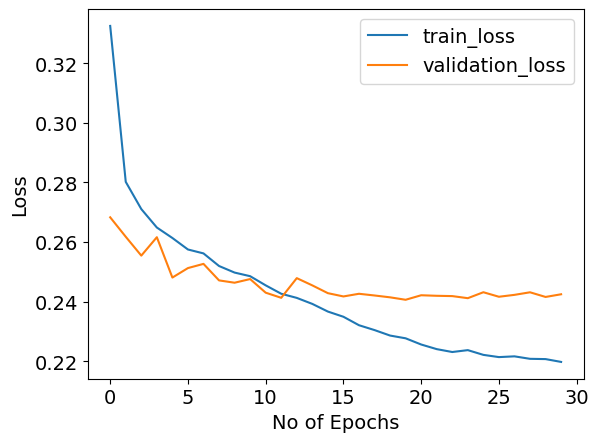

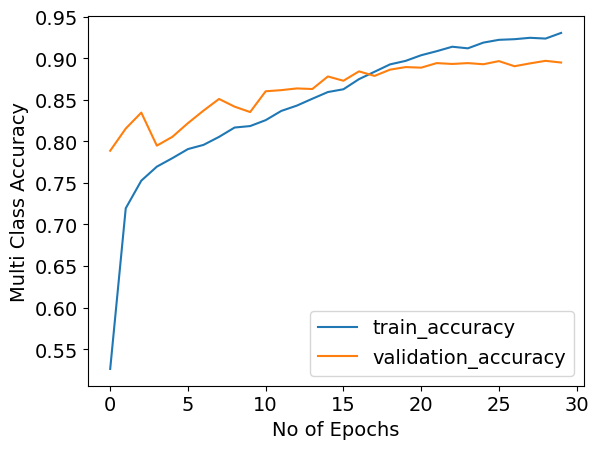

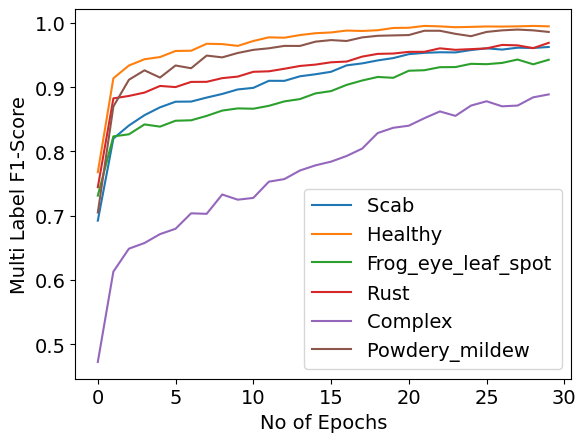

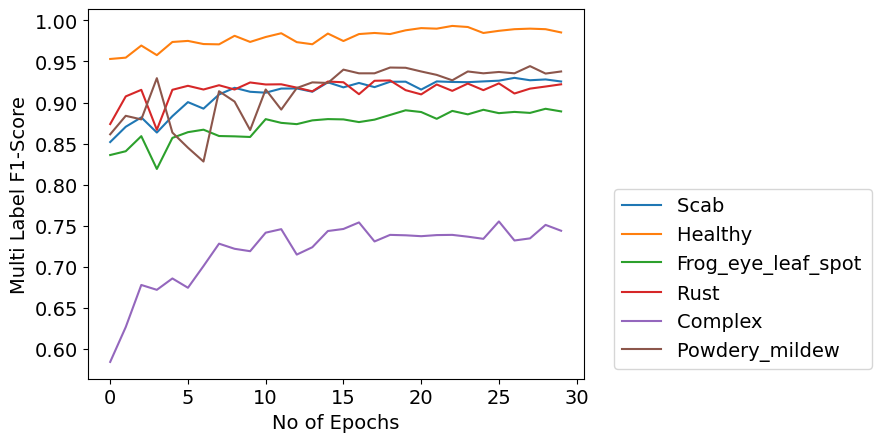

amount of images in train set: [3094 2954 2034 1183 1031  761  433  131  105   80   66   53]
amount of images in valid set: [773 739 508 295 258 191 108  32  27  20  17  13]


In [ ]:
batch_size = 20
splits=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
label_names = ['Scab              ','Healthy           ','Frog_eye_leaf_spot','Rust              ','Complex           ','Powdery_mildew    ']
for fold, (train_idx,val_idx) in enumerate(splits.split(df_train['image_id'],df_train['label'])):
  if fold > 2:
    train_dl = DataLoader(pathology_train,batch_size=batch_size,sampler=train_idx,pin_memory=True)
    val_dl = DataLoader(pathology_val,batch_size=batch_size,sampler=val_idx,pin_memory=True)
    model = start_model(printchild=False)
    model.to(device)
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []
    train_ml_f1 = []
    val_ml_f1 = []
    prev_accuracy = 0.84
    reducing_rate = 0.8
    smoothing_ratio = 0.2
    threshold_array = 0.25
    flag = 0
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler1 = CosineAnnealingLR(optimizer,
                                 T_max=25,
                                 eta_min=1e-5)
    print('**********  fold no  ********************  {}  ********************'.format(fold+1))
    batch_gd(model=model,criterion=criterion,optimizer=optimizer,train_loader=train_dl,validation_loader=val_dl,epochs=30,foldd=fold+1)
    os.chdir('C:/Local Machine/plant-pathology-final-3/saves')
    torch.save(model, 'swinv2t'+str(fold+1)+'_chkpnt.pt')
    plt.plot(train_losses , label = 'train_loss')
    plt.plot(validation_losses , label = 'validation_loss')
    plt.xlabel('No of Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.plot(train_accuracies , label = 'train_accuracy')
    plt.plot(validation_accuracies , label = 'validation_accuracy')
    plt.xlabel('No of Epochs')
    plt.ylabel('Multi Class Accuracy')
    plt.legend()
    plt.show()
    plt.plot(train_ml_f1 , label = label_names)
    plt.xlabel('No of Epochs')
    plt.ylabel('Multi Label F1-Score')
    plt.legend()
    plt.show()
    plt.plot(val_ml_f1 , label = label_names)
    plt.xlabel('No of Epochs')
    plt.ylabel('Multi Label F1-Score')
    plt.legend(loc = 'lower right',bbox_to_anchor=(1.6, 0.0))
    plt.show()
    print('amount of images in train set:', train_cm.sum(axis=1))
    print('amount of images in valid set:', validation_cm.sum(axis=1))

In [ ]:
def test_data(model, criterion, test_loader):
        global test_cm
        global test_predictions
        global test_targets
        global test_outputs
        global test_mlcm
        t0 = datetime.now()
        test_n_correct = 0
        test_n_total = 0
        test_cm = np.zeros((12,2),dtype=int)            #multi class confusion matrix
        test_targets = np.empty((0,6),dtype=int)
        test_predictions = np.empty((0,6),dtype=int)
        test_outputs = np.empty((0,6),dtype = float)
        test_mlcm = np.zeros((6,2,2),dtype=int)         #multi label confusion matrix
        test_loss = []
        model.eval()
        with torch.no_grad():
          for inputs, targets in test_loader:
            soft_targets = torch.where(targets==0, smoothing_ratio/targets_size, 1-smoothing_ratio + smoothing_ratio/targets_size )
            #print(soft_targets)
            inputs, soft_targets = inputs.to(device), soft_targets.to(device)
            output = model(inputs)
            #print(output)
            #output, aux_output = model(inputs)  #for Inception_v3
            loss = criterion(output, soft_targets)
            test_loss.append(loss.item())
            predictions = np.array(output.cpu().detach().numpy() > threshold_array, dtype=int)
            targets = np.array(targets.cpu().detach().numpy())
            #print("predictions: ",predictions)
            #print("targets:     ",targets)
            test_outputs = np.append(test_outputs,output.cpu().detach().numpy(),axis=0)
            test_predictions = np.append(test_predictions,predictions,axis=0)
            test_targets = np.append(test_targets,targets,axis=0)
            #print(test_predictions)
            test_mlcm = test_mlcm + multilabel_confusion_matrix(targets,predictions)
            for i in range(len(targets)):
                class_number = int(np.where((classes == targets[i]).all(axis=1))[0])
                if (predictions[i] == targets[i]).all():
                    test_cm[class_number][0] += 1
                else:
                    test_cm[class_number][1] += 1
        test_loss = np.mean(test_loss)
        test_accuracy = test_cm[:,0].sum()*100/(test_mlcm[0].sum())
        dt = datetime.now() - t0
        print()
        print('----------------------------------------------------------------------------------------')
        print(f"Test_loss:{test_loss:.3f} Duration:{dt} Test_Acc:{test_accuracy:.2f}")
        print("class ac",end=" : ")
        class_accuracy_test = test_cm[:,0]/test_cm.sum(axis=1)*100
        print(class_accuracy_test)
        print('Multi_Label_Metrics:')
        label_names = ['Scab              ','Healthy           ','Frog_eye_leaf_spot','Rust              ','Complex           ','Powdery_mildew    ']
        print('                       Accuracy           Recall            Precision           F1 Score      ')
        temp_list = []
        for i in range(6):
          #acc = (test_mlcm[i,0,0]+test_mlcm[i,1,1])/(test_mlcm[0].sum())
          rec = (test_mlcm[i,1,1])/(test_mlcm[i,1,1]+test_mlcm[i,1,0])
          pre = (test_mlcm[i,1,1])/(test_mlcm[i,1,1]+test_mlcm[i,0,1])
          f1  = (2*test_mlcm[i,1,1])/(2*test_mlcm[i,1,1]+test_mlcm[i,0,1]+test_mlcm[i,1,0])
          print(label_names[i],rec,pre,f1)
          temp_list.append(f1)
        return test_loss
label_names = ['Scab              ','Healthy           ','Frog_eye_leaf_spot','Rust              ','Complex           ','Powdery_mildew    ']
smoothing_ratio = 0.2
threshold_array = 0.25
criterion = nn.BCELoss()
test_dl = DataLoader(pathology_test,batch_size=20,shuffle=False,pin_memory=True)
os.chdir('C:/Local Machine/plant-pathology-final-3/saves')
for model in ['swinv2t1_chkpnt.pt','swinv2t1.pt','swinv2t2_chkpnt.pt','swinv2t2.pt','swinv2t3_chkpnt.pt','swinv2t3.pt','swinv2t4_chkpnt.pt','swinv2t4.pt','swinv2t5_chkpnt.pt','swinv2t5.pt']:
  model = torch.load(model)
  test_data(model,criterion,test_dl)
print('amount of images in test set:', test_cm.sum(axis=1))
#######################
#######################
######################## Note that this part is used to check whether i calcuclated the metrics right or not
#######################         | | | | | | | | |
#######################         \/\/\/\/\/\/\/\/
print(test_mlcm)
print(multilabel_confusion_matrix(test_targets,test_predictions))
print(accuracy_score(test_targets,test_predictions))
print(recall_score(test_targets,test_predictions,average=None))
print(precision_score(test_targets,test_predictions,average=None))
print(f1_score(test_targets,test_predictions,average=None))
print(test_targets)
print(test_predictions)
print(test_outputs)


----------------------------------------------------------------------------------------
Test_loss:0.228 Duration:0:01:04.927609 Test_Acc:90.44
class ac : [97.74869656 99.         96.80907668 91.67015707 63.85623003 96.4137931
 43.82758621 42.24324324 35.36363636 29.         49.         70.42857143]
Multi_Label_Metrics:
                       Accuracy           Recall            Precision           F1 Score      
Scab               0.9640666082383874 0.9212730318257957 0.9421841541755889
Healthy            1.0 0.9893730074388948 0.9946581196581197
Frog_eye_leaf_spot 0.9519450800915332 0.8888888888888888 0.9193370165745857
Rust               0.9735576923076923 0.9782608695652174 0.9759036144578314
Complex            0.8827751196172249 0.7817796610169492 0.8292134831460675
Powdery_mildew     0.9802371541501976 0.9959839357429718 0.9880478087649402

----------------------------------------------------------------------------------------
Test_loss:0.226 Duration:0:01:04.176891 Test_Acc:91

[0.00000000e+00 0.00000000e+00 0.00000000e+00 3.86847195e-04
 3.86847195e-04 7.73694391e-04 7.73694391e-04 1.16054159e-03
 1.16054159e-03 1.54738878e-03 1.54738878e-03 1.93423598e-03
 1.93423598e-03 2.70793037e-03 2.70793037e-03 3.09477756e-03
 3.09477756e-03 3.48162476e-03 3.48162476e-03 3.86847195e-03
 3.86847195e-03 4.25531915e-03 4.25531915e-03 4.64216634e-03
 4.64216634e-03 5.02901354e-03 5.02901354e-03 5.80270793e-03
 5.80270793e-03 6.18955513e-03 6.18955513e-03 6.57640232e-03
 6.57640232e-03 6.96324952e-03 6.96324952e-03 7.35009671e-03
 7.35009671e-03 7.73694391e-03 7.73694391e-03 8.12379110e-03
 8.12379110e-03 8.51063830e-03 8.51063830e-03 8.89748549e-03
 8.89748549e-03 9.28433269e-03 9.28433269e-03 9.67117988e-03
 9.67117988e-03 1.04448743e-02 1.04448743e-02 1.08317215e-02
 1.08317215e-02 1.12185687e-02 1.12185687e-02 1.23791103e-02
 1.23791103e-02 1.31528046e-02 1.31528046e-02 1.35396518e-02
 1.35396518e-02 1.39264990e-02 1.39264990e-02 1.43133462e-02
 1.43133462e-02 1.547388

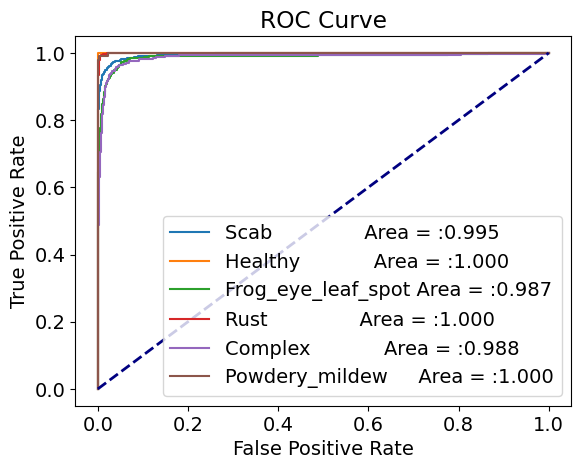

In [ ]:
#########################
######################### important: ROC Curve can not be applied to a multi-label case! this plot is wrong!
#########################

label_names = ['Scab              ','Healthy           ','Frog_eye_leaf_spot','Rust              ','Complex           ','Powdery_mildew    ']
roc_list = []
for i in range(6):
  fpr, tpr, thresholds = roc_curve(test_targets[:,i], test_outputs[:,i])
  print(fpr)
  print(tpr)
  auc_score = auc(fpr, tpr,)
  roc_list.append([fpr,tpr,auc_score])
  plt.plot(fpr,tpr , label = label_names[i]+f" Area = :{auc_score:.3f}")
print()
print(roc_list[:][3])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
plt.figure(figsize=(16,16))
plot_confusion_matrix(train_cm, labels_list)

In [ ]:
plt.figure(figsize=(16,16))
plot_confusion_matrix(validation_cm, labels_list)